In [2]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import DataLoader

from scipy import stats
from scipy.stats import norminvgauss, norm, pareto, levy_stable

import random

import torchvision

import tqdm
from tqdm import trange

import pandas as pd
import csv


from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)


class Monitor:
    def __init__(self):
        if hasattr(tqdm.tqdm, '_instances'):
            [*map(tqdm.tqdm._decr_instances, list(tqdm.tqdm._instances))]

        self.learning_curve = []
        self.train_accuracy_curve = []
        self.val_accuracy_curve = []
        self.best_val_accuracy = 0
        self.best_val_epoch = 0

    def add_loss_value(self, value):
        self.learning_curve.append(value)

    def add_train_accuracy_value(self, value):
        self.train_accuracy_curve.append(value)

    def add_val_accuracy_value(self, value):
        self.val_accuracy_curve.append(value)

        if value > self.best_val_accuracy:
            self.best_val_accuracy = value
            self.best_val_epoch = len(self.val_accuracy_curve)

    def show(self):
        display.clear_output(wait=True)
        f, axes = plt.subplots(1, 2, figsize=(15, 3))
        axes[0].set_title('Loss')
        axes[0].plot(self.learning_curve)

        last_train_accuracy = self.train_accuracy_curve[-1]
        last_val_accuracy = self.val_accuracy_curve[-1]
        best_val_accuracy = self.best_val_accuracy
        best_val_accuracy = self.best_val_accuracy

        axes[1].set_title(f'Train {last_train_accuracy:.4f}, val {last_val_accuracy:.4f}, '
                          f'max val {self.best_val_accuracy:.4f} at {self.best_val_epoch}')
        axes[1].plot(self.train_accuracy_curve)
        axes[1].plot(self.val_accuracy_curve)

        plt.tight_layout()
        plt.show()


def set_random_seeds(seed_value=0, device='cpu'):
    '''source https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5'''
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu':
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [5]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


# 1 Convolutional network Lenet on the MNIST 
For this model,
we vary batch size

In [13]:
Lenetcnn = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                   
                    nn.Flatten(),
                    nn.Linear(400,84),
                    nn.ReLU(),
                    nn.Linear(84,10),
                    nn.Softmax())

## 2 Training procedure

In [14]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
# Method for gathering gradients from NN
def get_grads(model):
    grads = []
    for param in model.parameters():
        if param.requires_grad == True:
            grads.append(param.grad.view(-1))
    grad_flat = torch.cat(grads)
    return grad_flat

def save_grads(model, optimizer, loss_function, train_loader, device, filepath, log_num_iter):
    with open(filepath + f'_epoch_logiter_{log_num_iter}.npy', 'ab') as file:

        for model_input_gr, target_gr in train_loader:
            model_input_gr = model_input_gr.to(device)
            target_gr = target_gr.to(device)
            model_output_gr = model(model_input_gr)
            loss_gr= loss_function(model_output_gr, target_gr)
            optimizer.zero_grad()
            #calc the gradient on batch
              # ? do we need retain_grads=False
            loss_gr.backward()
              #store the gradient
              #Full gradient will be calculated later, 
              #as mean of the saved gradients of all batches 
            grad = get_grads(model).cpu()
            np.save(file, grad.numpy())


def train(model, optimizer, loss_function, train_loader, val_loader, device, filepath, epochs=1, plot_each=1, log_iter=100):
    # send the model to that device
    model = model.to(device)
    monitor = Monitor()
    
    log_num_iter=0
    for epoch in trange(epochs):
        model.train()
        
        for iter, (model_input, target)  in enumerate(train_loader):
            
            #Idea1 no batches full data-> bad runtime out of memory
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
            # do some visualization
            monitor.add_loss_value(loss.item())
            #calculate grad on iteration
            if (iter+1) % log_iter == 0:
                log_num_iter+=1
                with open(filepath + f'_logiter_{log_num_iter}.npy', 'ab') as file:
                    for model_input_gr, target_gr in train_loader:
                        model_input_gr = model_input_gr.to(device)
                        target_gr = target_gr.to(device)
                        model_output_gr = model(model_input_gr)
                        loss_gr= loss_function(model_output_gr, target_gr)
                        optimizer.zero_grad()
                        #calc the gradient on batch
                        # ? do we need retain_grads=False
                        loss_gr.backward()
                                #store the gradient
                                #Full gradient will be calculated later, 
                                #as mean of the saved gradients of all batches 
                        grad = get_grads(model).cpu()
                        np.save(file, grad.numpy())
        # evaluate the model
        model.eval()
            
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()

    return model

## 3 Experiment
Batch size =150

In [16]:
# # NN parameters
# seeds = list(range(3))


# depth = [2, 3, 4, 5]
#width = [1632, 64, 128, 256, 512, 1024]
# batch_size = [50, 100, 150, 200, 300]

# Hyperparameters
width = 128
depth = 2
batch_size = 150
lr = 1e-1
epochs = 10
log_iter=100
total_iterations=epochs*(60000/batch_size)/log_iter
print('total iterations',total_iterations)

total iterations 40.0


In [7]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST

mnist_train = MNIST(root = './', train=True, download=True, 
                    transform=torchvision.transforms.ToTensor())
mnist_val = MNIST(root = './', train=False, download=True, 
                  transform=torchvision.transforms.ToTensor())

--2021-03-20 01:06:01--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-20 01:06:01--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [       <=>          ]  33,20M  6,89MB/s    in 5,3s    

2021-03-20 01:06:07 (6,26 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-id

In [8]:
import os
os.getcwd()

'/Users/fingon/Documents/ML skoltech'

### Mini-Batch Stochastic Gradient Descent


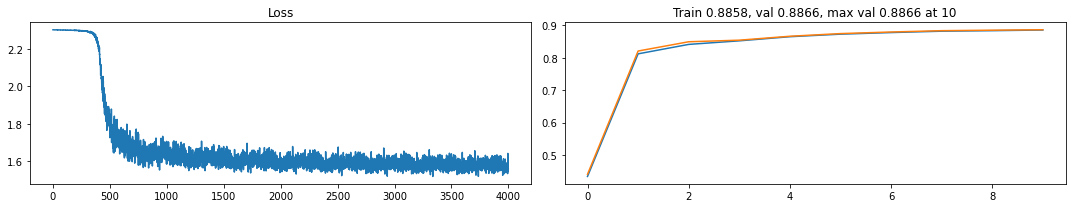

100%|██████████| 10/10 [08:56<00:00, 53.67s/it]


In [17]:
set_random_seeds(device=device)
batch_size=150
#your file path where save gradients
#can be your local path ir google drive path
filepath = 'exp_ml/grads_batch_150'

#in case of google drive
#filepath='/content/gdrive/MyDrive/Gradient_exp/grads_batch_100'

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=2)


#model = FullyConnected(input_dim=28*28, width=width, depth=depth, num_classes=10)
model=Lenetcnn
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


mini_batch_150_model = train(model, optimizer, loss_function,
                             train_loader, val_loader,
                             device, filepath=filepath, epochs=epochs,
                             log_iter=100)

## 4 SG noise distribution's exploration

### 4.1 Calculating SGN and launching $\alpha$-estimator

We decided to start our investigation from the elementwise localization of parameters in a particuar network and the exploration of its distribution throughout all minibatches for a fixed epoch.   

In [18]:
def alpha_estimator(x):

    K = len(x)
    list1 = np.array([d for d in range (1, K // 2 + 1) if K % d == 0] + [K])
    difference = abs(np.sqrt(K) - list1)
    K_1 = list1[np.argmin(difference)]
    K_2 = int(K/K_1)
    y = np.zeros(K_2)
    for i in range(K_2):
        y[i] = sum((x[j + (i-1) * K_1] for j in range(K_1)))

    return 1 / ((1/np.log(K_1)) * ((1/K_2) * sum(np.log(abs(y))) - (1/len(x)) * sum(np.log(abs(x)))))

def alpha_dynamics(mean_alphas, params):
    plt.figure(figsize=(12, 8))
    plt.plot(params, mean_alphas, 'o-', label=r'$ \alpha $')
    plt.xlabel('Epochs', size=13)
    plt.ylabel(r'mean $ \alpha $', size=13)
    plt.title(r'$ \alpha $ dynamics', size=15)
    plt.legend(fontsize=15)
    plt.grid(True)
    plt.savefig(filepath + '_ep_150_alpha_dynamics.png')
    plt.show()


In [19]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches
batchsize=150
N = int(60000/150)
alphas = []
sgn_storage = []

for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
    sgn_storage.append(sgn)
    del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn_storage[-1]))
    print(sgn_storage[-1].shape)
    

  3%|▎         | 1/39 [00:14<09:11, 14.51s/it]

(26885, 400)


  5%|▌         | 2/39 [00:30<09:10, 14.88s/it]

(27208, 400)


  8%|▊         | 3/39 [00:46<09:05, 15.15s/it]

(27952, 400)


 10%|█         | 4/39 [01:04<09:25, 16.17s/it]

(30476, 400)


 13%|█▎        | 5/39 [01:23<09:34, 16.90s/it]

(31115, 400)


 15%|█▌        | 6/39 [01:41<09:29, 17.25s/it]

(31229, 400)


 18%|█▊        | 7/39 [01:59<09:20, 17.53s/it]

(31241, 400)


 21%|██        | 8/39 [02:17<09:06, 17.63s/it]

(31281, 400)


 23%|██▎       | 9/39 [02:34<08:47, 17.57s/it]

(31283, 400)


 26%|██▌       | 10/39 [02:51<08:25, 17.44s/it]

(31672, 400)


 28%|██▊       | 11/39 [03:09<08:13, 17.63s/it]

(32024, 400)


 31%|███       | 12/39 [03:28<08:03, 17.91s/it]

(32381, 400)


 33%|███▎      | 13/39 [03:48<08:04, 18.65s/it]

(32723, 400)


 36%|███▌      | 14/39 [04:07<07:43, 18.54s/it]

(33064, 400)


 38%|███▊      | 15/39 [04:25<07:27, 18.63s/it]

(33742, 400)


 41%|████      | 16/39 [04:44<07:08, 18.62s/it]

(33796, 400)


 44%|████▎     | 17/39 [05:04<06:55, 18.89s/it]

(33766, 400)


 46%|████▌     | 18/39 [05:23<06:42, 19.16s/it]

(33788, 400)


 49%|████▊     | 19/39 [05:42<06:21, 19.06s/it]

(33864, 400)


 51%|█████▏    | 20/39 [06:03<06:09, 19.43s/it]

(33864, 400)


 54%|█████▍    | 21/39 [06:23<05:55, 19.74s/it]

(33926, 400)


 56%|█████▋    | 22/39 [06:41<05:27, 19.24s/it]

(33918, 400)


 59%|█████▉    | 23/39 [06:59<05:01, 18.85s/it]

(33899, 400)


 62%|██████▏   | 24/39 [07:18<04:43, 18.89s/it]

(33891, 400)


 64%|██████▍   | 25/39 [07:36<04:20, 18.61s/it]

(33983, 400)


 67%|██████▋   | 26/39 [07:54<03:59, 18.44s/it]

(34000, 400)


 69%|██████▉   | 27/39 [08:12<03:40, 18.35s/it]

(34024, 400)


 72%|███████▏  | 28/39 [08:30<03:20, 18.20s/it]

(34009, 400)


 74%|███████▍  | 29/39 [08:48<03:02, 18.23s/it]

(34342, 400)


 77%|███████▋  | 30/39 [09:07<02:44, 18.24s/it]

(34390, 400)


 79%|███████▉  | 31/39 [09:26<02:28, 18.55s/it]

(34414, 400)


 82%|████████▏ | 32/39 [09:44<02:08, 18.35s/it]

(34410, 400)


 85%|████████▍ | 33/39 [10:02<01:49, 18.29s/it]

(34410, 400)


 87%|████████▋ | 34/39 [10:20<01:31, 18.26s/it]

(34421, 400)


 90%|████████▉ | 35/39 [10:38<01:12, 18.20s/it]

(34443, 400)


 92%|█████████▏| 36/39 [10:56<00:54, 18.25s/it]

(34435, 400)


 95%|█████████▍| 37/39 [11:14<00:36, 18.13s/it]

(34460, 400)


 97%|█████████▋| 38/39 [11:33<00:18, 18.17s/it]

(34446, 400)


100%|██████████| 39/39 [11:51<00:00, 18.23s/it]

(34463, 400)


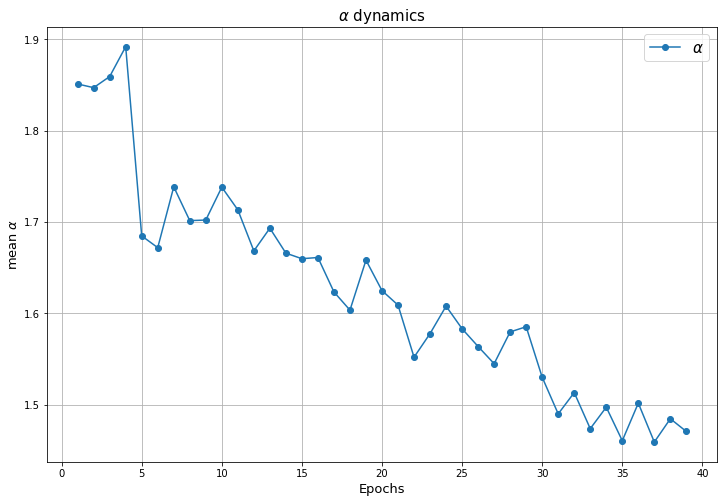

In [20]:
mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [itera for itera in range(1, int(total_iterations), 1)])

### 4.2 Visualizing SGN distribution

In [21]:
def SGD_noise_distplots(SGD_noise, distribution, dist_name, bins):

  params = distribution.fit(SGD_noise)
  Theoretical_dist = distribution(*params)
  x = np.linspace(SGD_noise.min(), SGD_noise.max(), len(SGD_noise))

  SGD_noise_hist = np.histogram(SGD_noise ,bins = bins)

  fig, axs = plt.subplots(4, 1, figsize=(16, 40))
  # axs[0].hist(SGD_noise, density=True, bins=bins, color='white', ec='black', label='SGD Noise')
  axs[0].hist(SGD_noise, density=True, bins=bins, label='SGD Noise')
  axs[0].hist(Theoretical_dist.rvs(size=len(SGD_noise)), density=True, bins=bins, label=dist_name)
  # axs[0].plot(x, Theoretical_dist.pdf(x), '--', color='black', label='Gaussian')
  axs[0].set_xlabel('SGD noise', size=13)
  axs[0].set_ylabel('Density', size=13)
  axs[0].set_title('SGD noise hist', size=15)
  axs[0].legend(fontsize=15)

  axs[1].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[1].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[1].set_xlabel('SGD noise', size=13)
  axs[1].set_ylabel('Density', size=13)
  axs[1].set_title('SGD noise dotted hist', size=15)
  axs[1].legend(fontsize=15)

  axs[2].set_yscale('log')
  axs[2].plot(SGD_noise_hist[1][:-1],SGD_noise_hist[0],'o',  color='black', label='SGD Noise')
  axs[2].plot(x, Theoretical_dist.pdf(x), '--', color='black', label=dist_name)
  axs[2].set_xlabel('SGD noise', size=13)
  axs[2].set_ylabel('log-scaled Density', size=13)
  axs[2].set_title('SGD noise dotted log hist', size=15)
  axs[2].legend(fontsize=15)

  stats.probplot(SGD_noise, dist=Theoretical_dist, plot=plt)
  plt.title('SGD noise QQ-plot', size=15)
  plt.xlabel('Theoretical Quantiles', size=13)
  plt.ylabel('Sample Quantiles', size=13)

  plt.grid()
  

  plt.show()  

## Iteration 0 batch size 150

In [22]:
# amount of epochs
len(sgn_storage)

39

In [23]:
# 1200 gradients per batch for 89911 neurons in 5th epoch
sgn_storage[0].shape

(26885, 400)

# Conv1

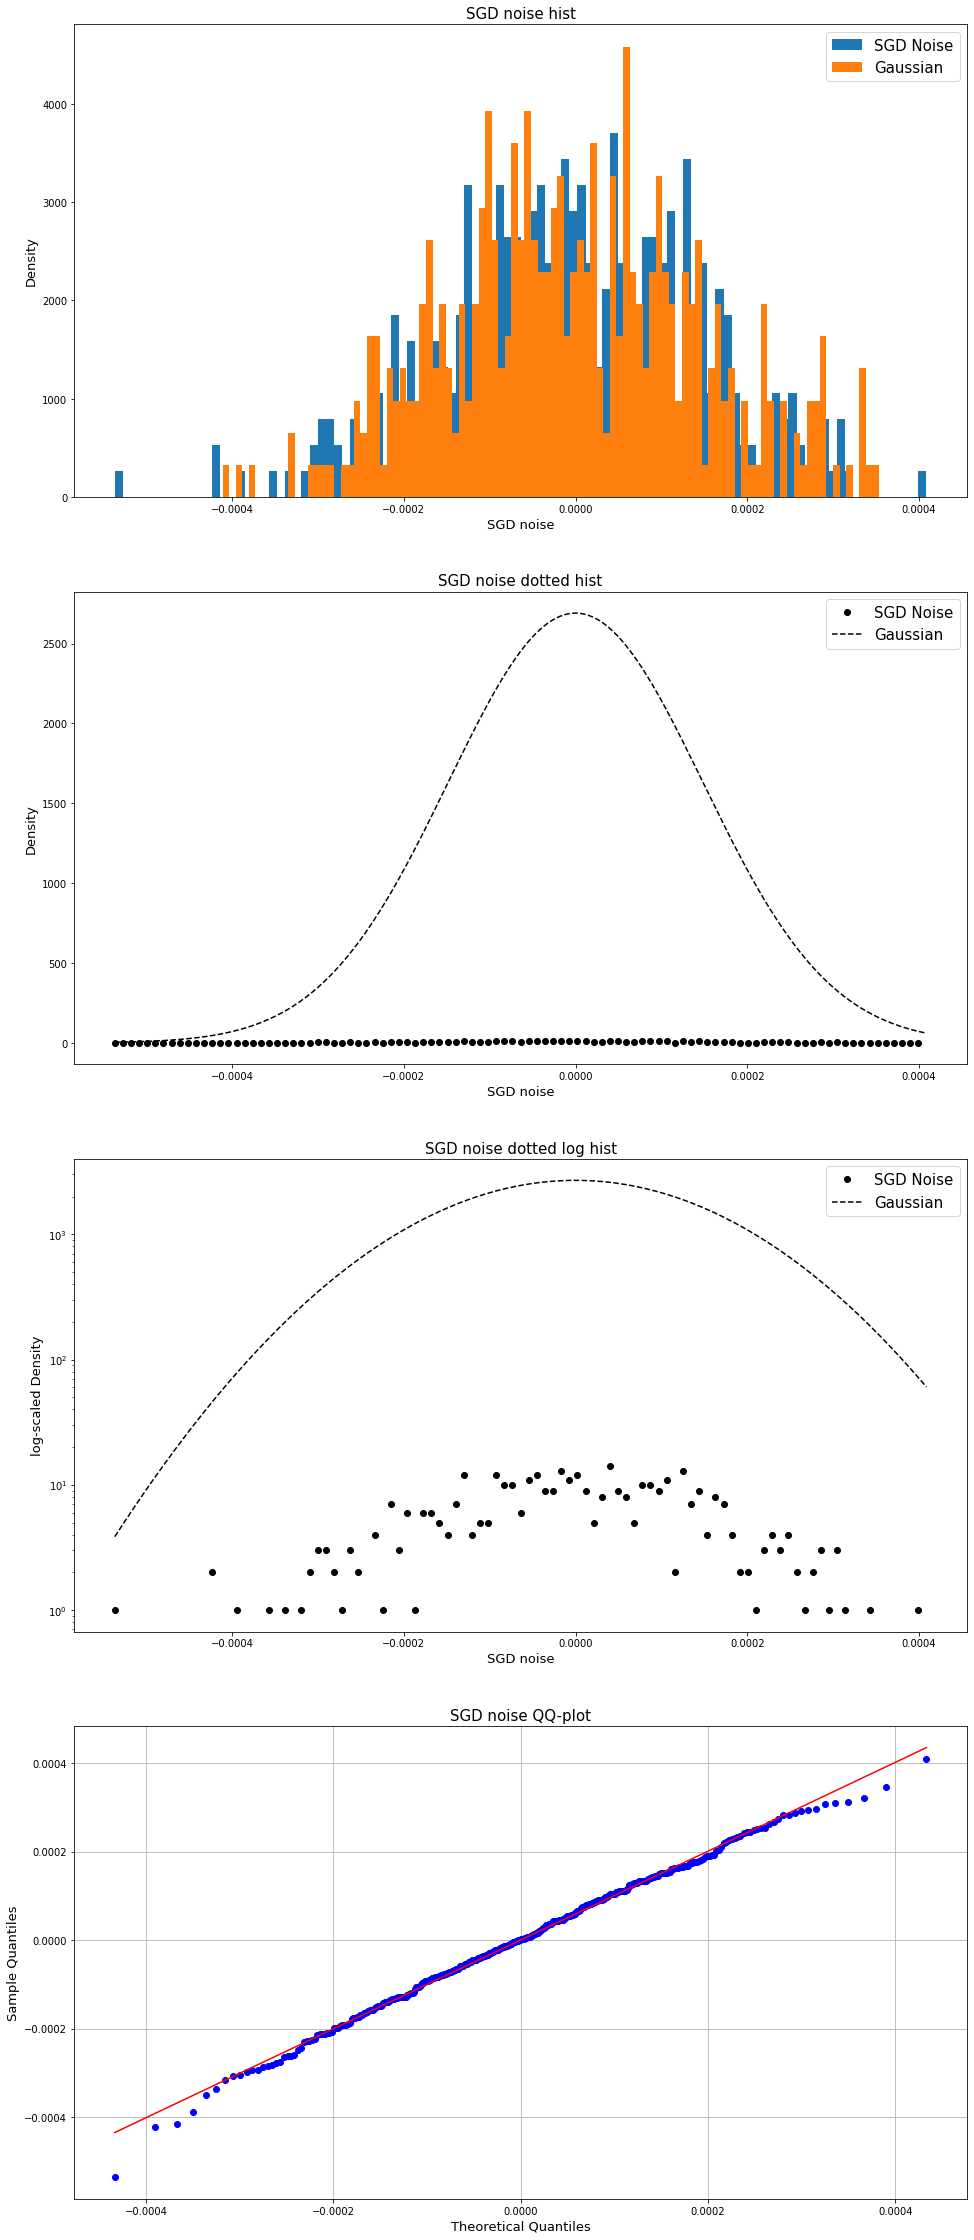

In [24]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][111], distribution=norm, dist_name='Gaussian', bins=100)

# Conv2

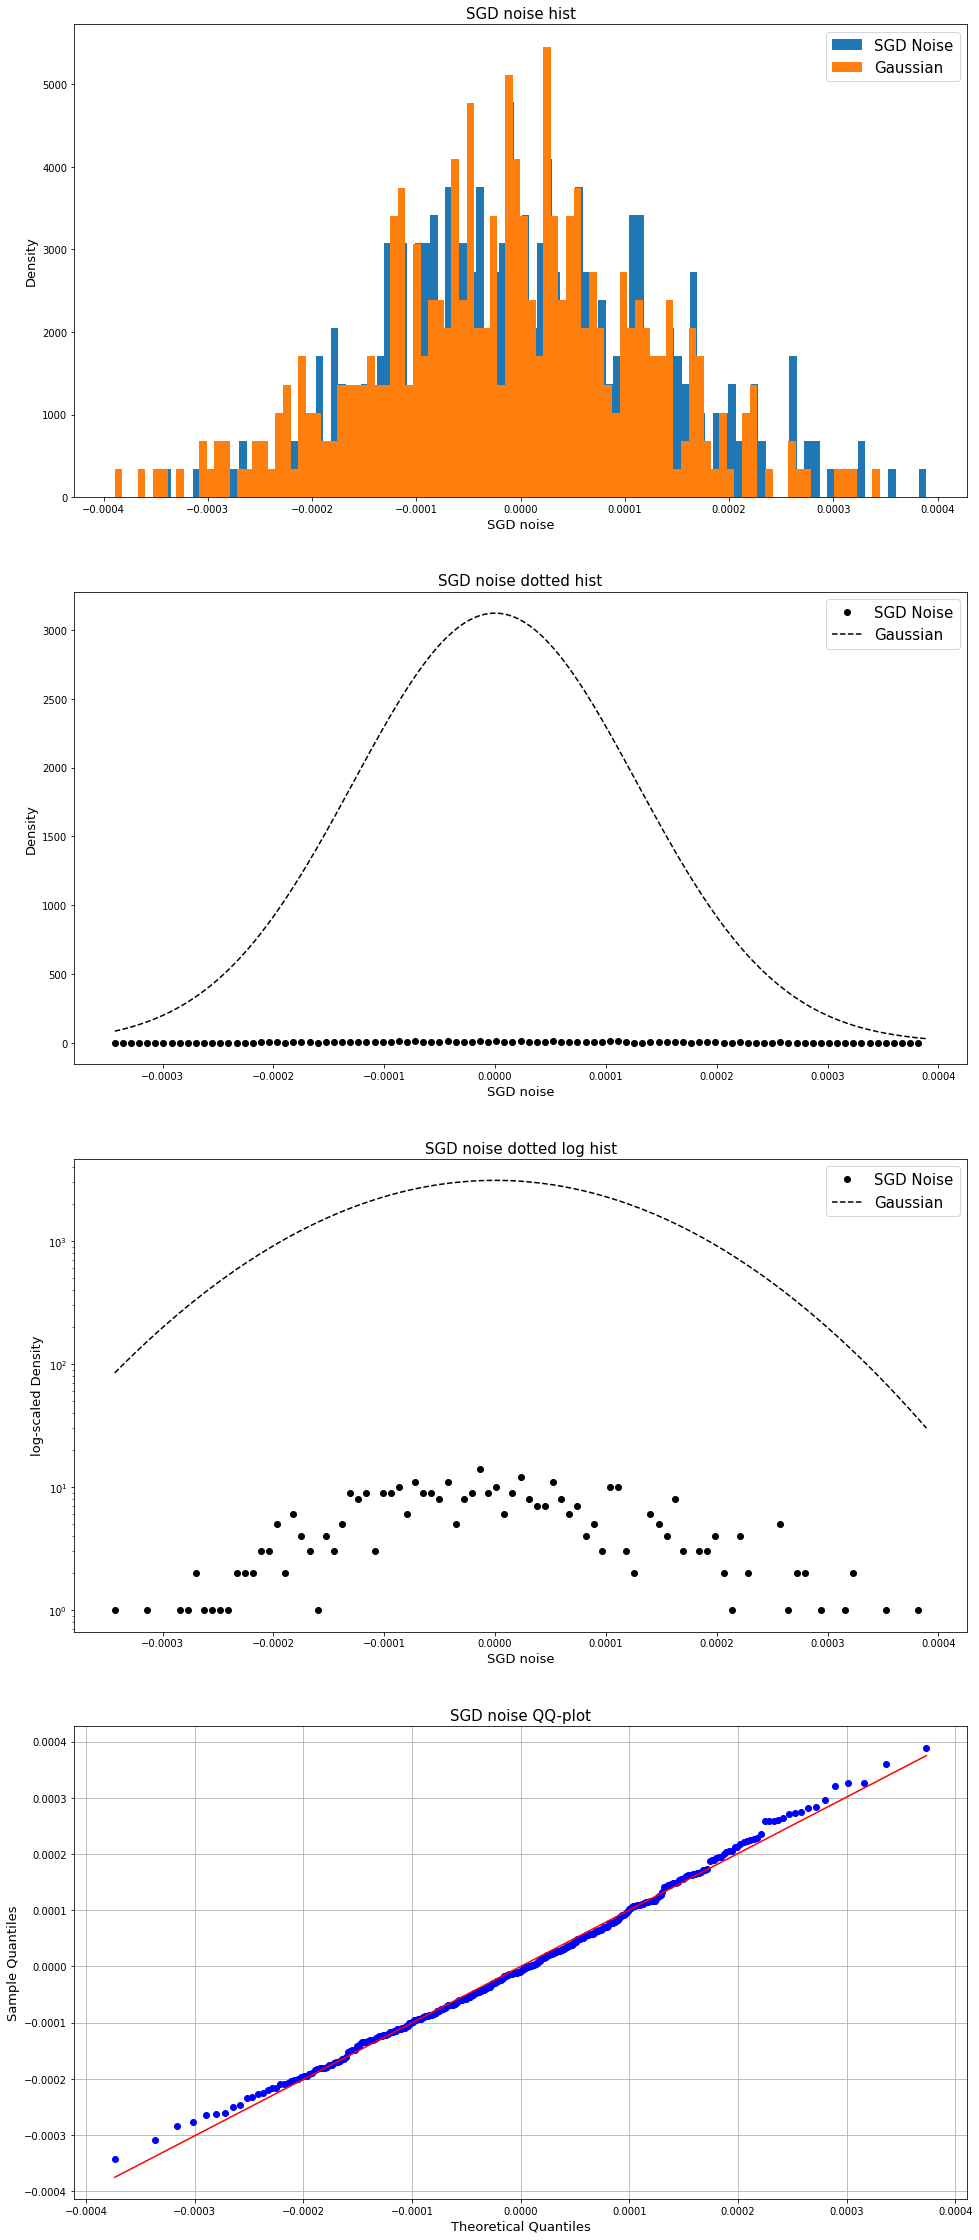

In [25]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][300], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 1

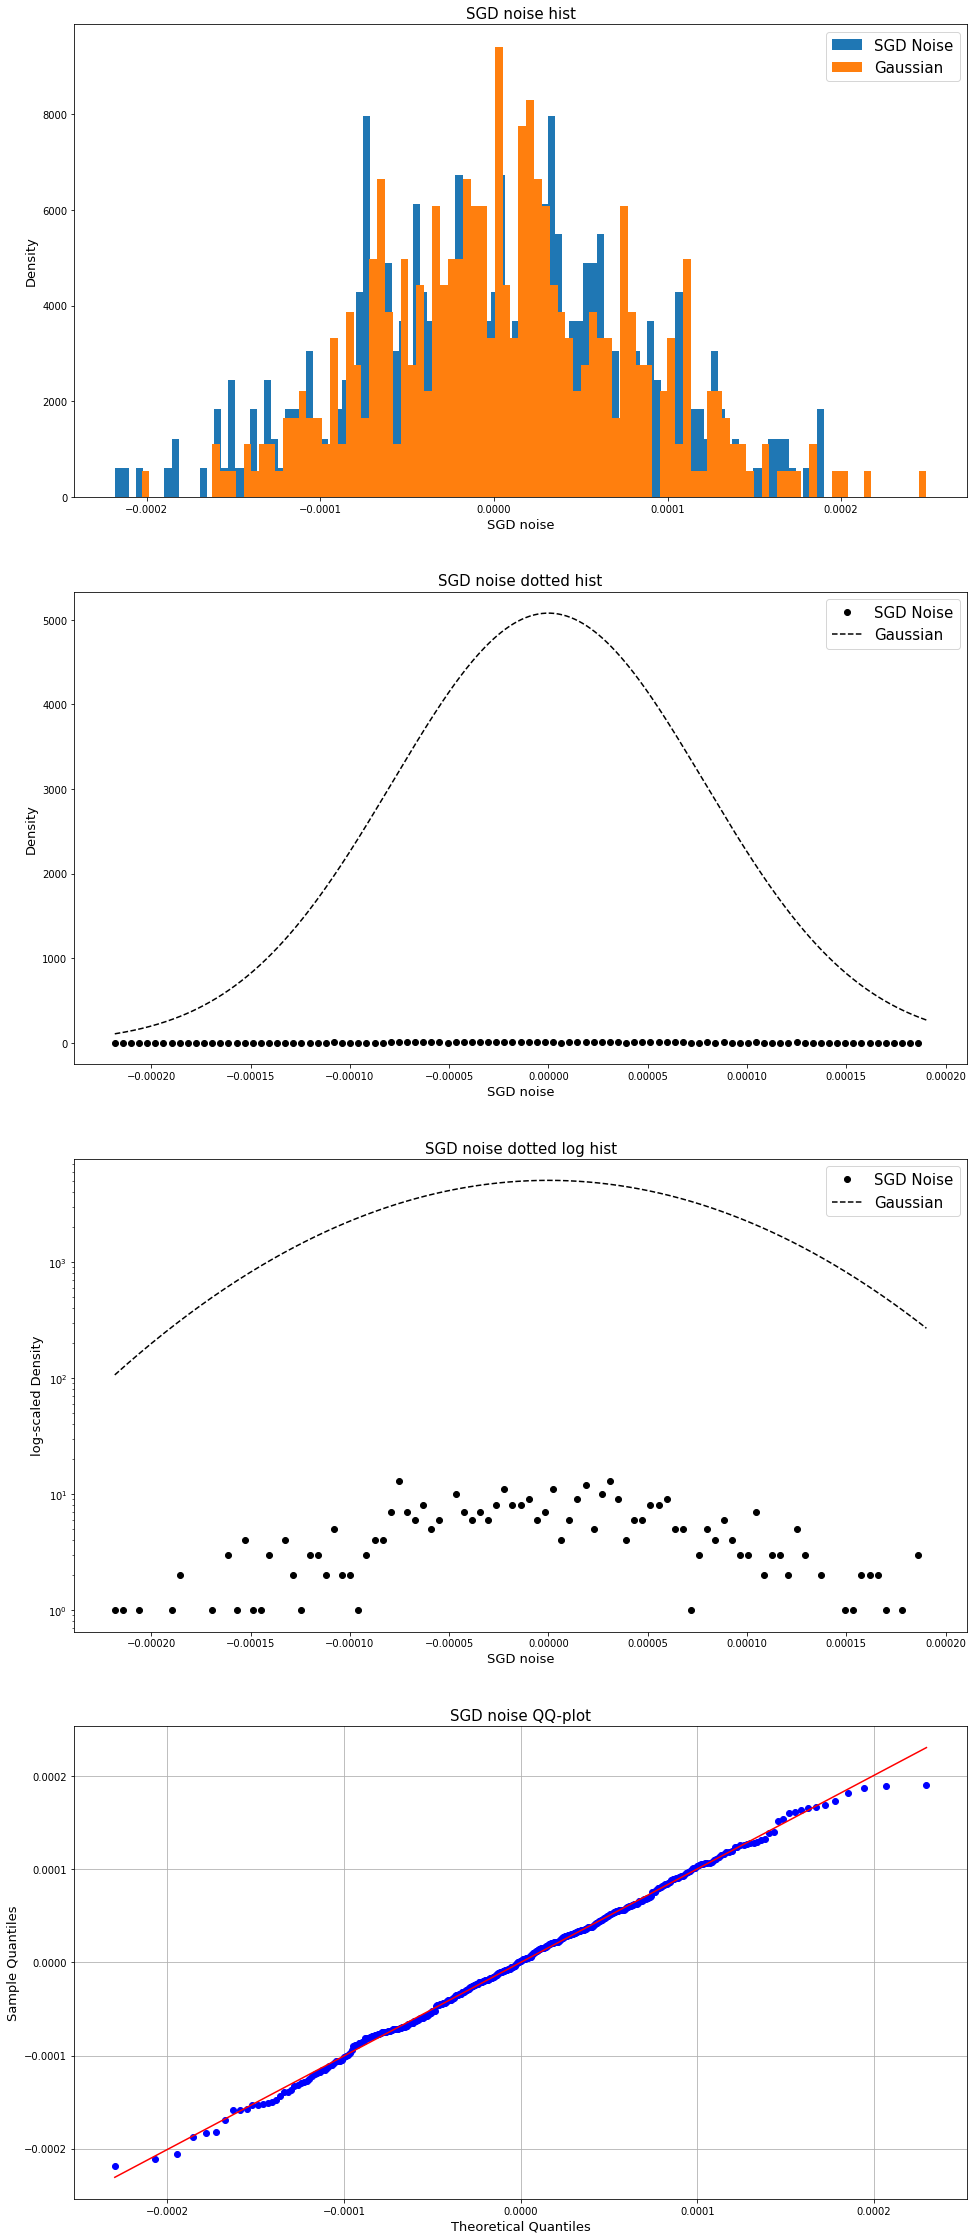

In [26]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][20000], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 2

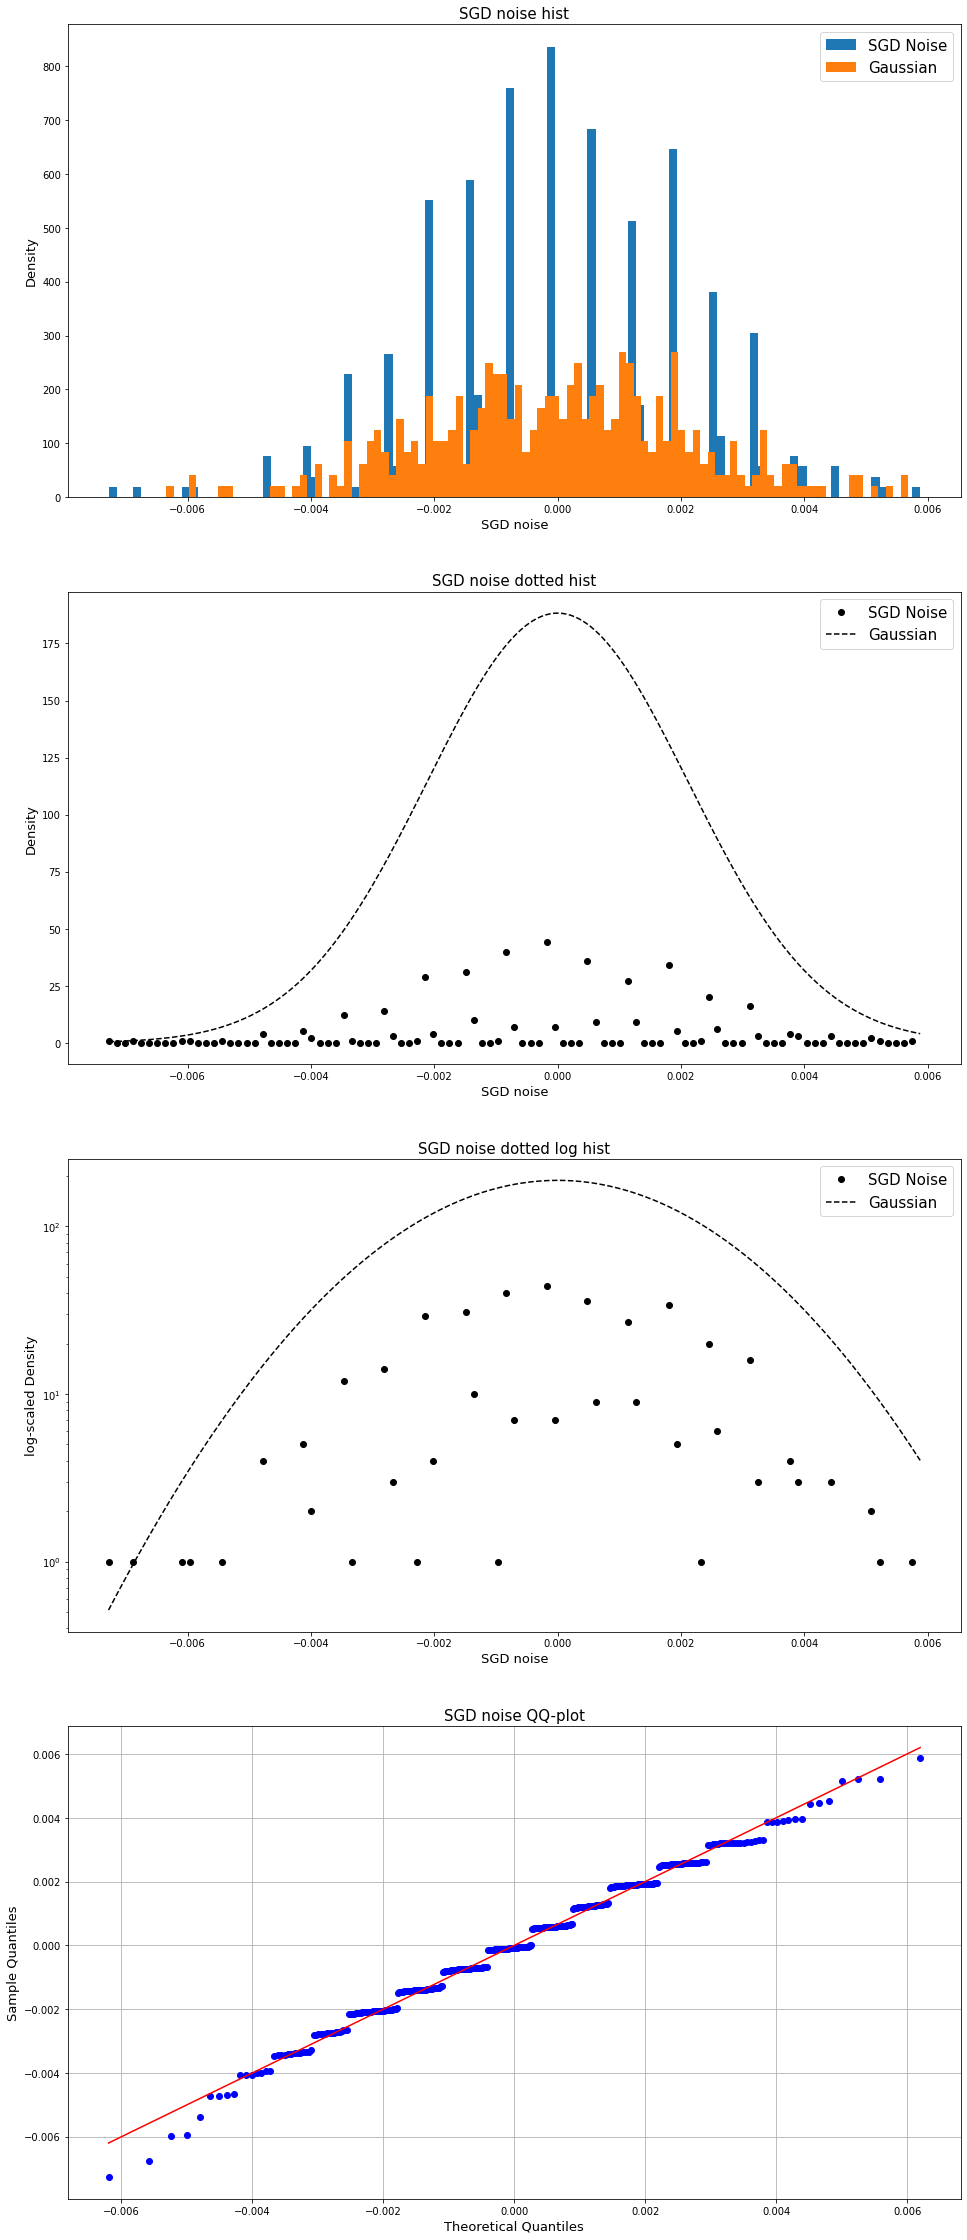

In [29]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #15

In [30]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[15].shape

(33796, 400)

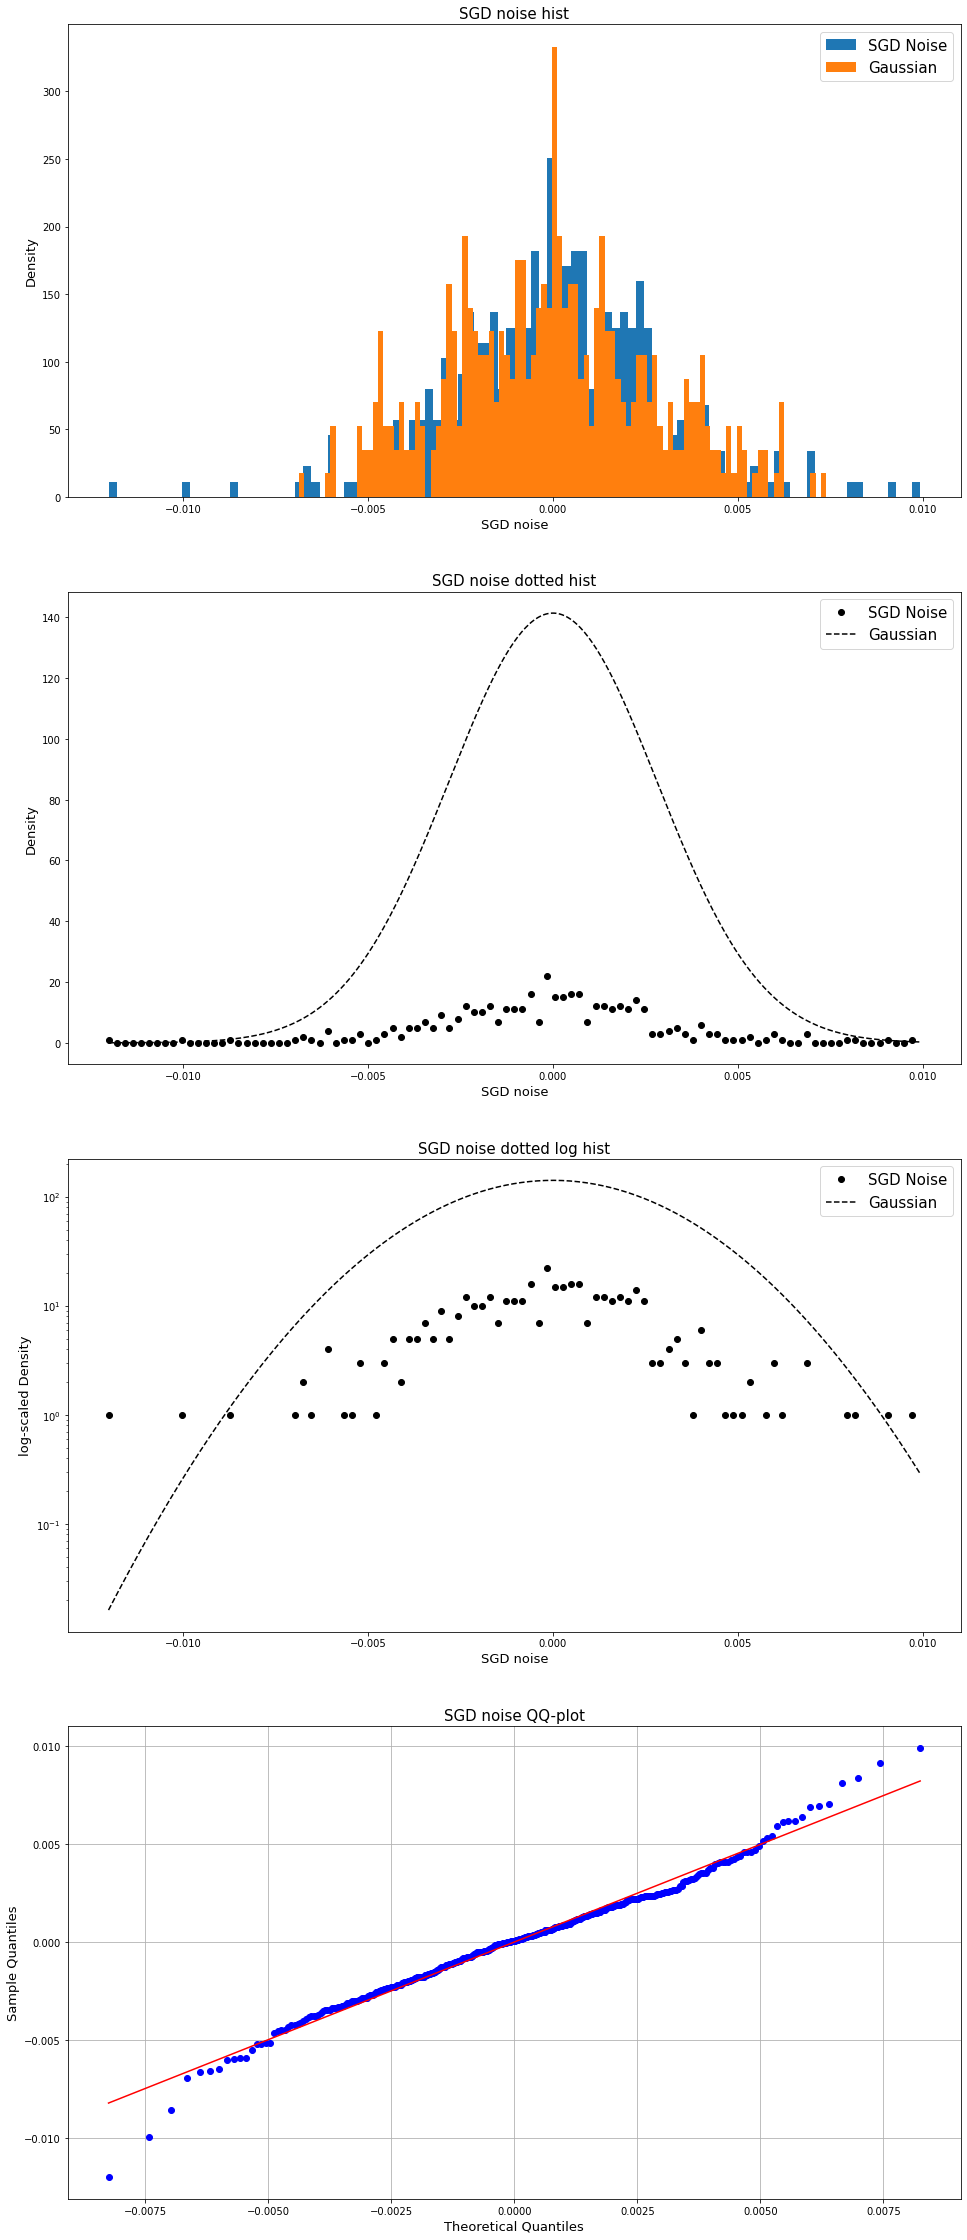

In [31]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[15][111], distribution=norm, dist_name='Gaussian', bins=100)

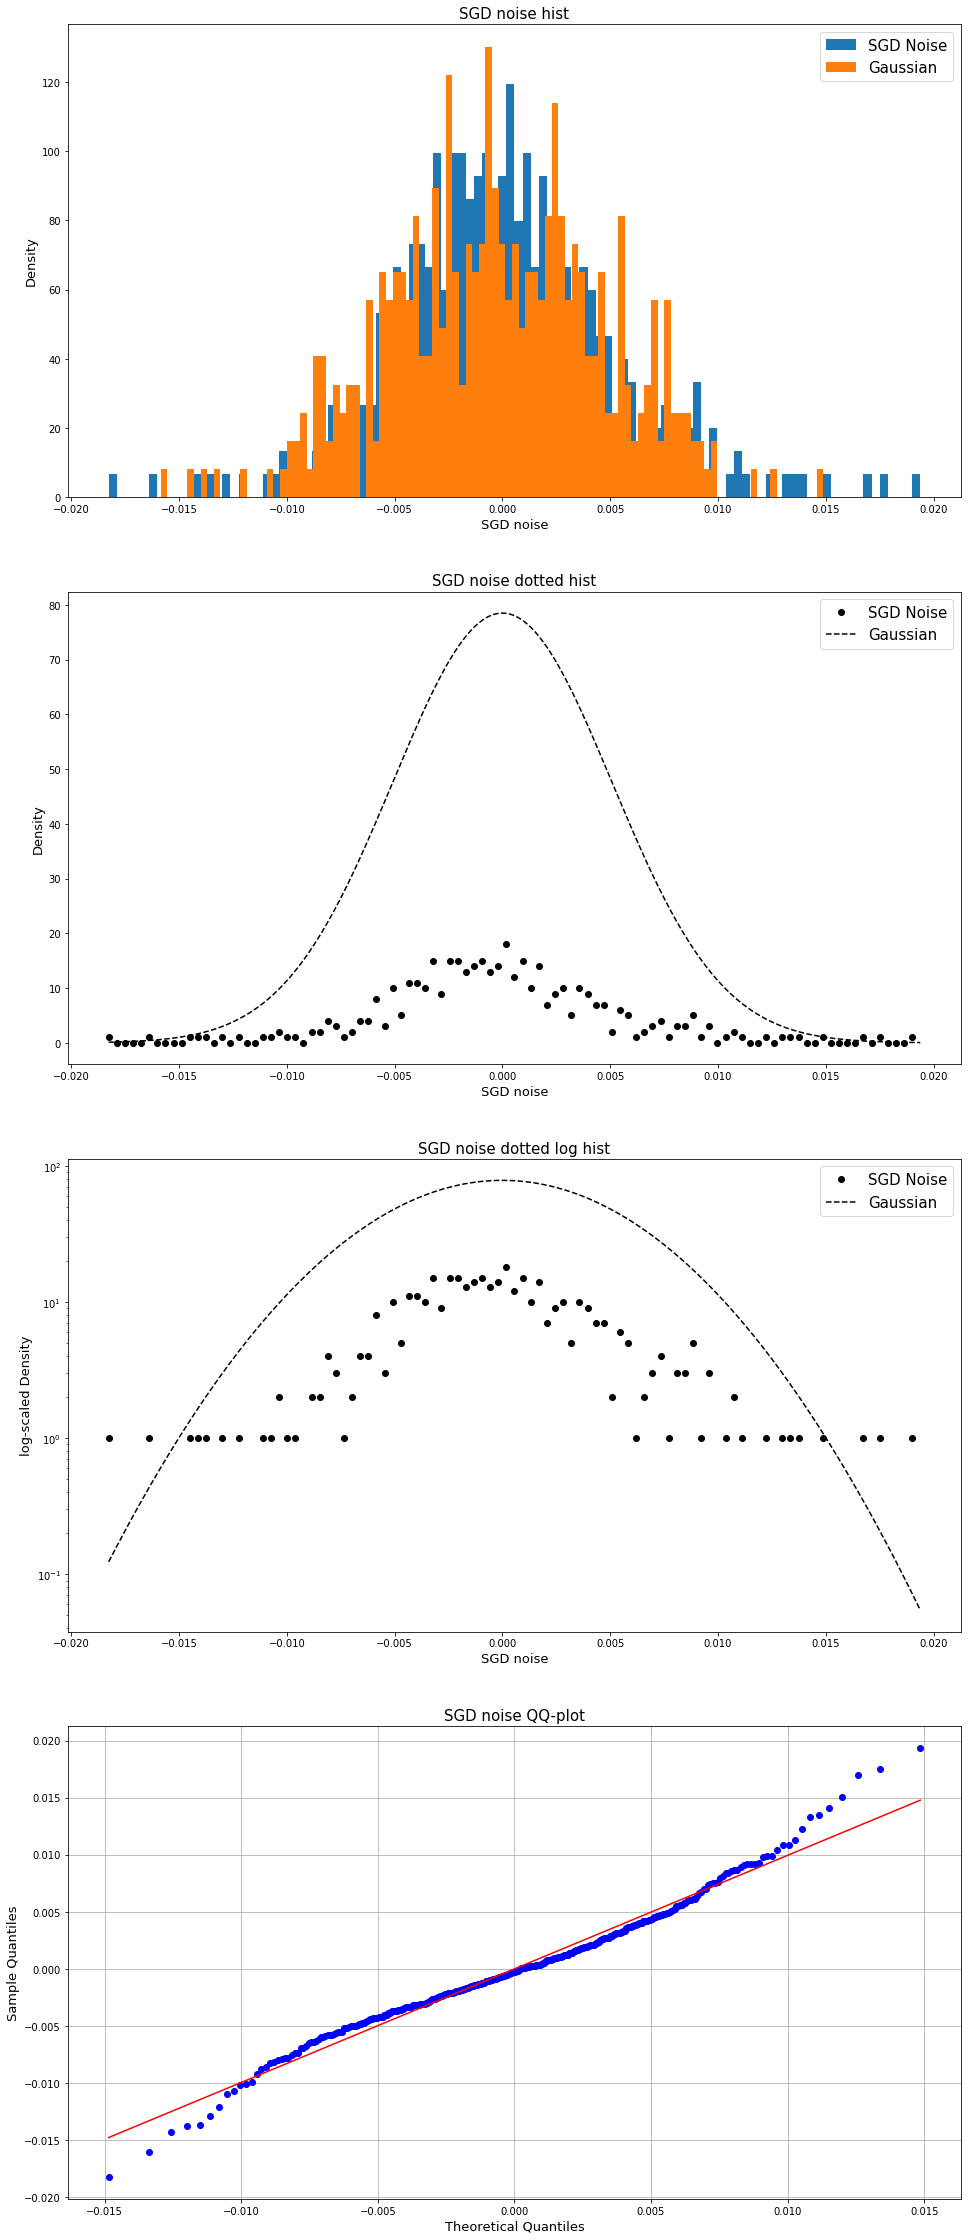

In [32]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[15][300], distribution=norm, dist_name='Gaussian', bins=100)

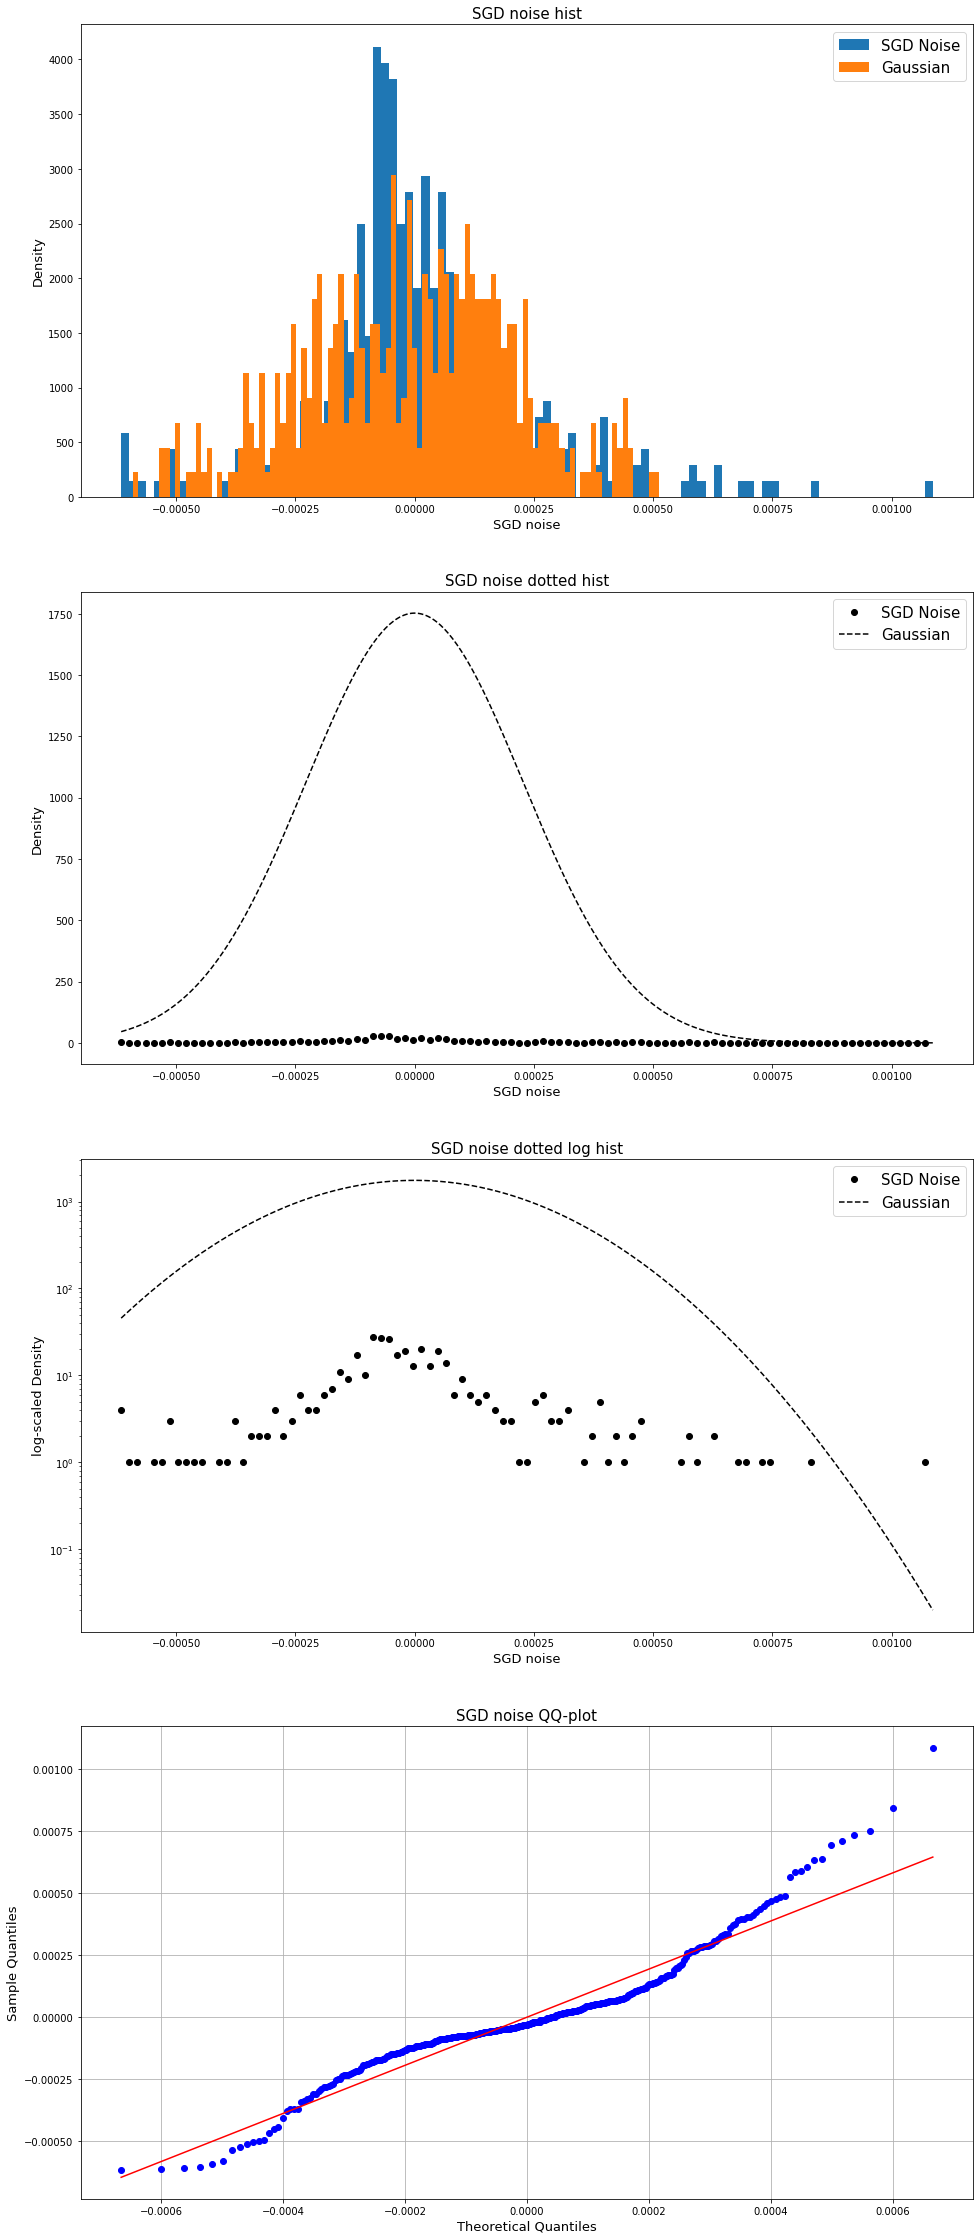

In [33]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[15][20000], distribution=norm, dist_name='Gaussian', bins=100)

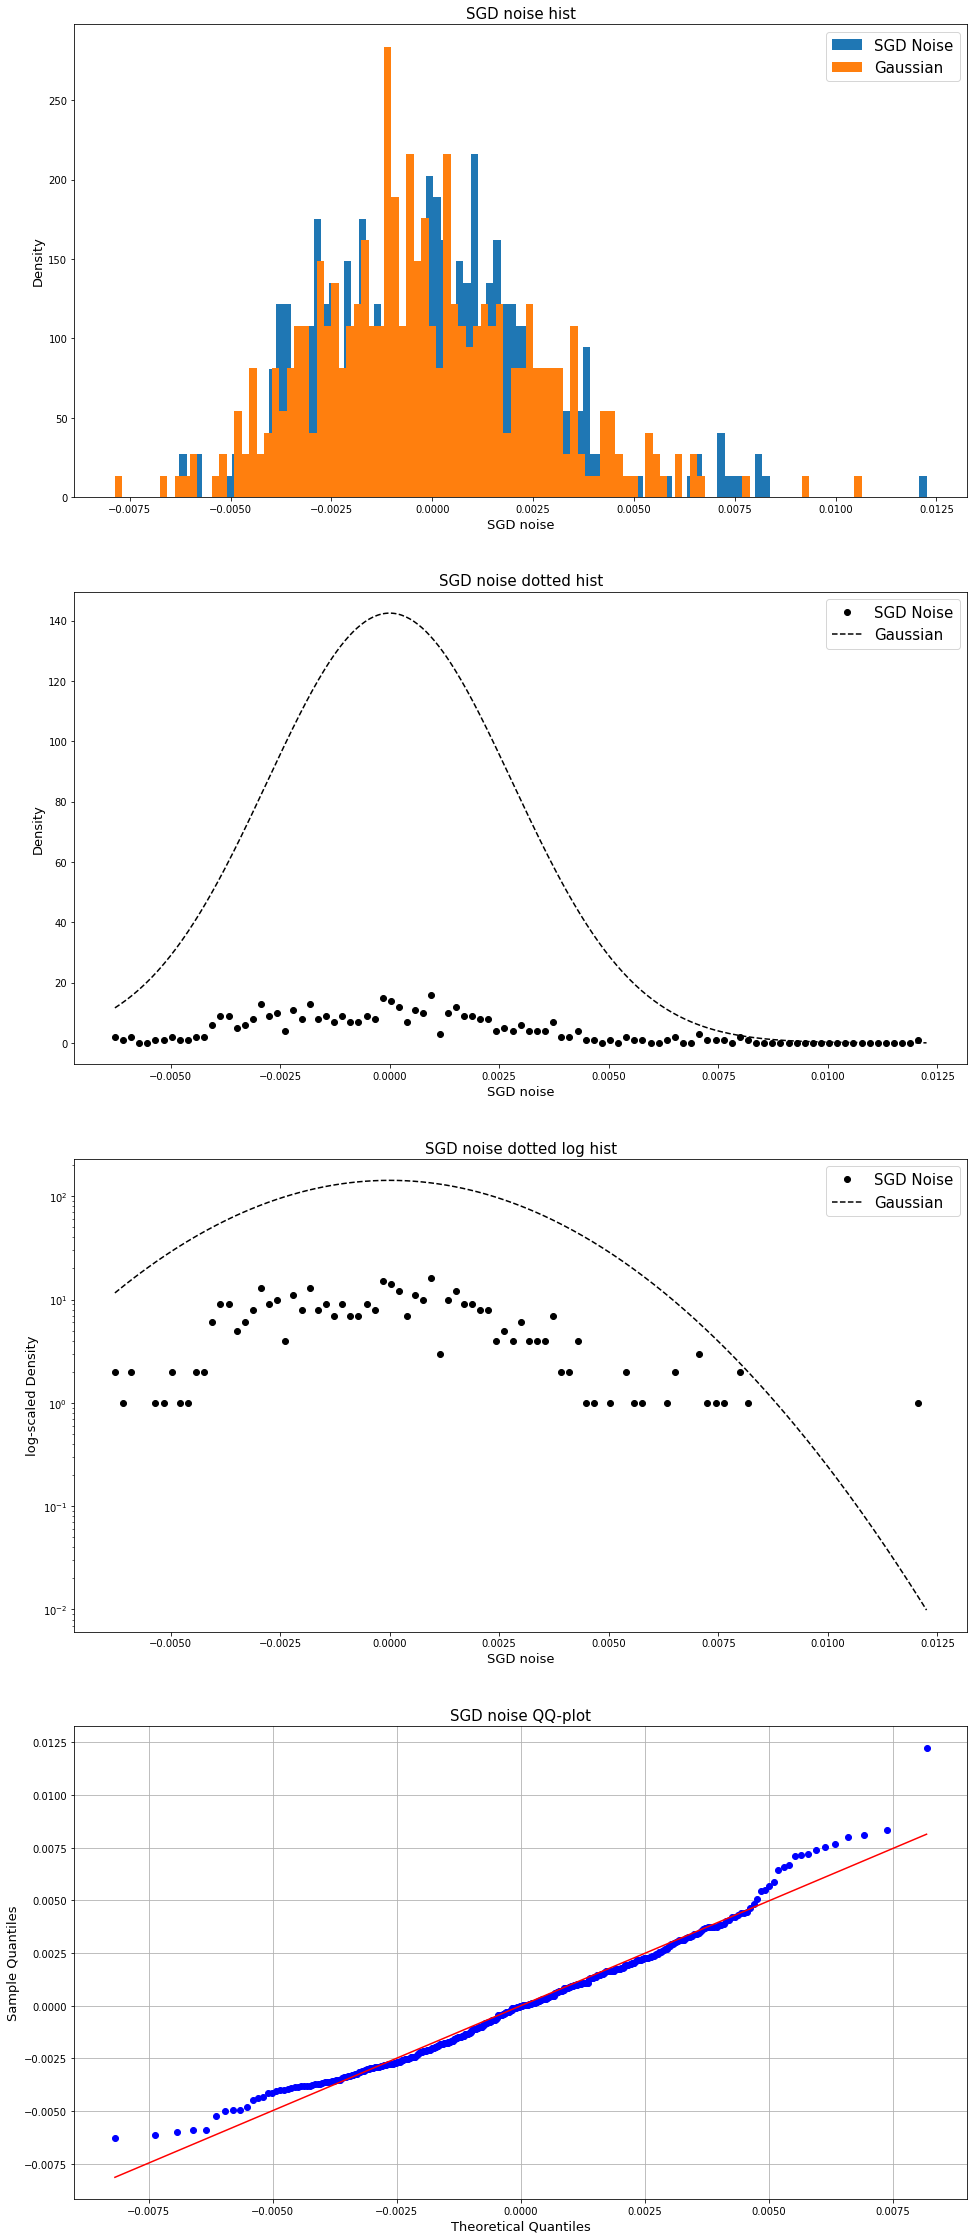

In [34]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[15][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #30

In [35]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[30].shape

(34414, 400)

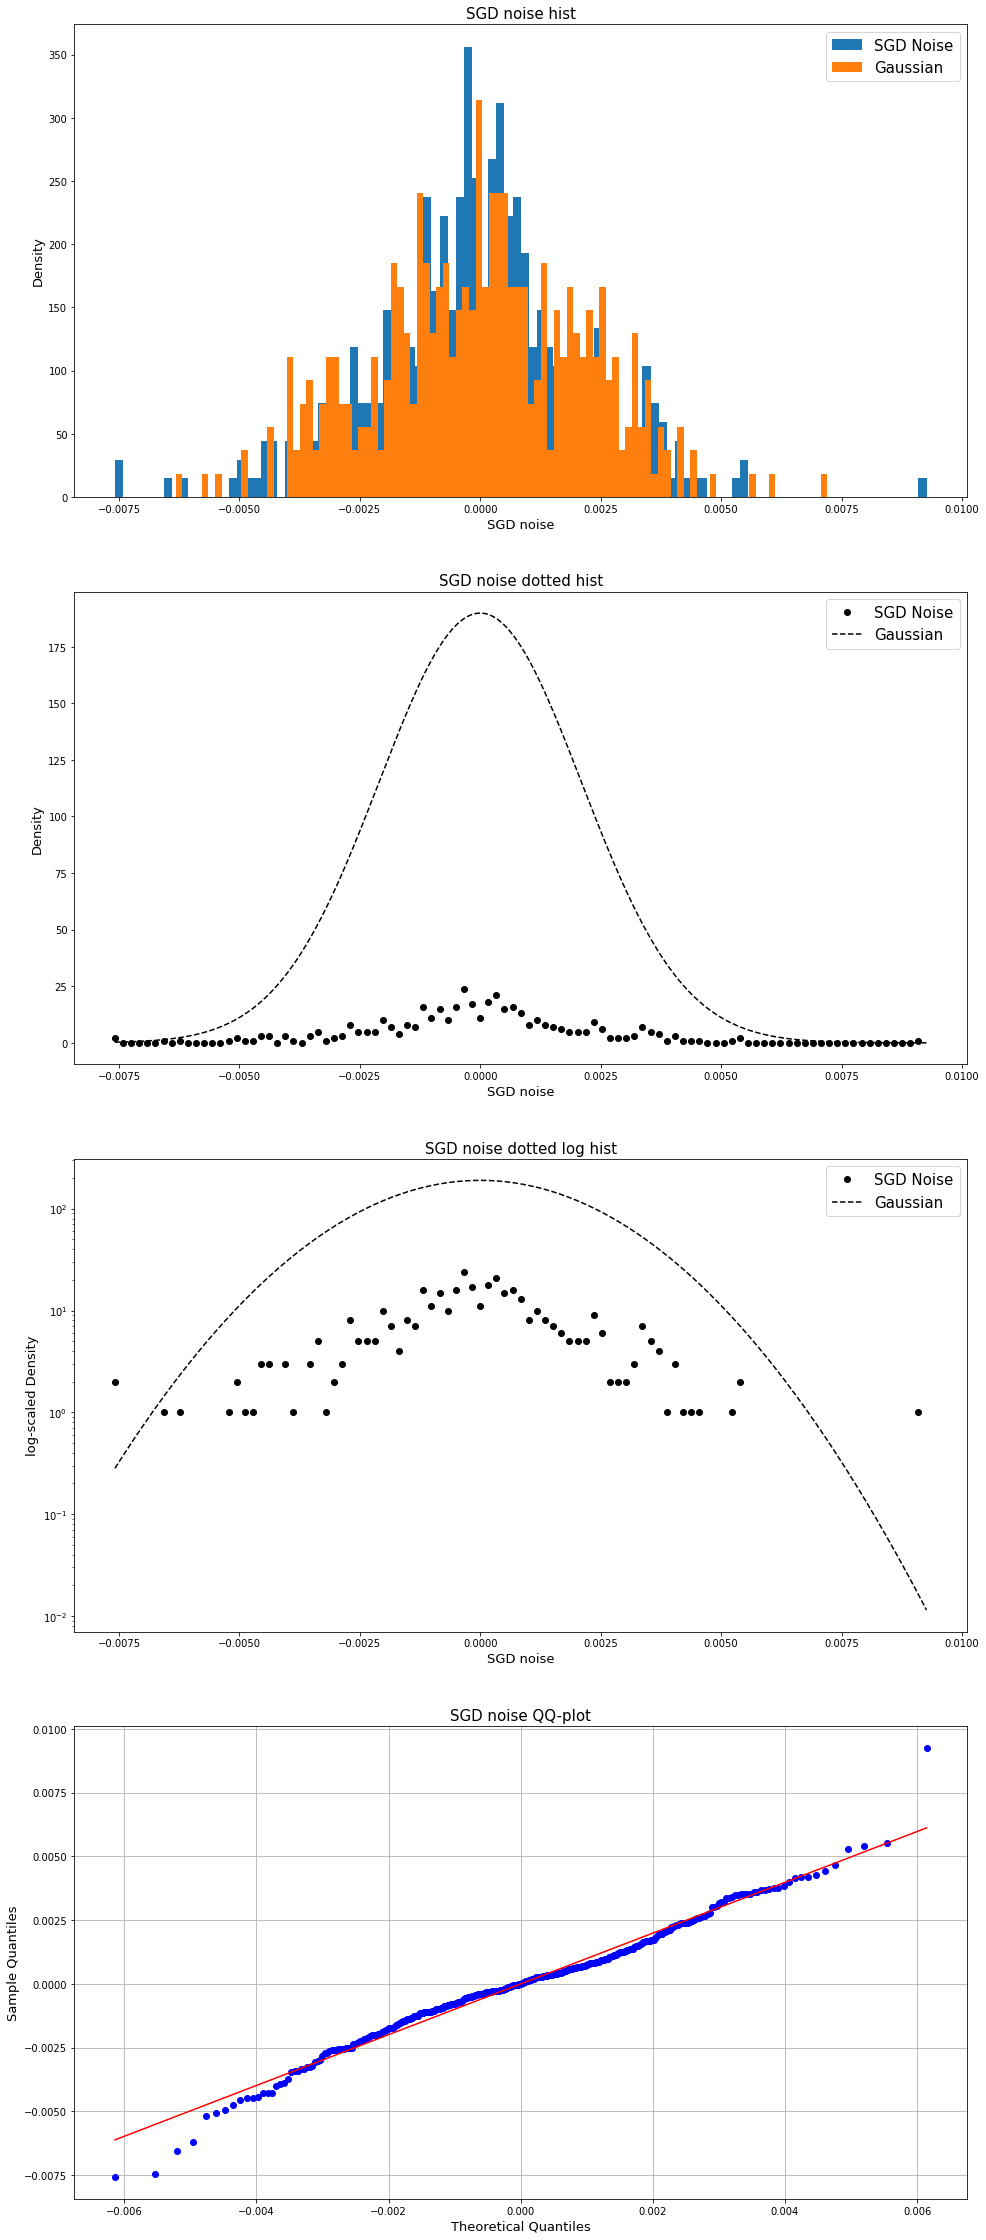

In [36]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[30][111], distribution=norm, dist_name='Gaussian', bins=100)

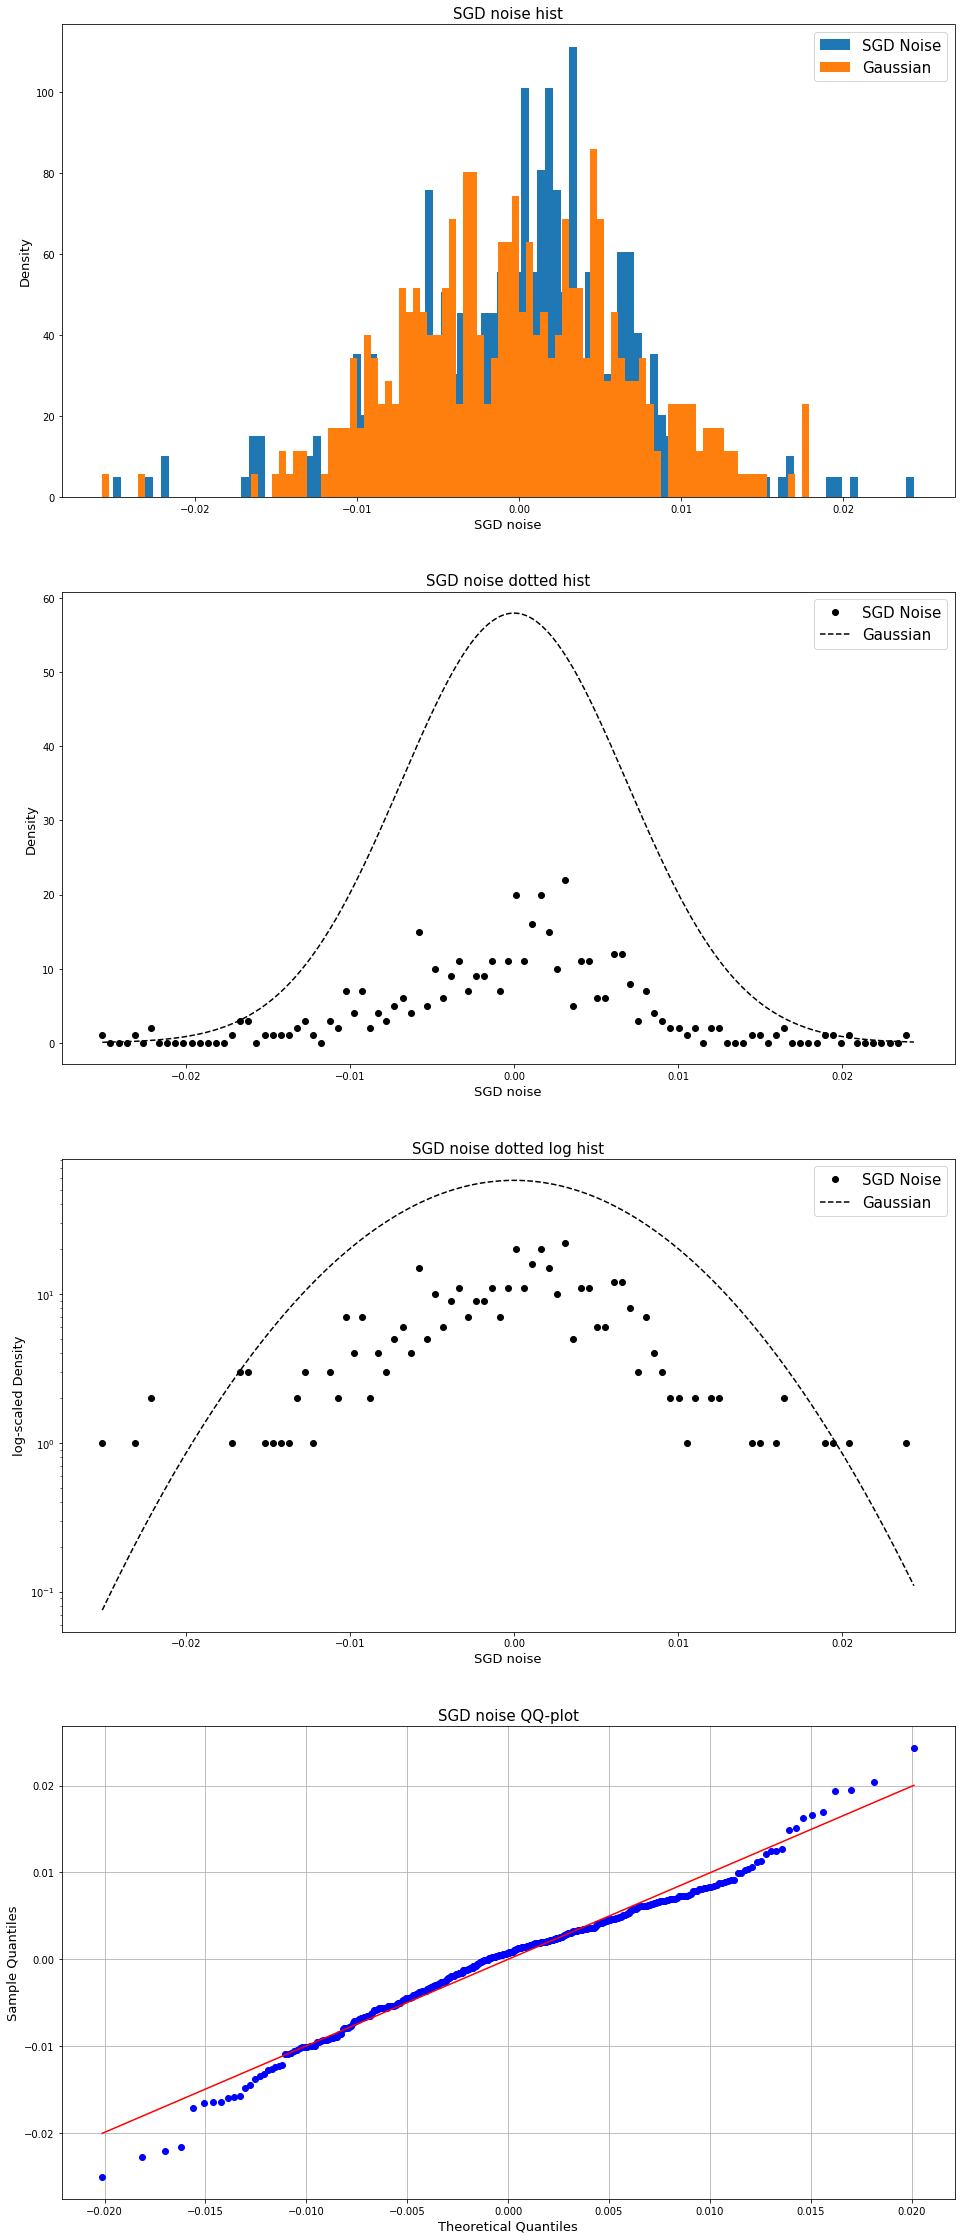

In [37]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[30][300], distribution=norm, dist_name='Gaussian', bins=100)

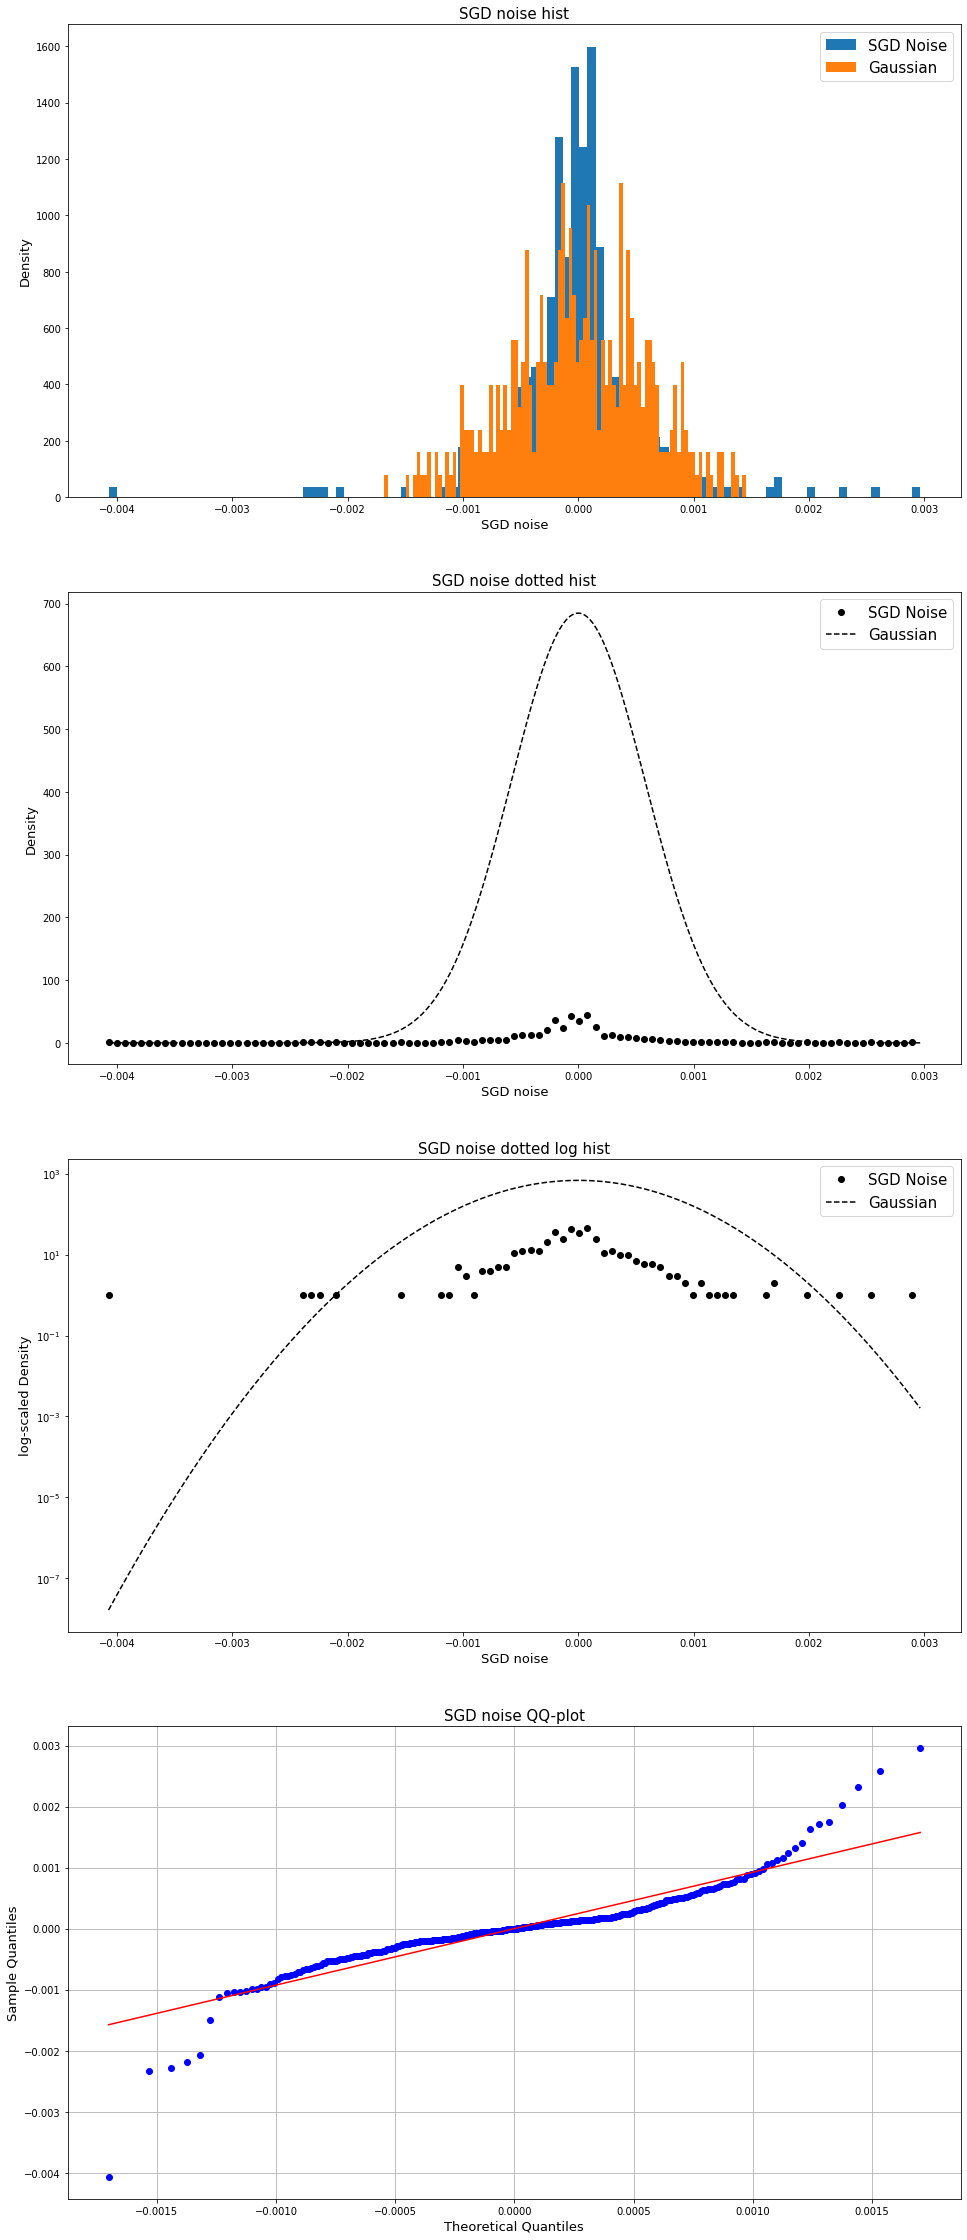

In [38]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[30][20000], distribution=norm, dist_name='Gaussian', bins=100)

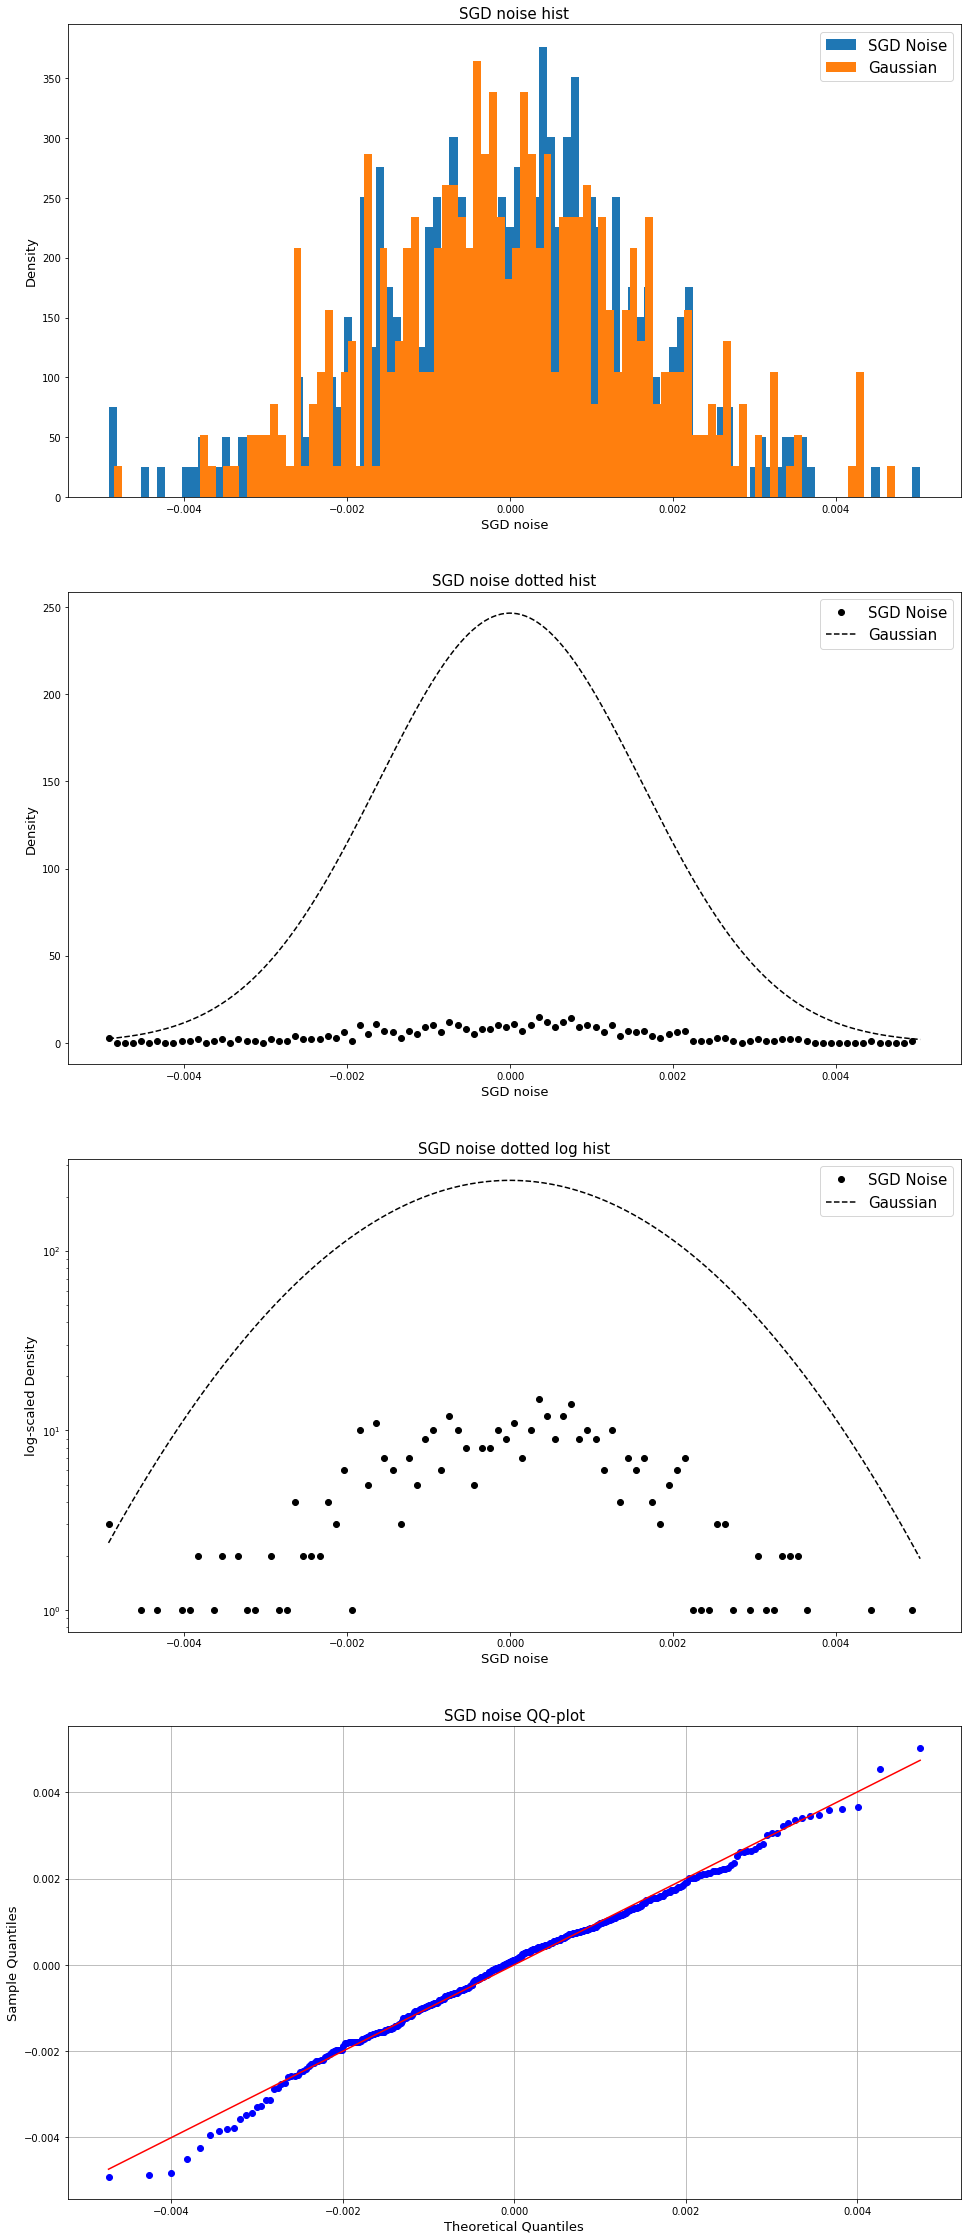

In [39]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[30][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #40

In [40]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[-1].shape

(34463, 400)

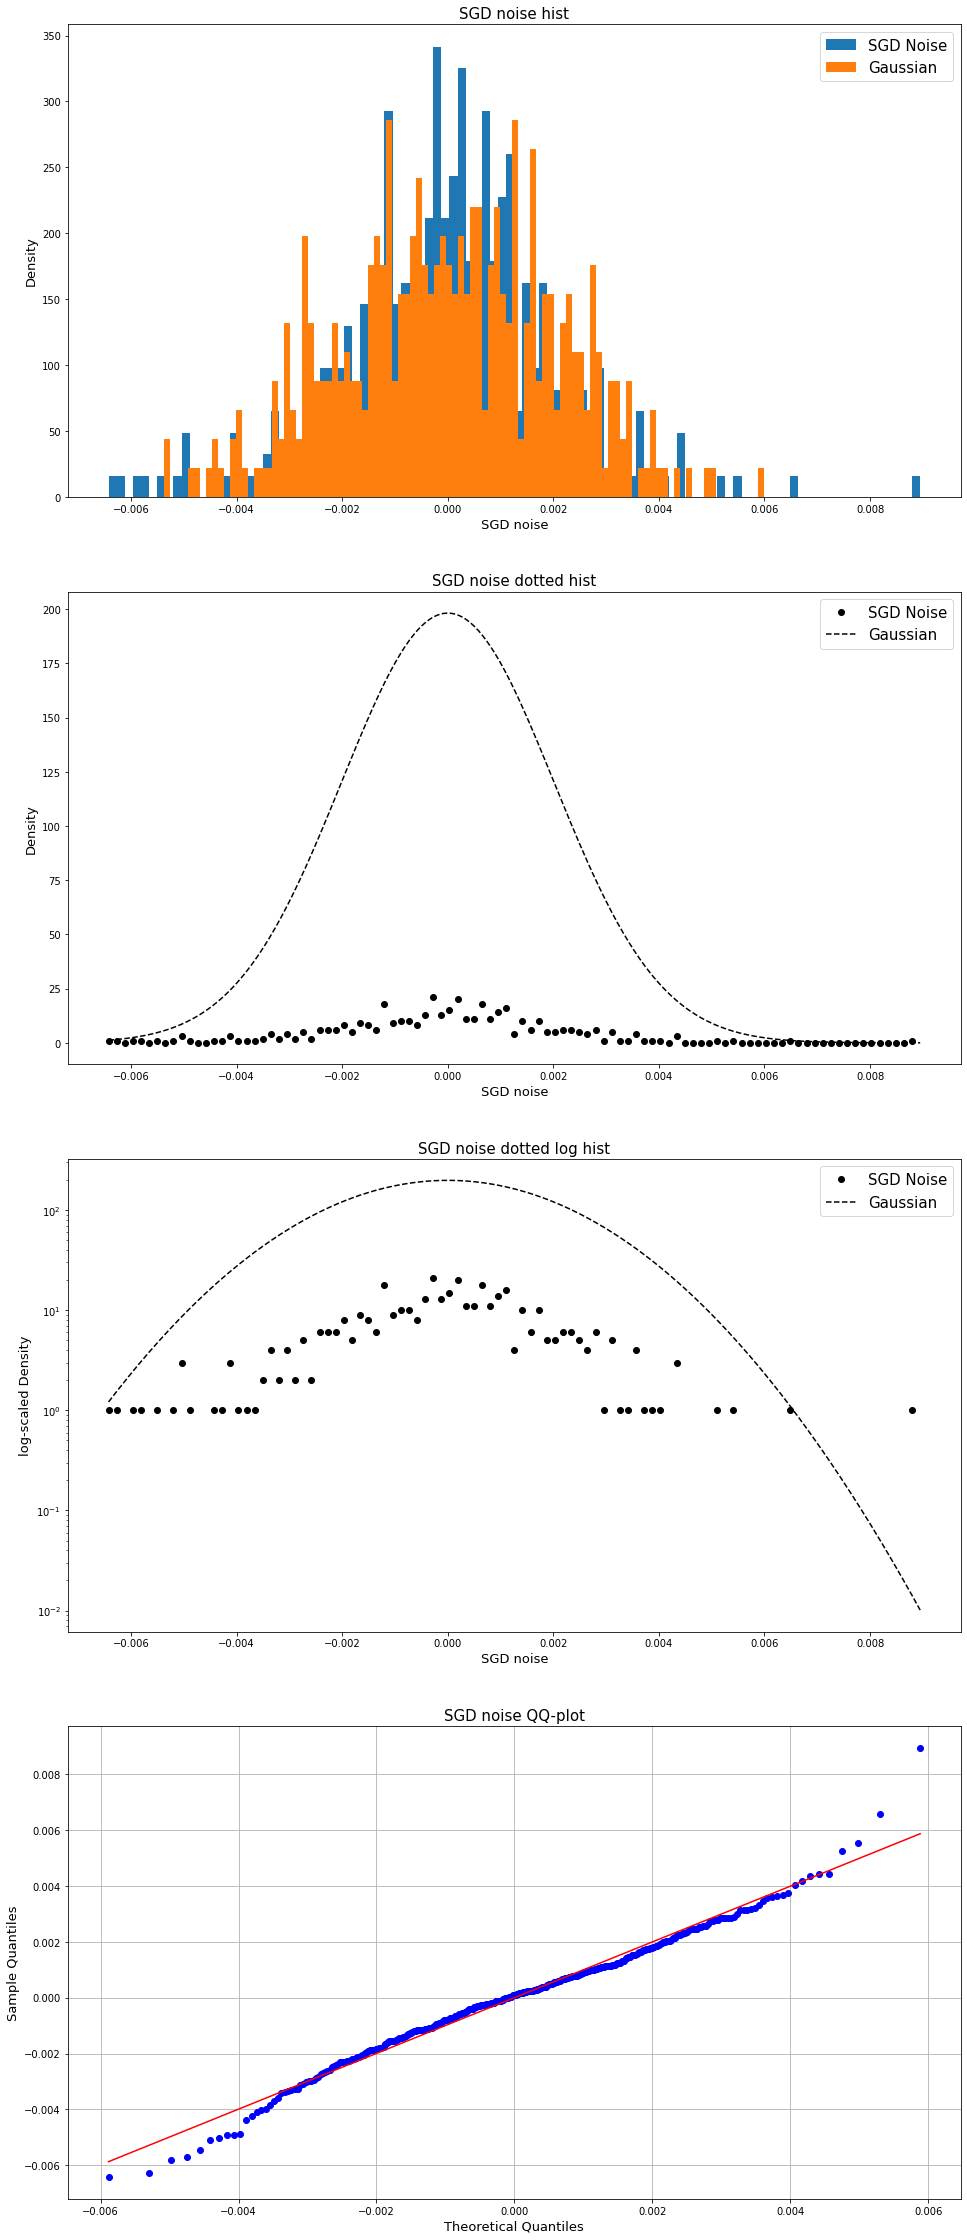

In [41]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[-1][111], distribution=norm, dist_name='Gaussian', bins=100)

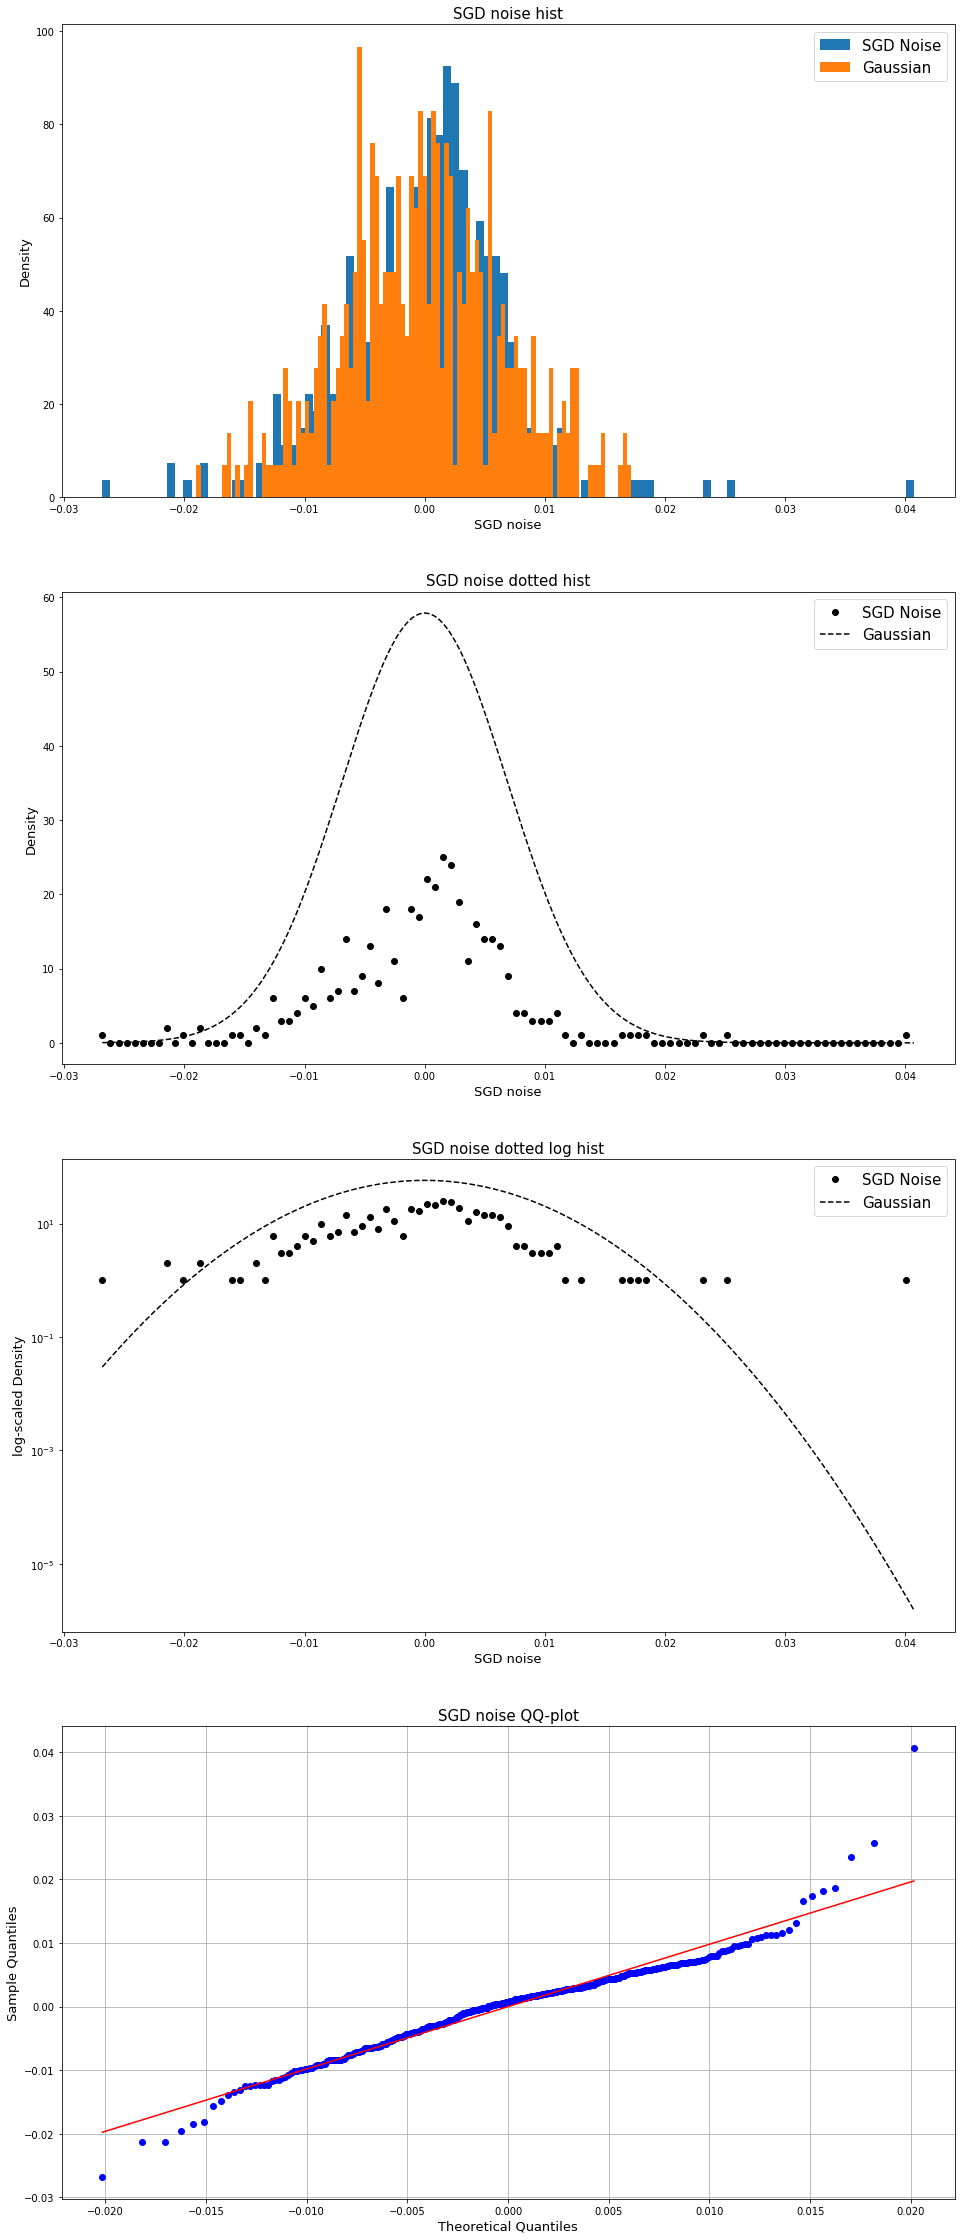

In [42]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[-1][300], distribution=norm, dist_name='Gaussian', bins=100)

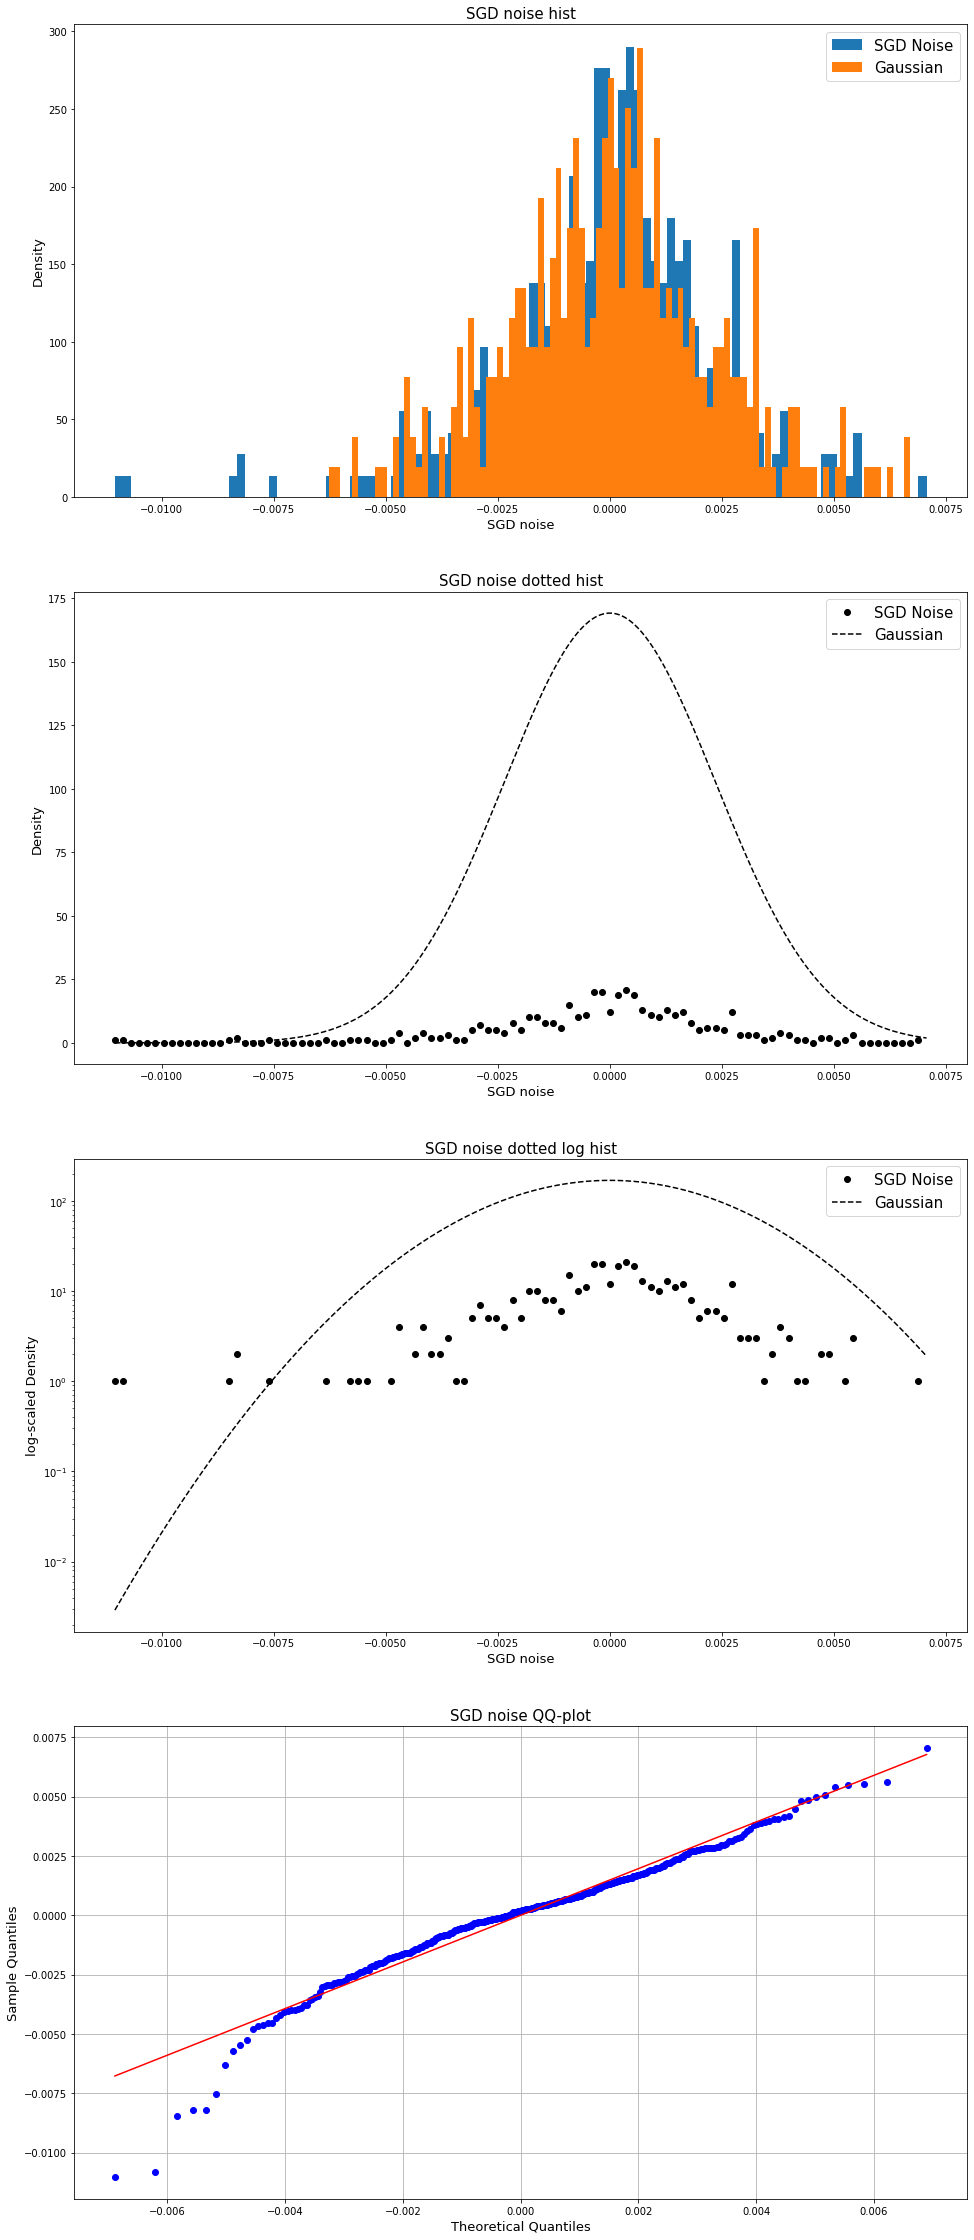

In [43]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[-1][20000], distribution=norm, dist_name='Gaussian', bins=100)

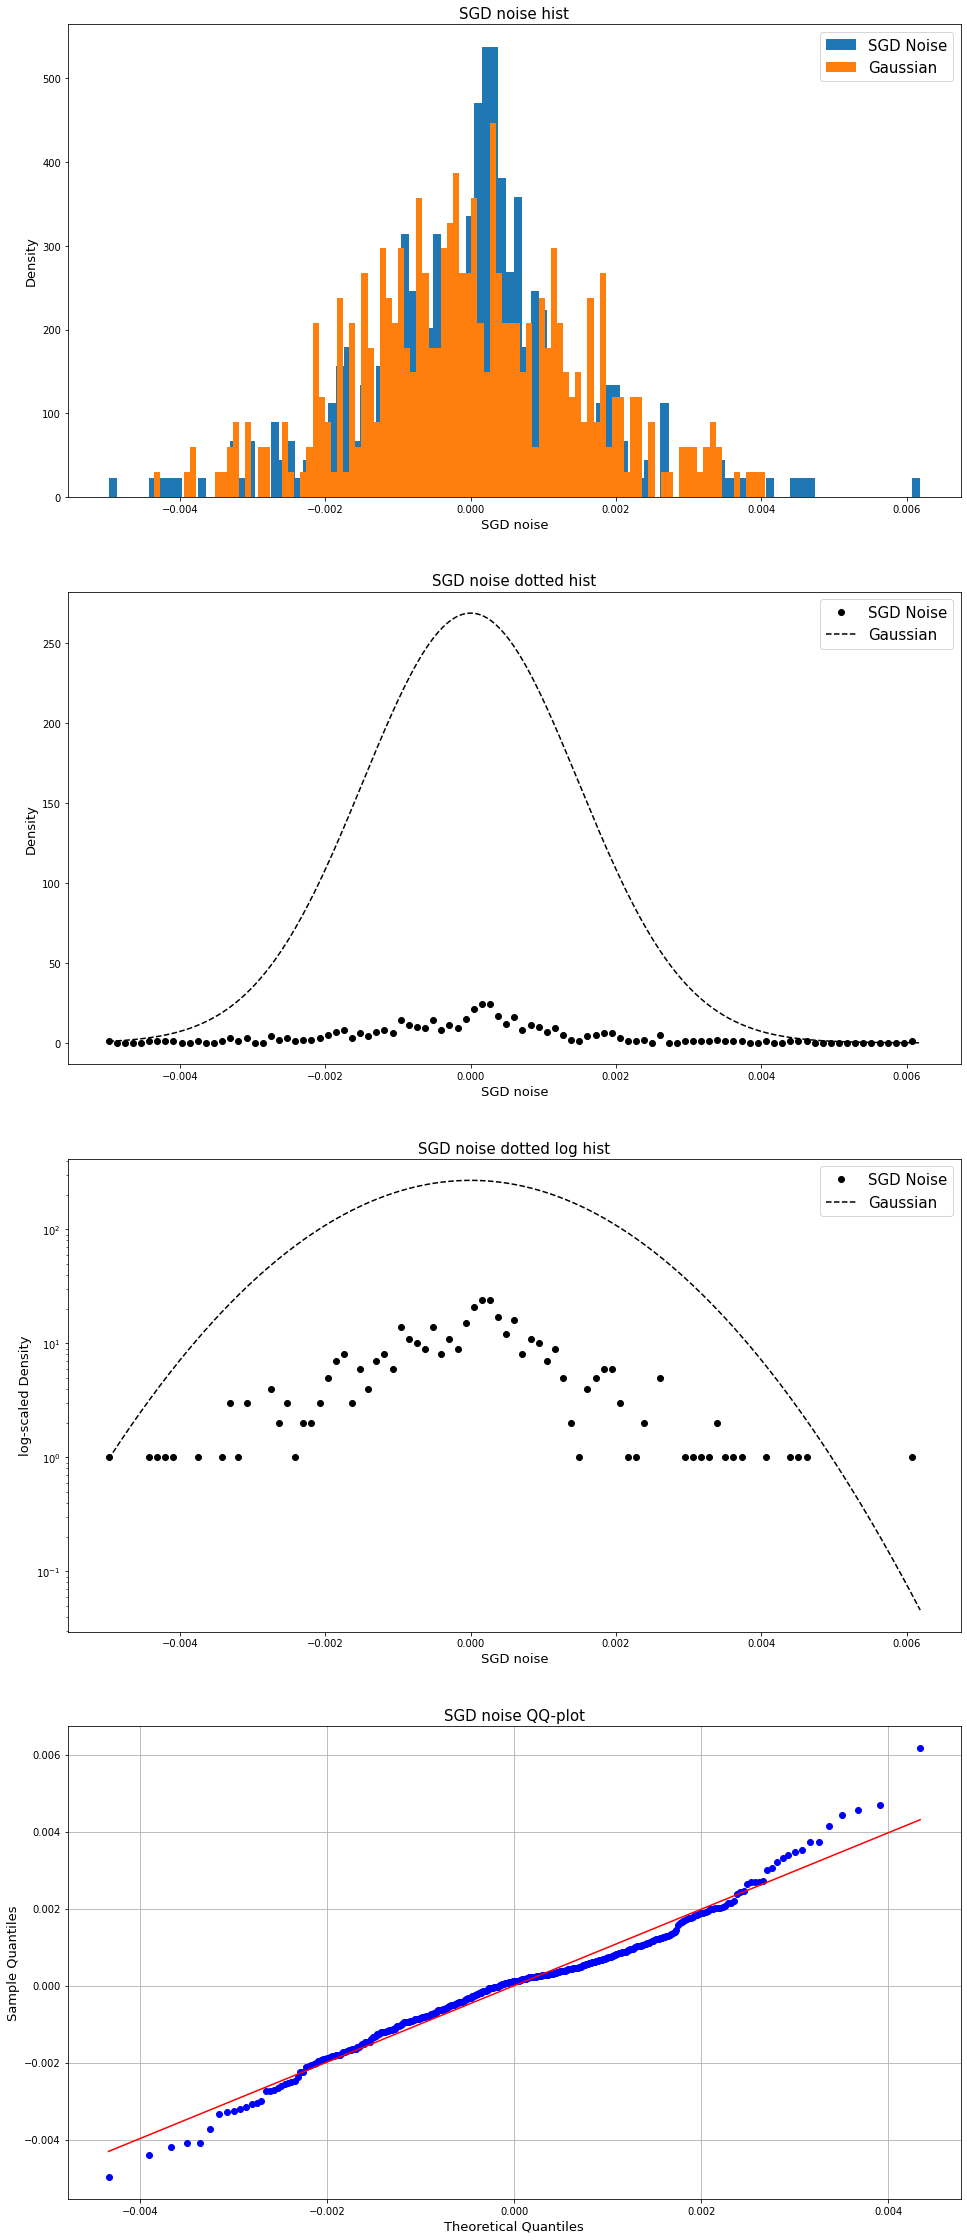

In [44]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[-1][-1], distribution=norm, dist_name='Gaussian', bins=100)

In [45]:
# 1200 gradients per batch for 89838 neurons in 15th epoch
sgn_storage[2].shape

(27952, 400)

# Batch size=200

In [46]:
Lenetcnn = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                   
                    nn.Flatten(),
                    nn.Linear(400,84),
                    nn.ReLU(),
                    nn.Linear(84,10),
                    nn.Softmax())

In [47]:
batch_size = 200
lr = 1e-1
epochs = 10
log_iter=100

#30 iterations
total_iterations=epochs*(60000/batch_size)/log_iter
print('total iterations',total_iterations)

total iterations 30.0


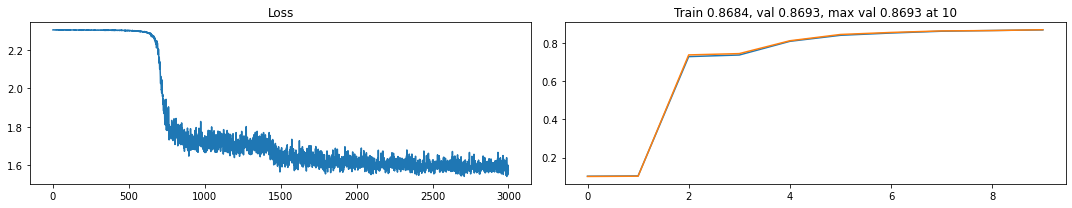

100%|██████████| 10/10 [06:56<00:00, 41.60s/it]


In [48]:
set_random_seeds(device=device)
batch_size=200
#your file path where save gradients
#can be your local path ir google drive path
filepath = 'exp_ml/grads_batch_200'

#in case of google drive
#filepath='/content/gdrive/MyDrive/Gradient_exp/grads_batch_100'

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=2)


#model = FullyConnected(input_dim=28*28, width=width, depth=depth, num_classes=10)
model=Lenetcnn
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


mini_batch_150_model = train(model, optimizer, loss_function,
                             train_loader, val_loader,
                             device, filepath=filepath, epochs=epochs,
                             log_iter=100)

# Alpha disrtibution

In [49]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches
batchsize=200
N = int(60000/200)
alphas = []
sgn_storage = []
filepath = 'exp_ml/grads_batch_200'


for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
    sgn_storage.append(sgn)
    del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn_storage[-1]))
    print(sgn_storage[-1].shape)
    

  3%|▎         | 1/29 [00:13<06:09, 13.20s/it]

(31019, 300)


  7%|▋         | 2/29 [00:26<05:53, 13.10s/it]

(30603, 300)


 10%|█         | 3/29 [00:39<05:42, 13.19s/it]

(31195, 300)


 14%|█▍        | 4/29 [00:53<05:36, 13.46s/it]

(31408, 300)


 17%|█▋        | 5/29 [01:07<05:25, 13.56s/it]

(31846, 300)


 21%|██        | 6/29 [01:21<05:14, 13.67s/it]

(32223, 300)


 24%|██▍       | 7/29 [01:35<05:04, 13.82s/it]

(32526, 300)


 28%|██▊       | 8/29 [01:50<04:54, 14.04s/it]

(33927, 300)


 31%|███       | 9/29 [02:04<04:43, 14.18s/it]

(34030, 300)


 34%|███▍      | 10/29 [02:19<04:32, 14.33s/it]

(34087, 300)


 38%|███▊      | 11/29 [02:34<04:20, 14.48s/it]

(34122, 300)


 41%|████▏     | 12/29 [02:48<04:07, 14.55s/it]

(34207, 300)


 45%|████▍     | 13/29 [03:03<03:53, 14.61s/it]

(34202, 300)


 48%|████▊     | 14/29 [03:18<03:40, 14.67s/it]

(34220, 300)


 52%|█████▏    | 15/29 [03:33<03:26, 14.73s/it]

(34243, 300)


 55%|█████▌    | 16/29 [03:47<03:10, 14.68s/it]

(34269, 300)


 59%|█████▊    | 17/29 [04:02<02:55, 14.61s/it]

(34289, 300)


 62%|██████▏   | 18/29 [04:16<02:40, 14.57s/it]

(34332, 300)


 66%|██████▌   | 19/29 [04:31<02:25, 14.51s/it]

(34344, 300)


 69%|██████▉   | 20/29 [04:45<02:11, 14.58s/it]

(34370, 300)


 72%|███████▏  | 21/29 [05:00<01:56, 14.58s/it]

(34393, 300)


 76%|███████▌  | 22/29 [05:14<01:41, 14.57s/it]

(34391, 300)


 79%|███████▉  | 23/29 [05:29<01:27, 14.53s/it]

(34405, 300)


 83%|████████▎ | 24/29 [05:44<01:13, 14.62s/it]

(34407, 300)


 86%|████████▌ | 25/29 [05:58<00:58, 14.59s/it]

(34428, 300)


 90%|████████▉ | 26/29 [06:13<00:43, 14.61s/it]

(34448, 300)


 93%|█████████▎| 27/29 [06:27<00:29, 14.57s/it]

(34442, 300)


 97%|█████████▋| 28/29 [06:42<00:14, 14.61s/it]

(34454, 300)


100%|██████████| 29/29 [06:57<00:00, 14.38s/it]

(34457, 300)


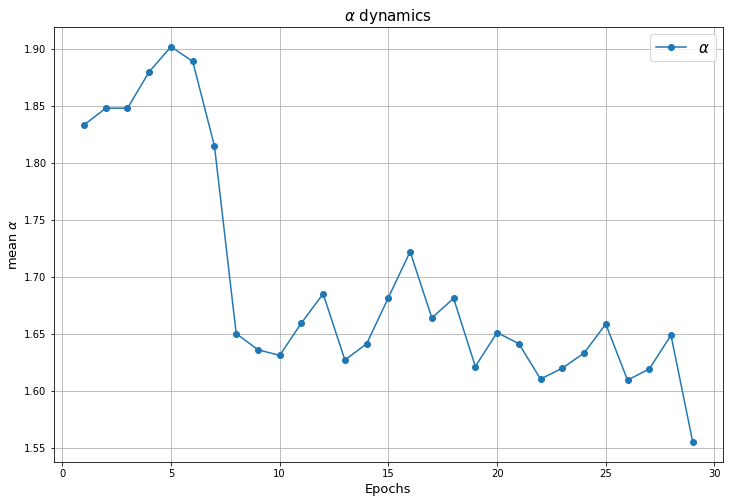

In [50]:
mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [itera for itera in range(1, int(total_iterations), 1)])

# SGN for batch size 200

In [51]:
#Iteration 0

In [52]:
# amount of epochs
len(sgn_storage)

29

In [53]:
# 1200 gradients per batch for 89911 neurons in 5th epoch
sgn_storage[0].shape

(31019, 300)

# Conv1

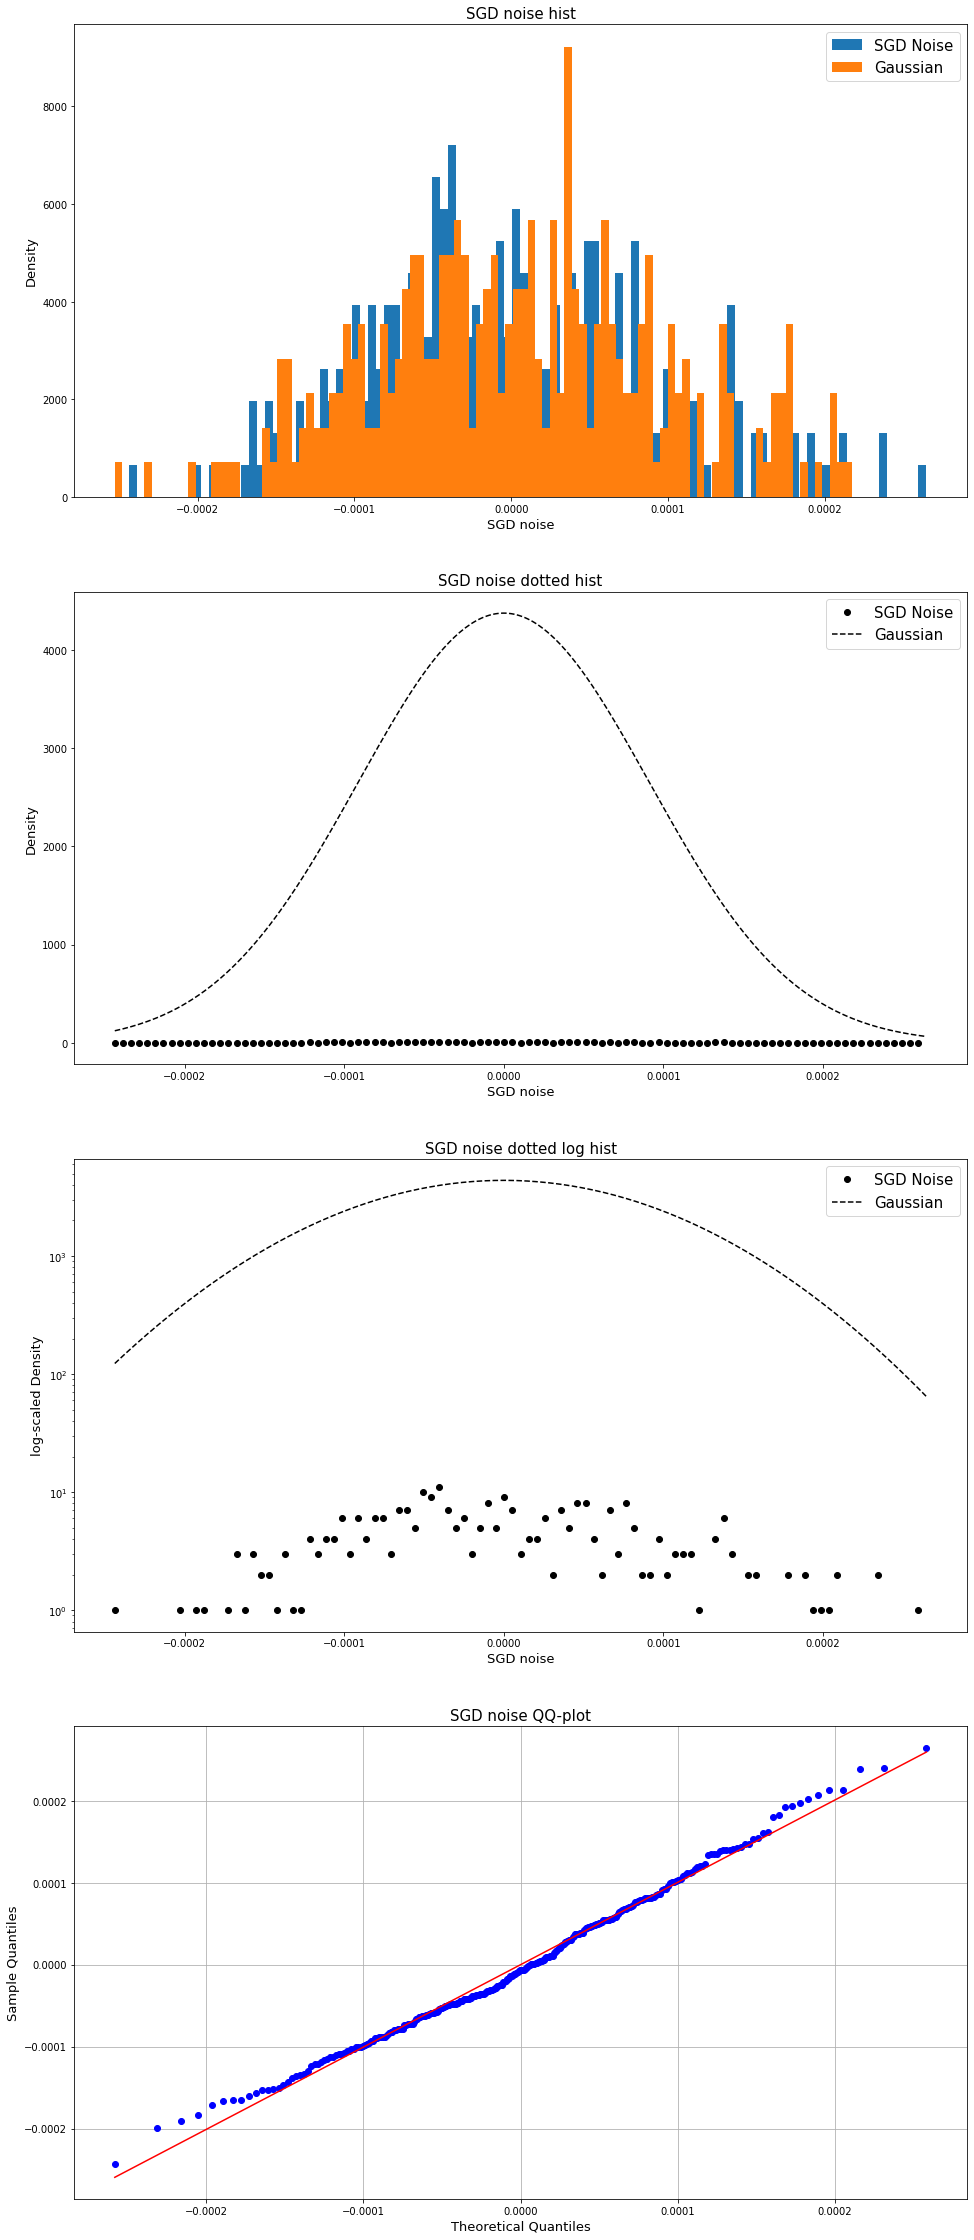

In [54]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][111], distribution=norm, dist_name='Gaussian', bins=100)

# Conv2

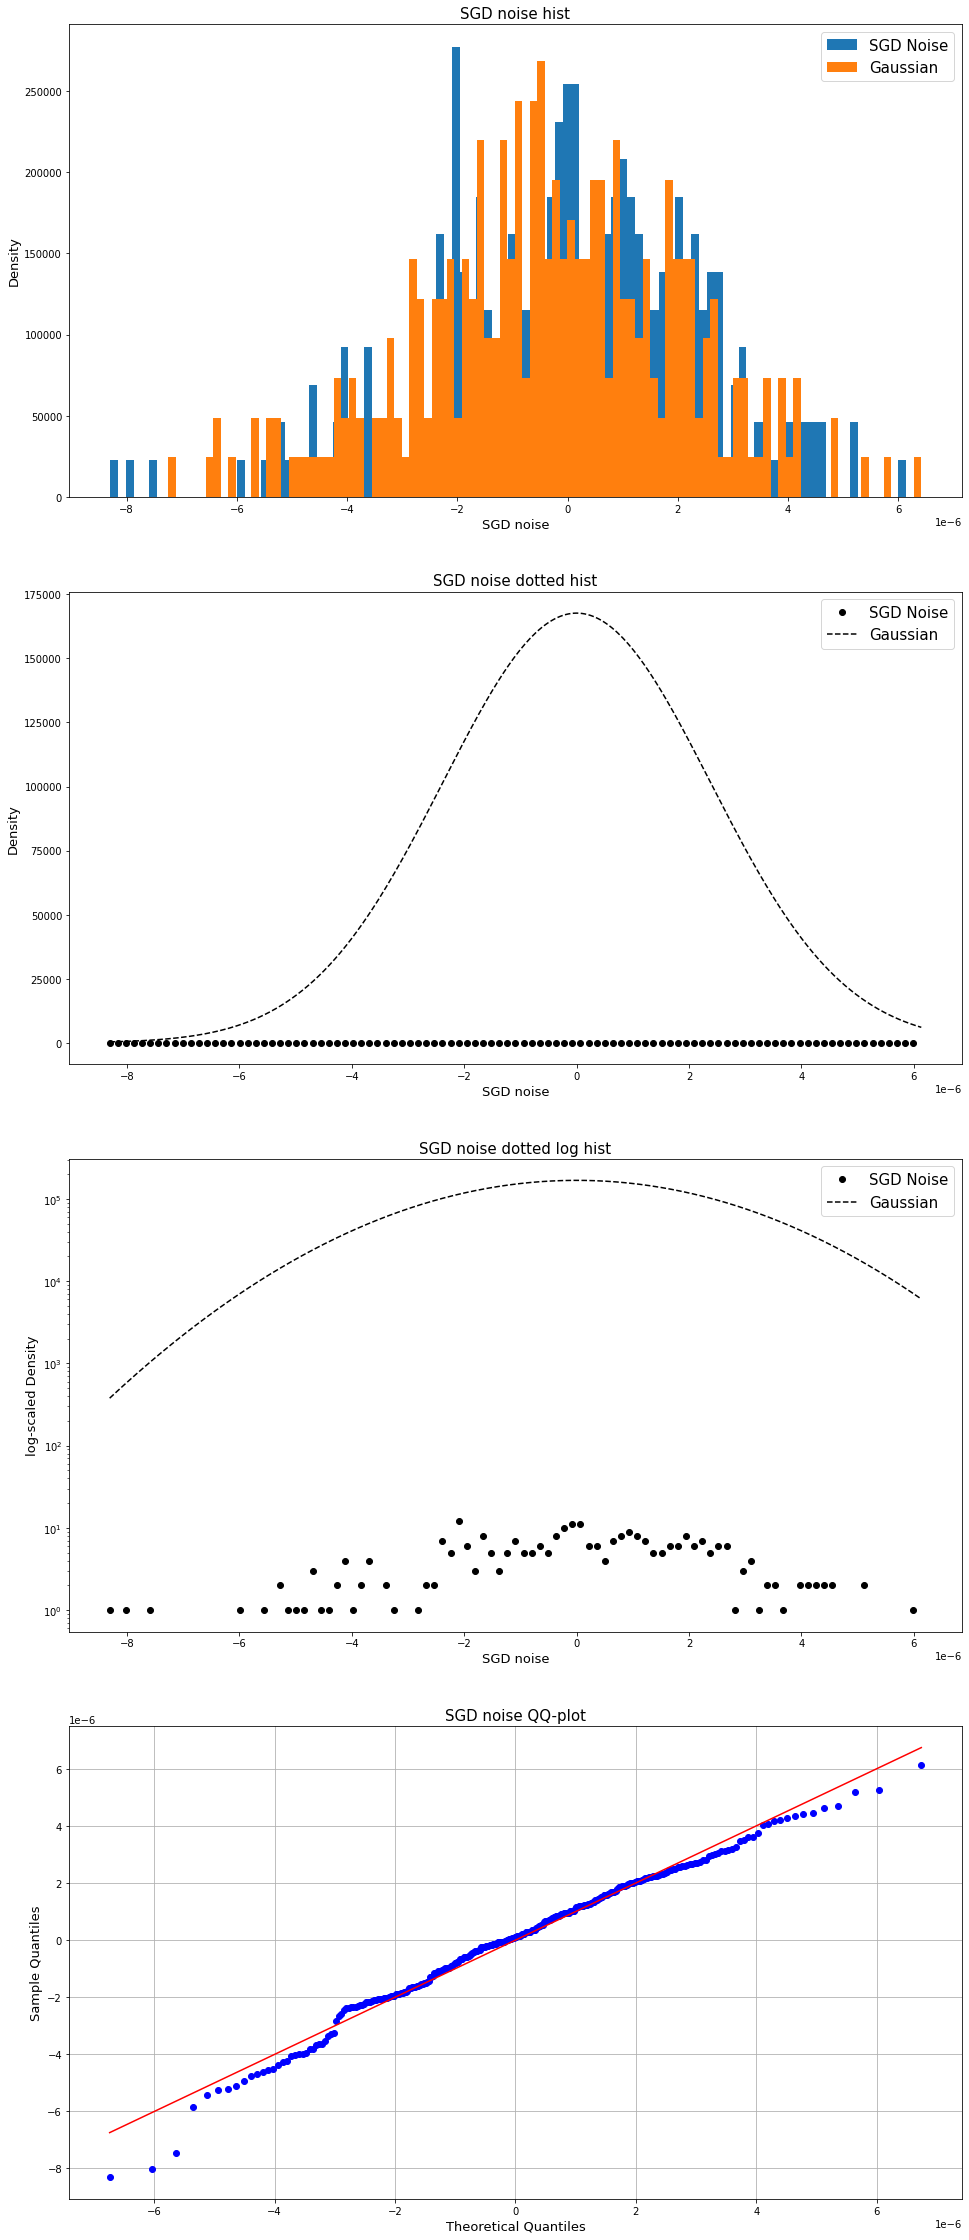

In [55]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][300], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 1

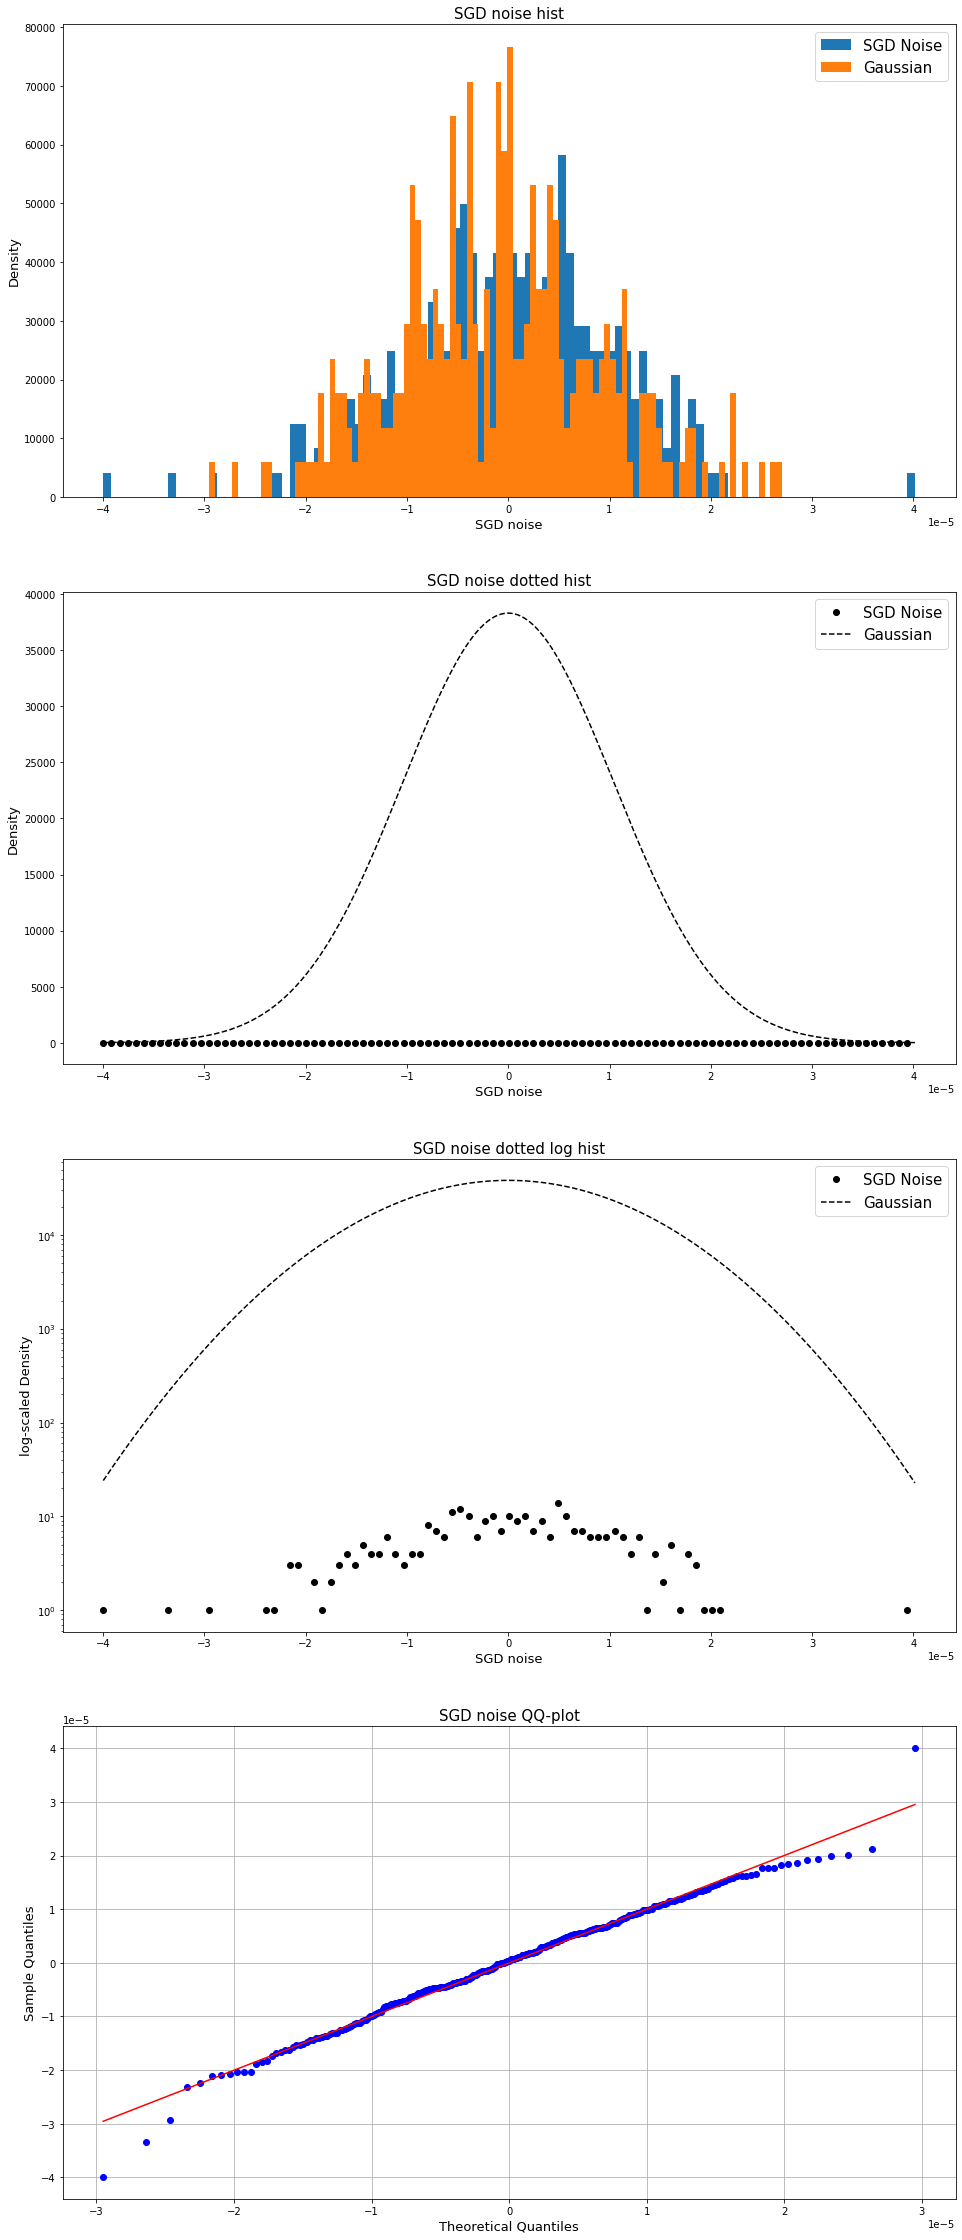

In [56]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][20000], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 2

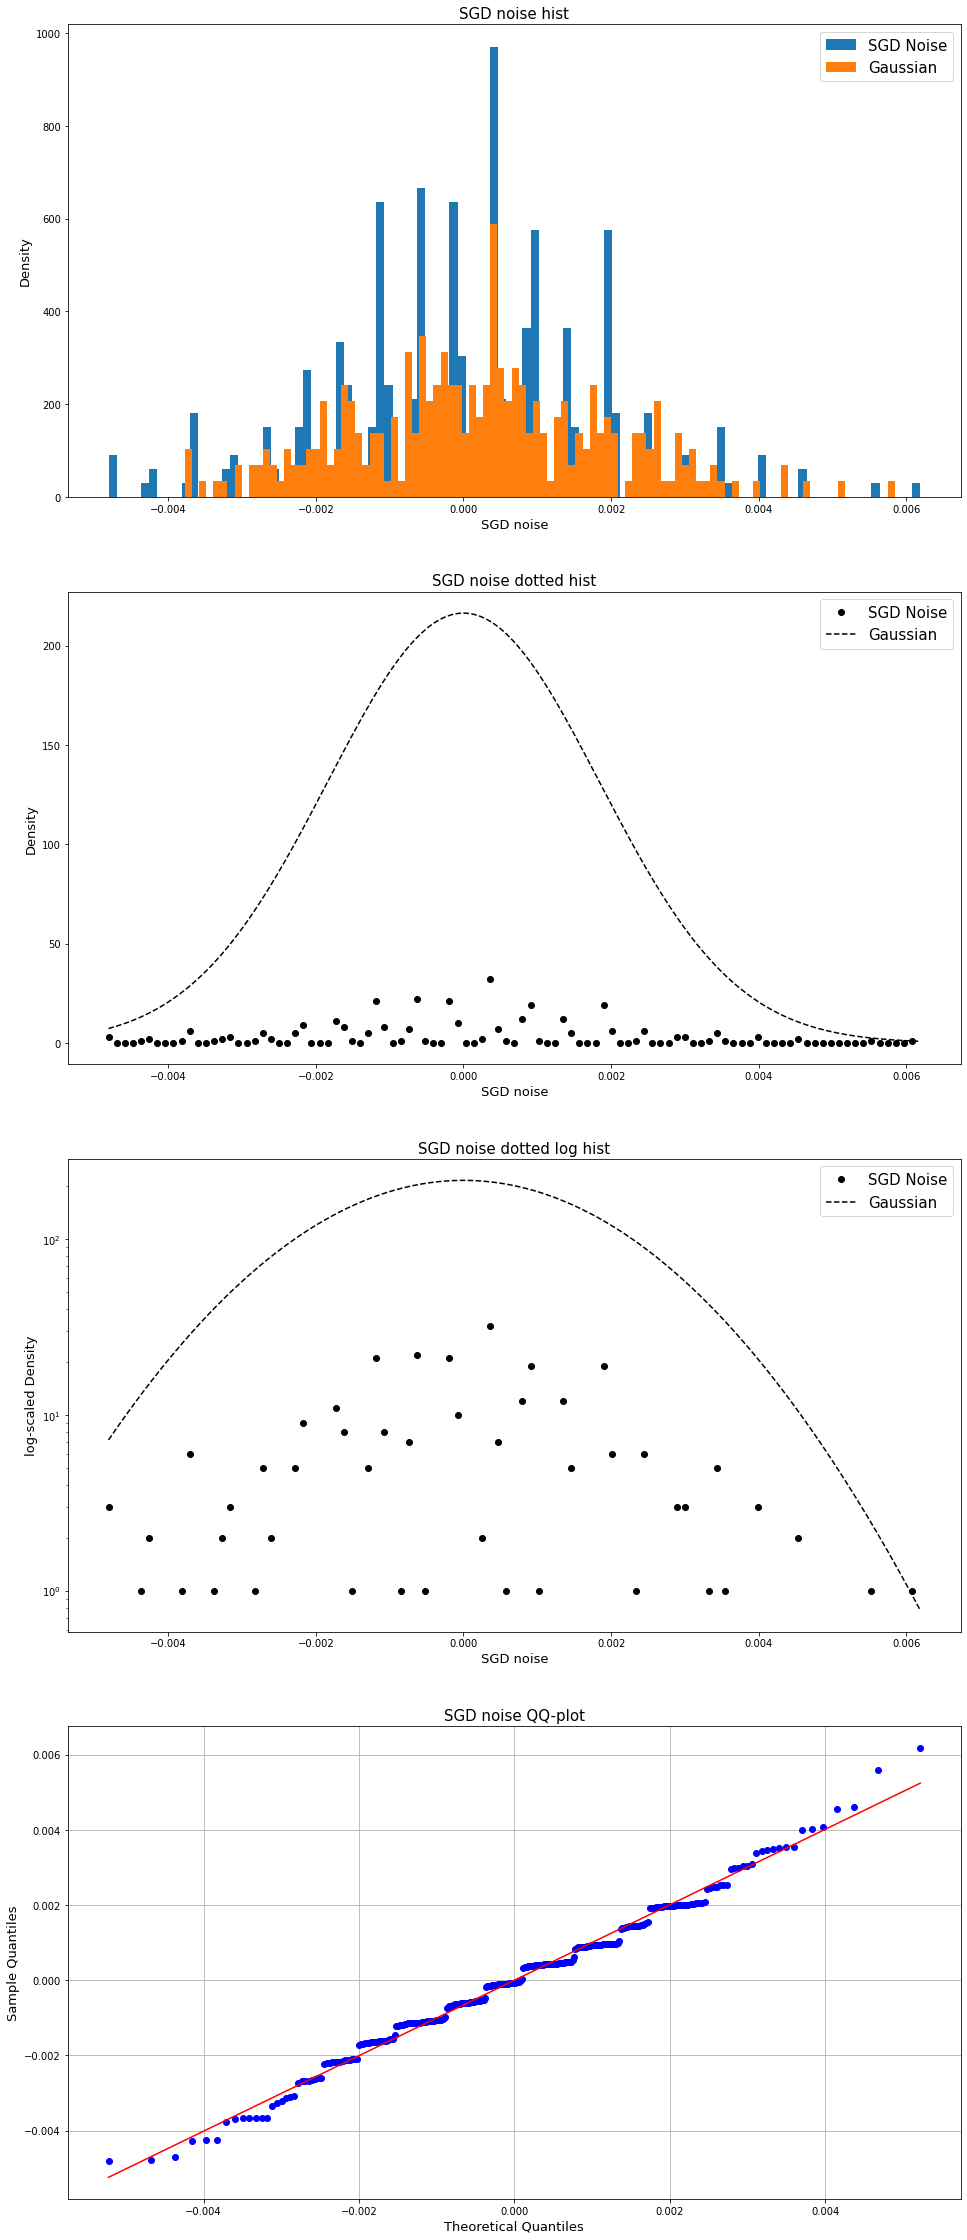

In [57]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #10

In [58]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[10].shape

(34122, 300)

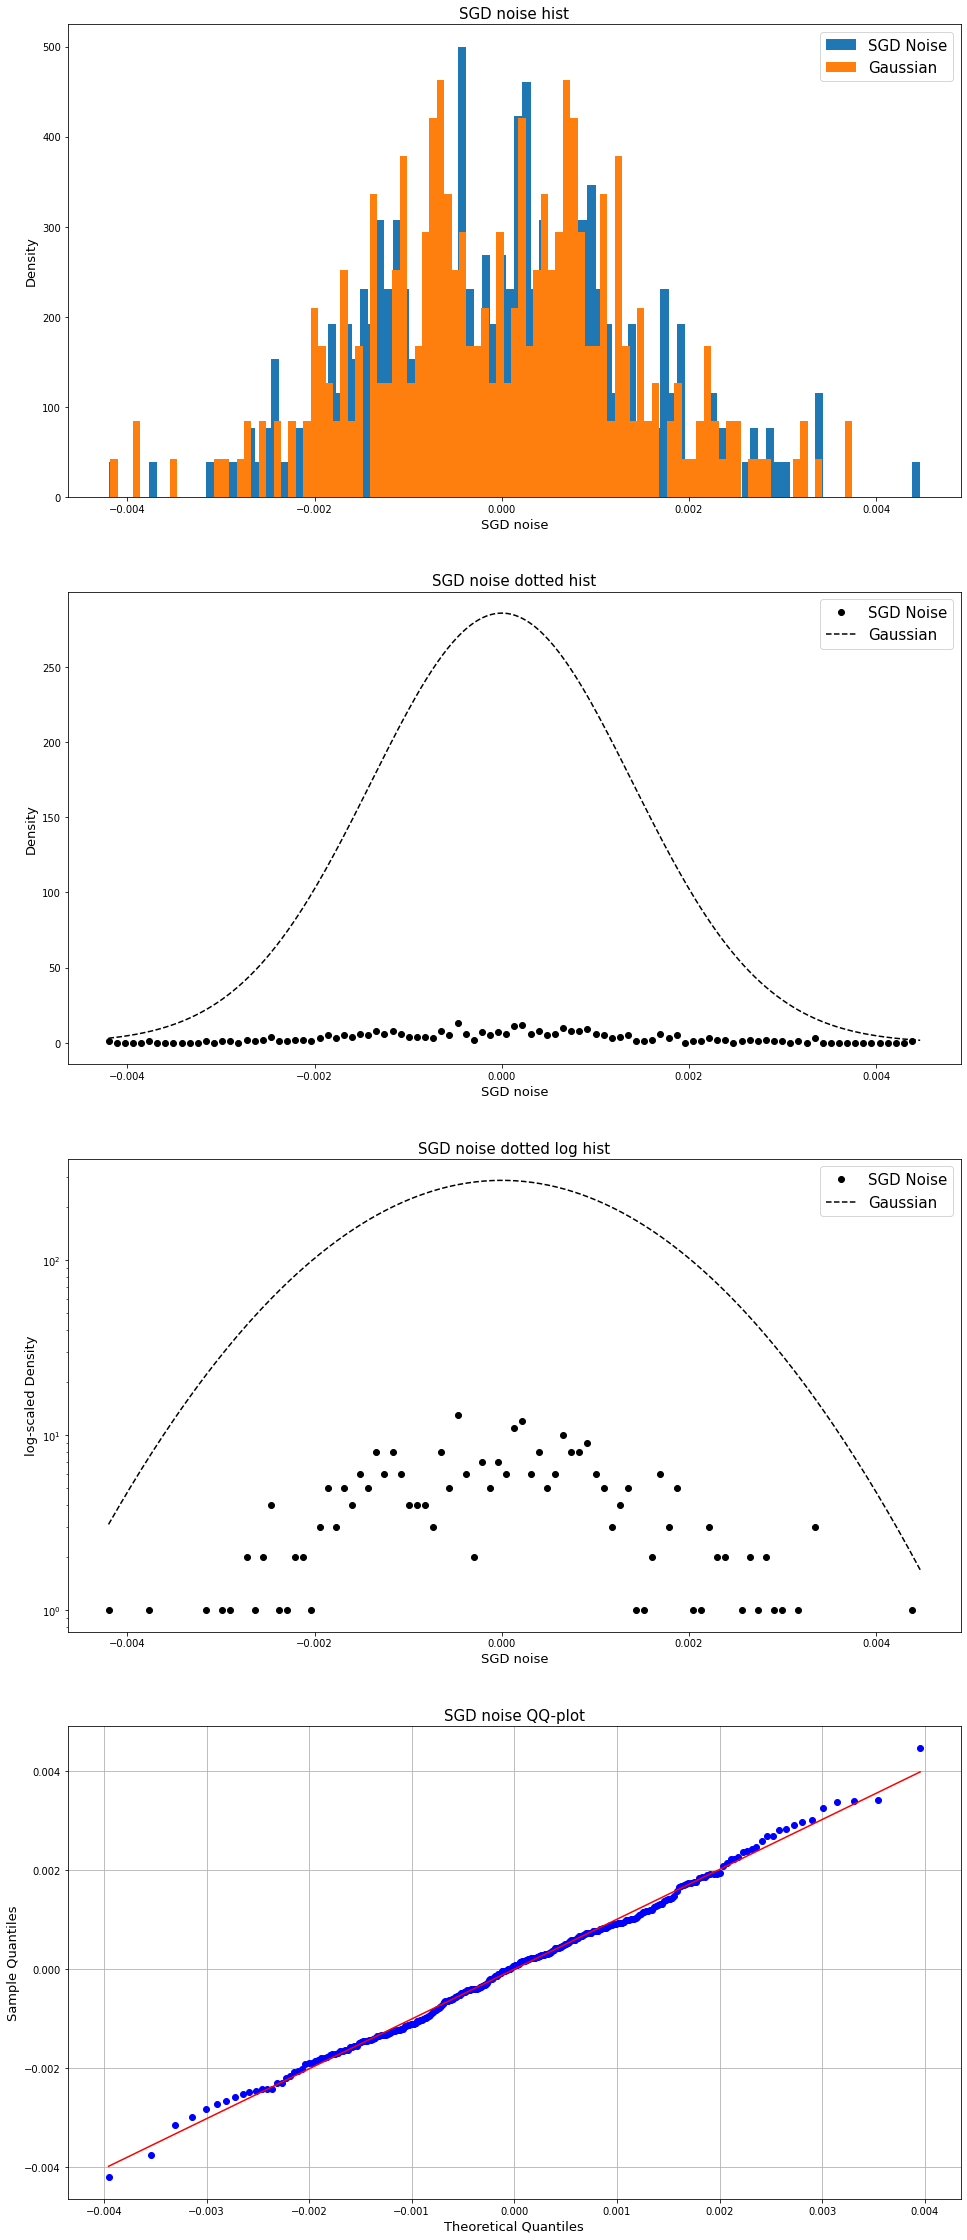

In [59]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[10][111], distribution=norm, dist_name='Gaussian', bins=100)

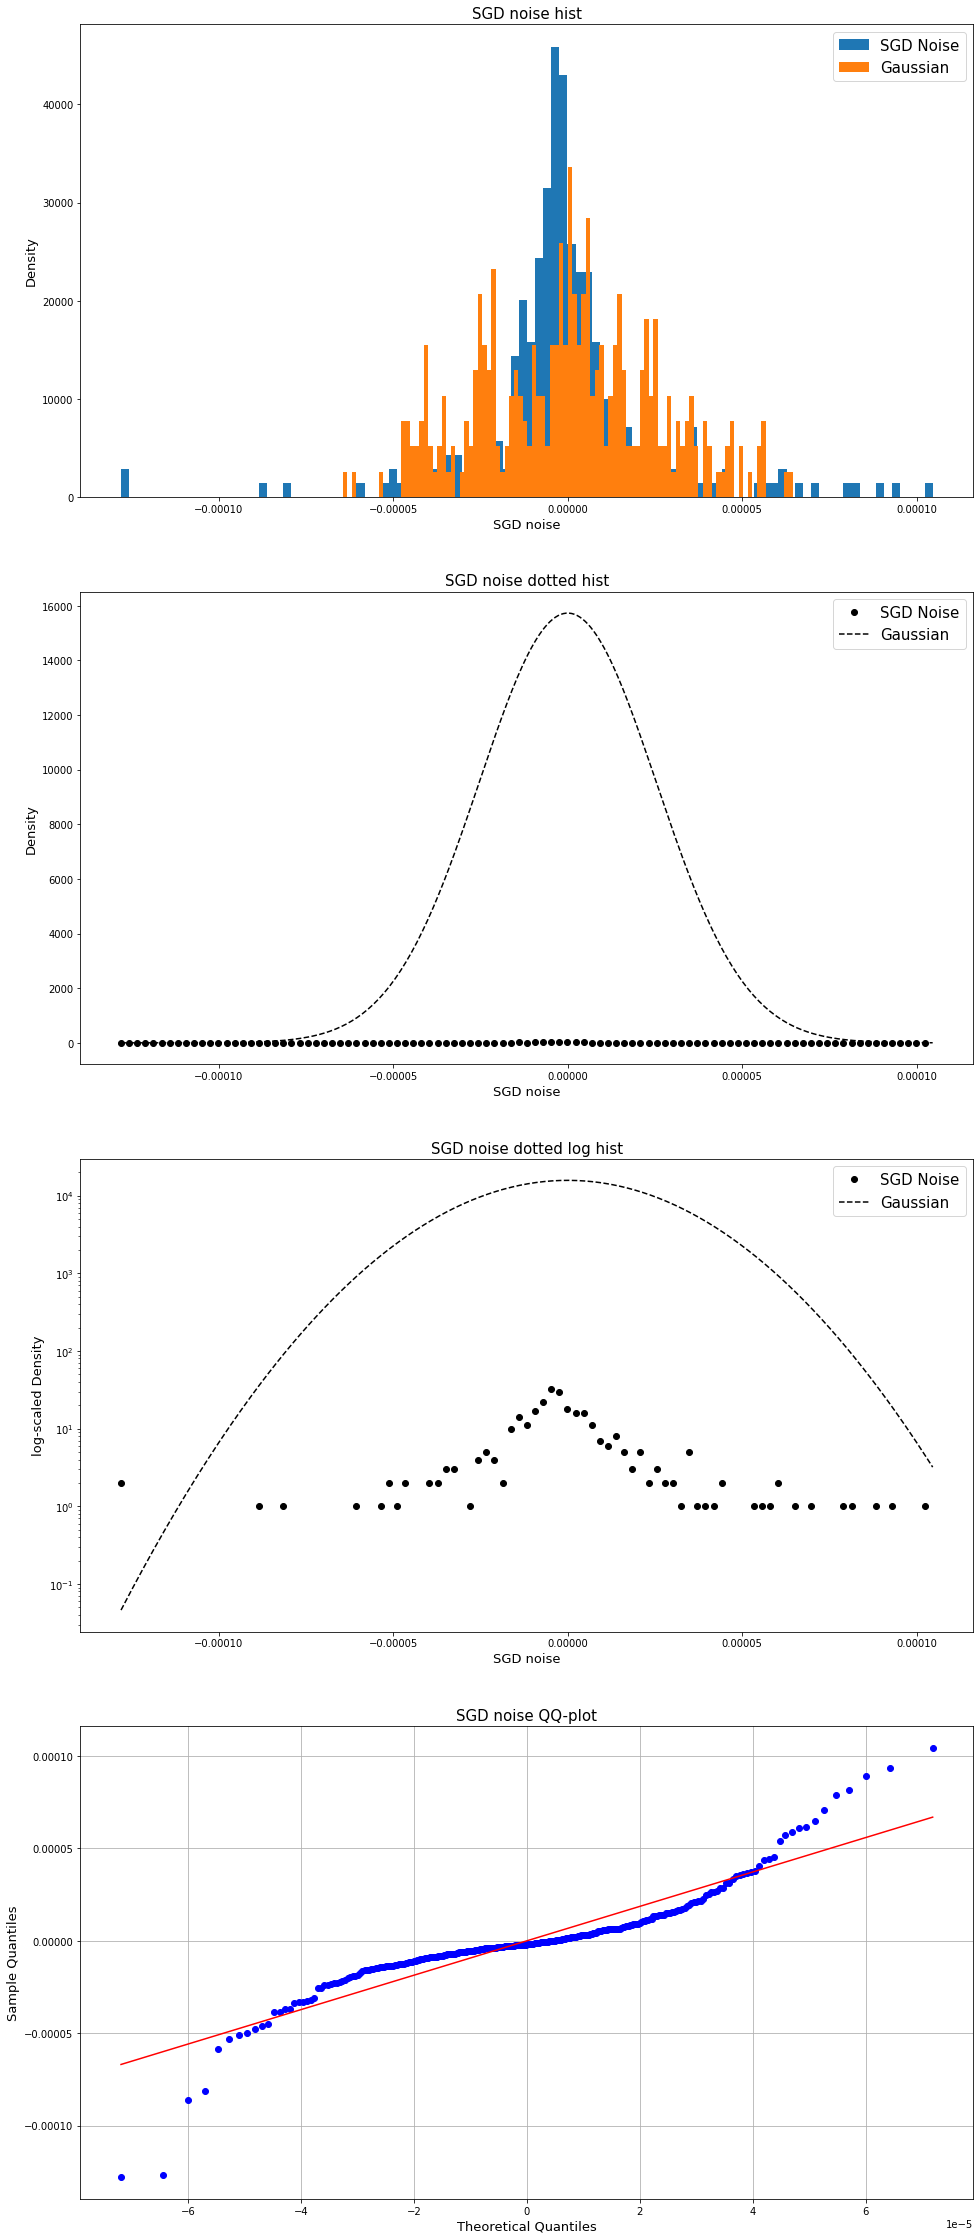

In [60]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[10][300], distribution=norm, dist_name='Gaussian', bins=100)

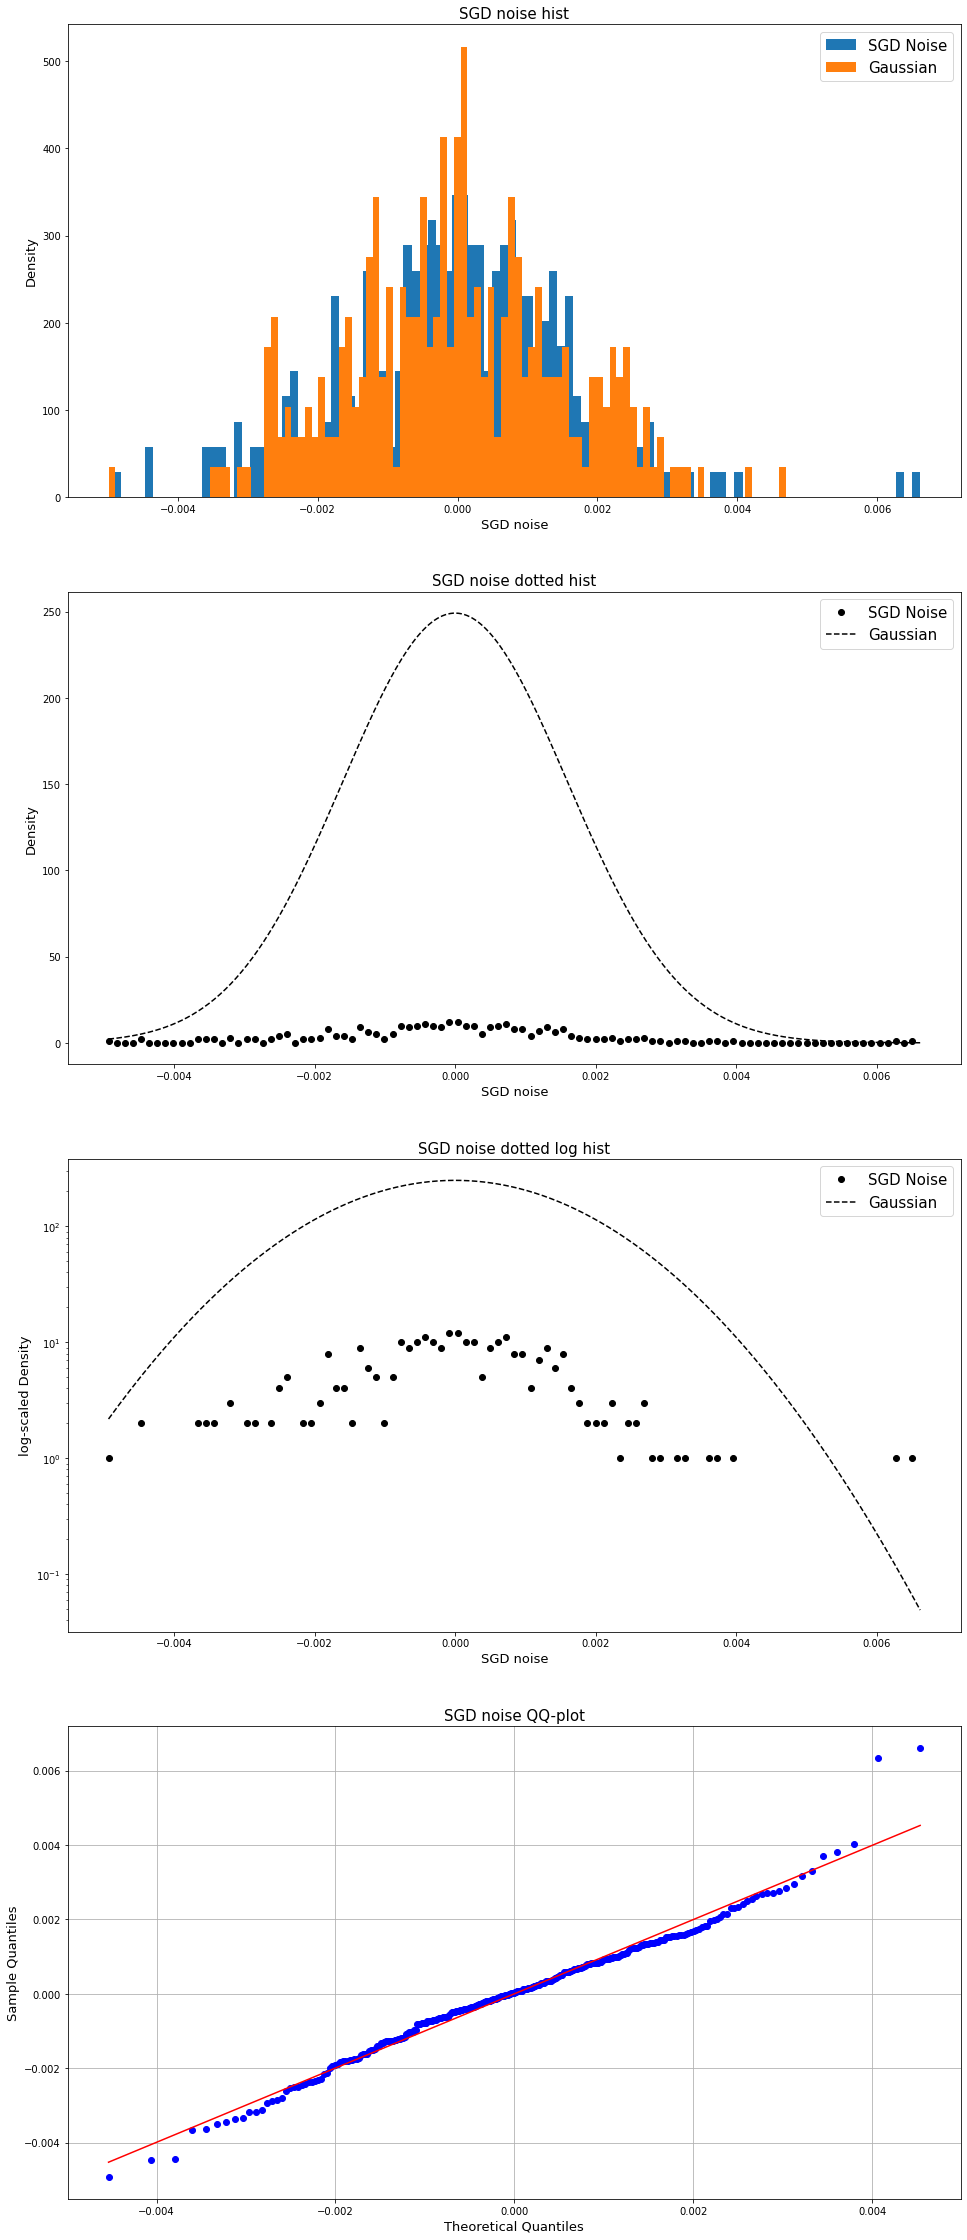

In [61]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[10][20000], distribution=norm, dist_name='Gaussian', bins=100)

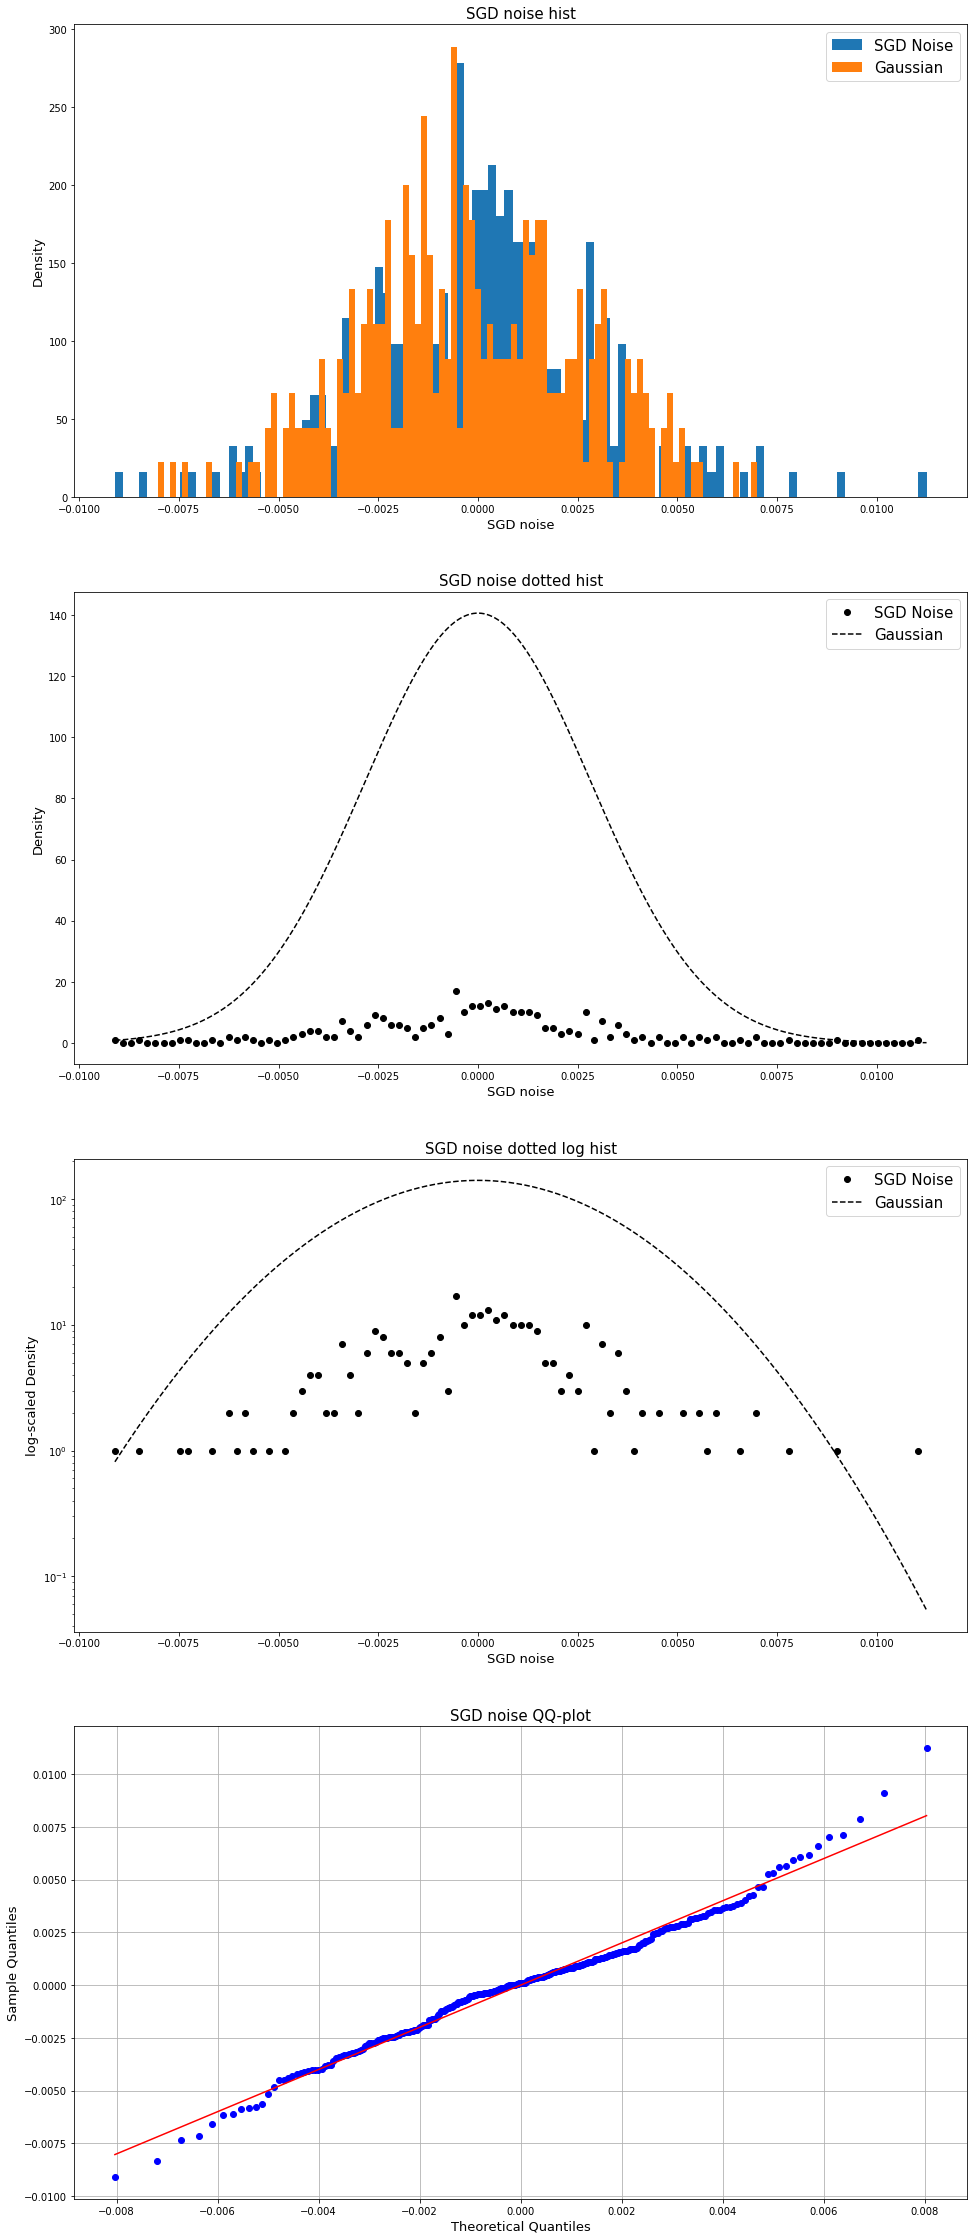

In [62]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[10][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #20

In [63]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[20].shape

(34393, 300)

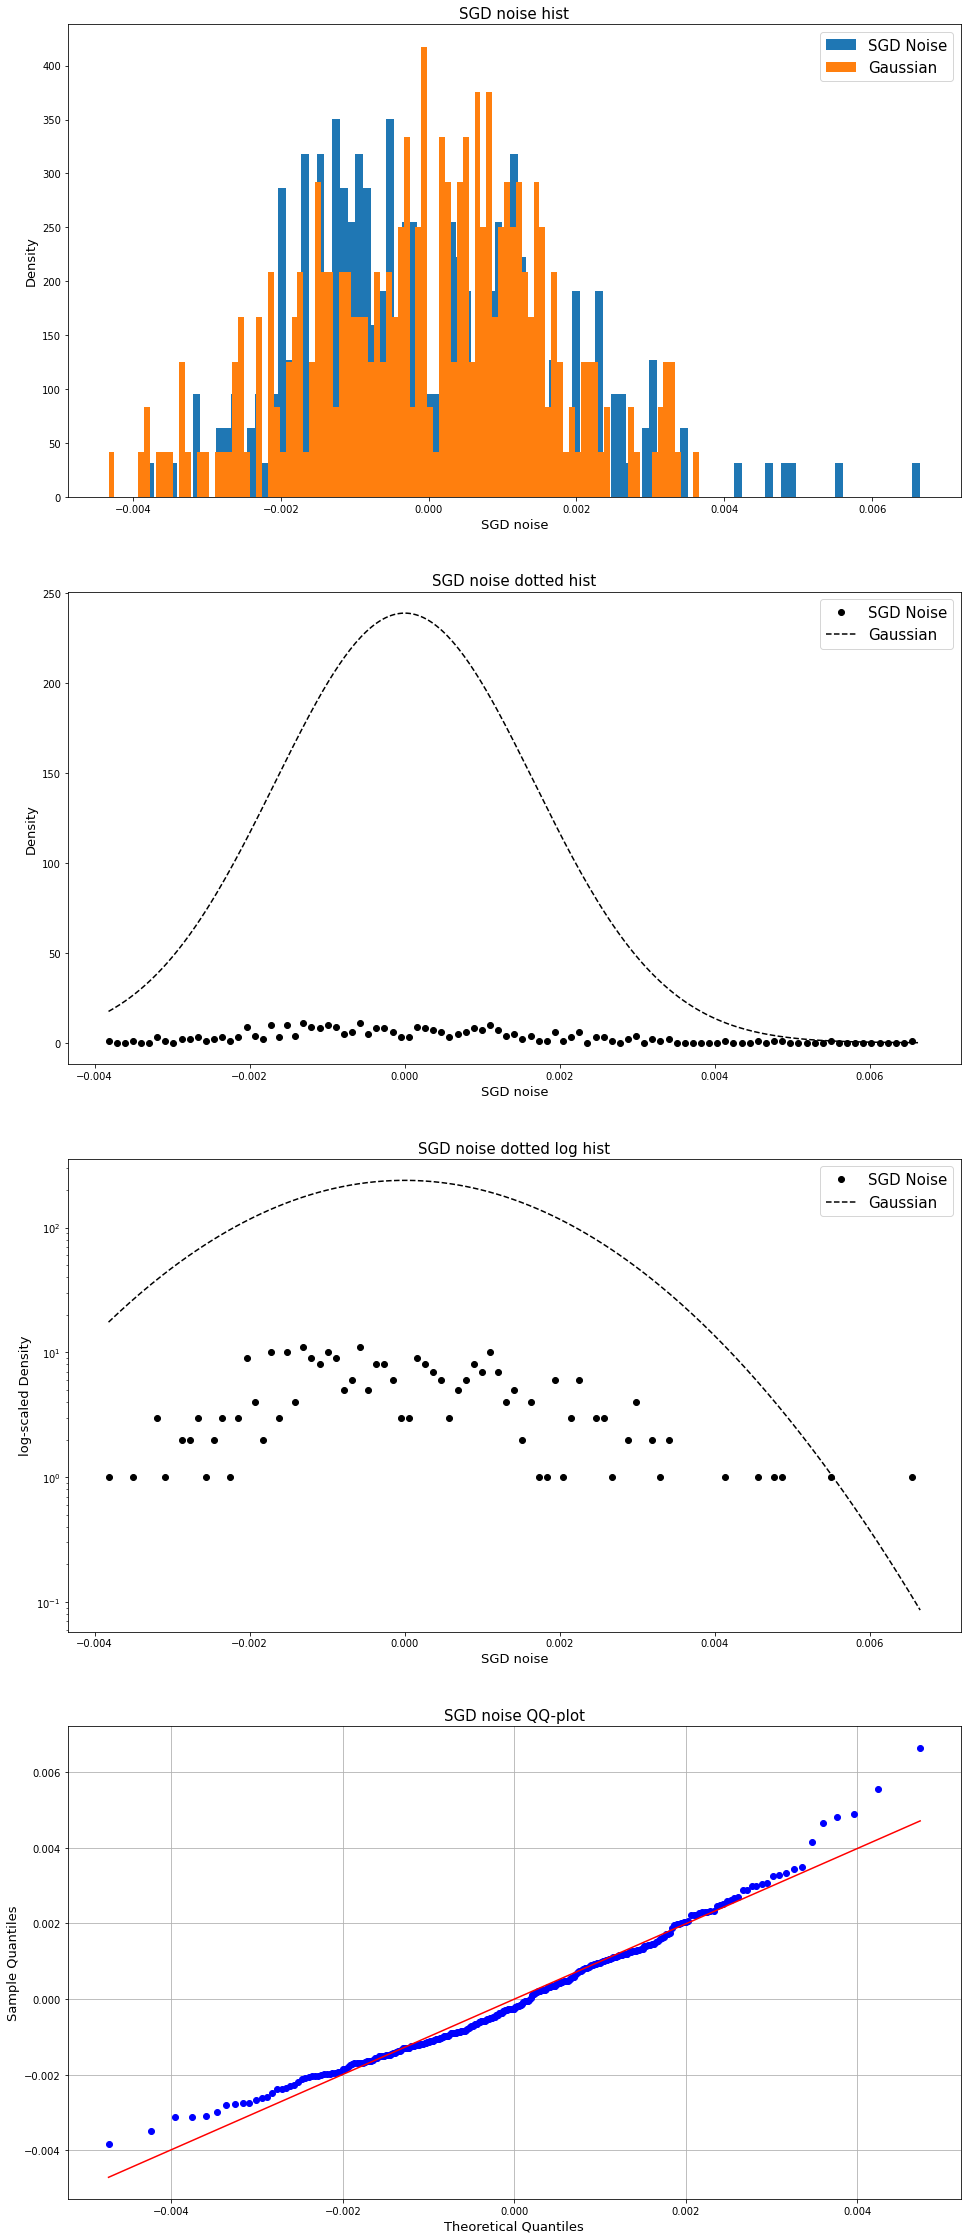

In [64]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[20][111], distribution=norm, dist_name='Gaussian', bins=100)

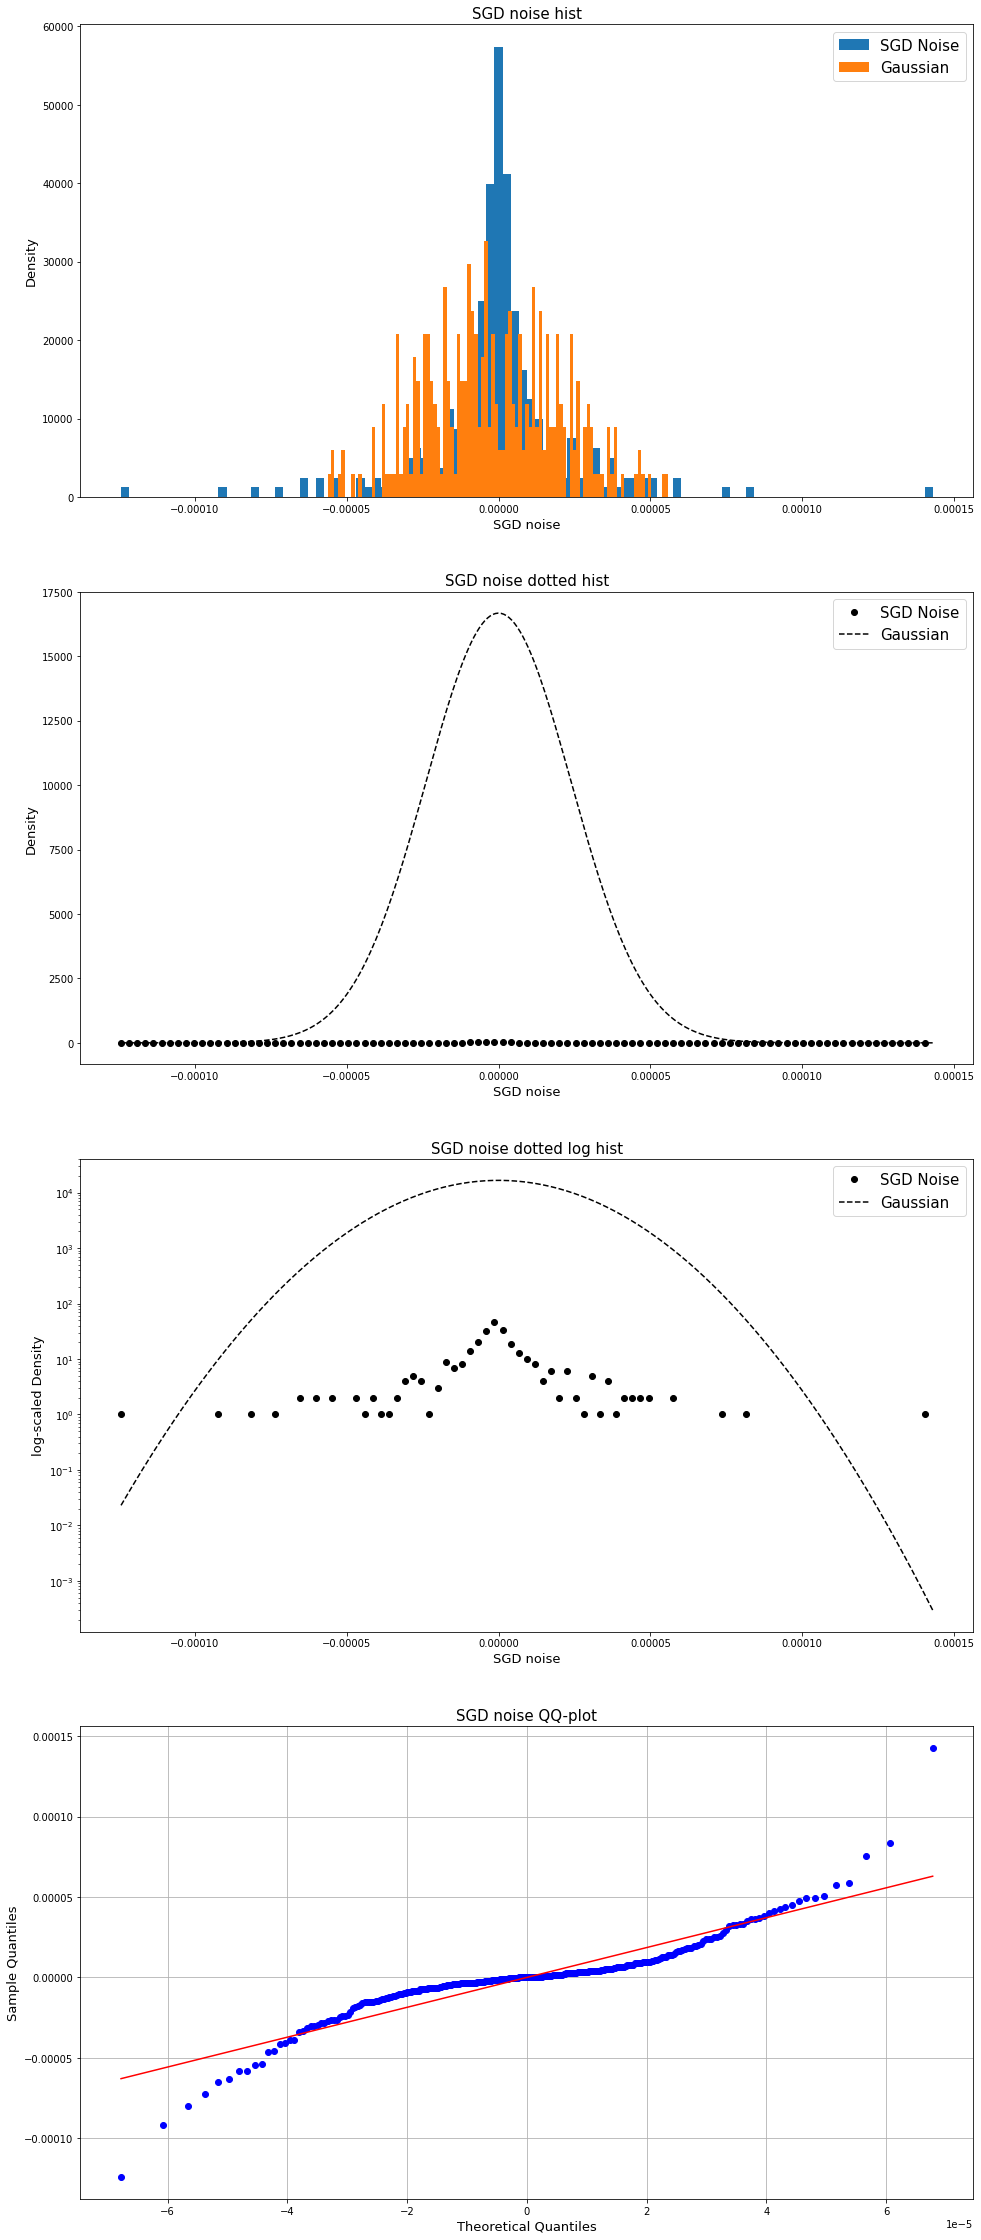

In [65]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[20][300], distribution=norm, dist_name='Gaussian', bins=100)

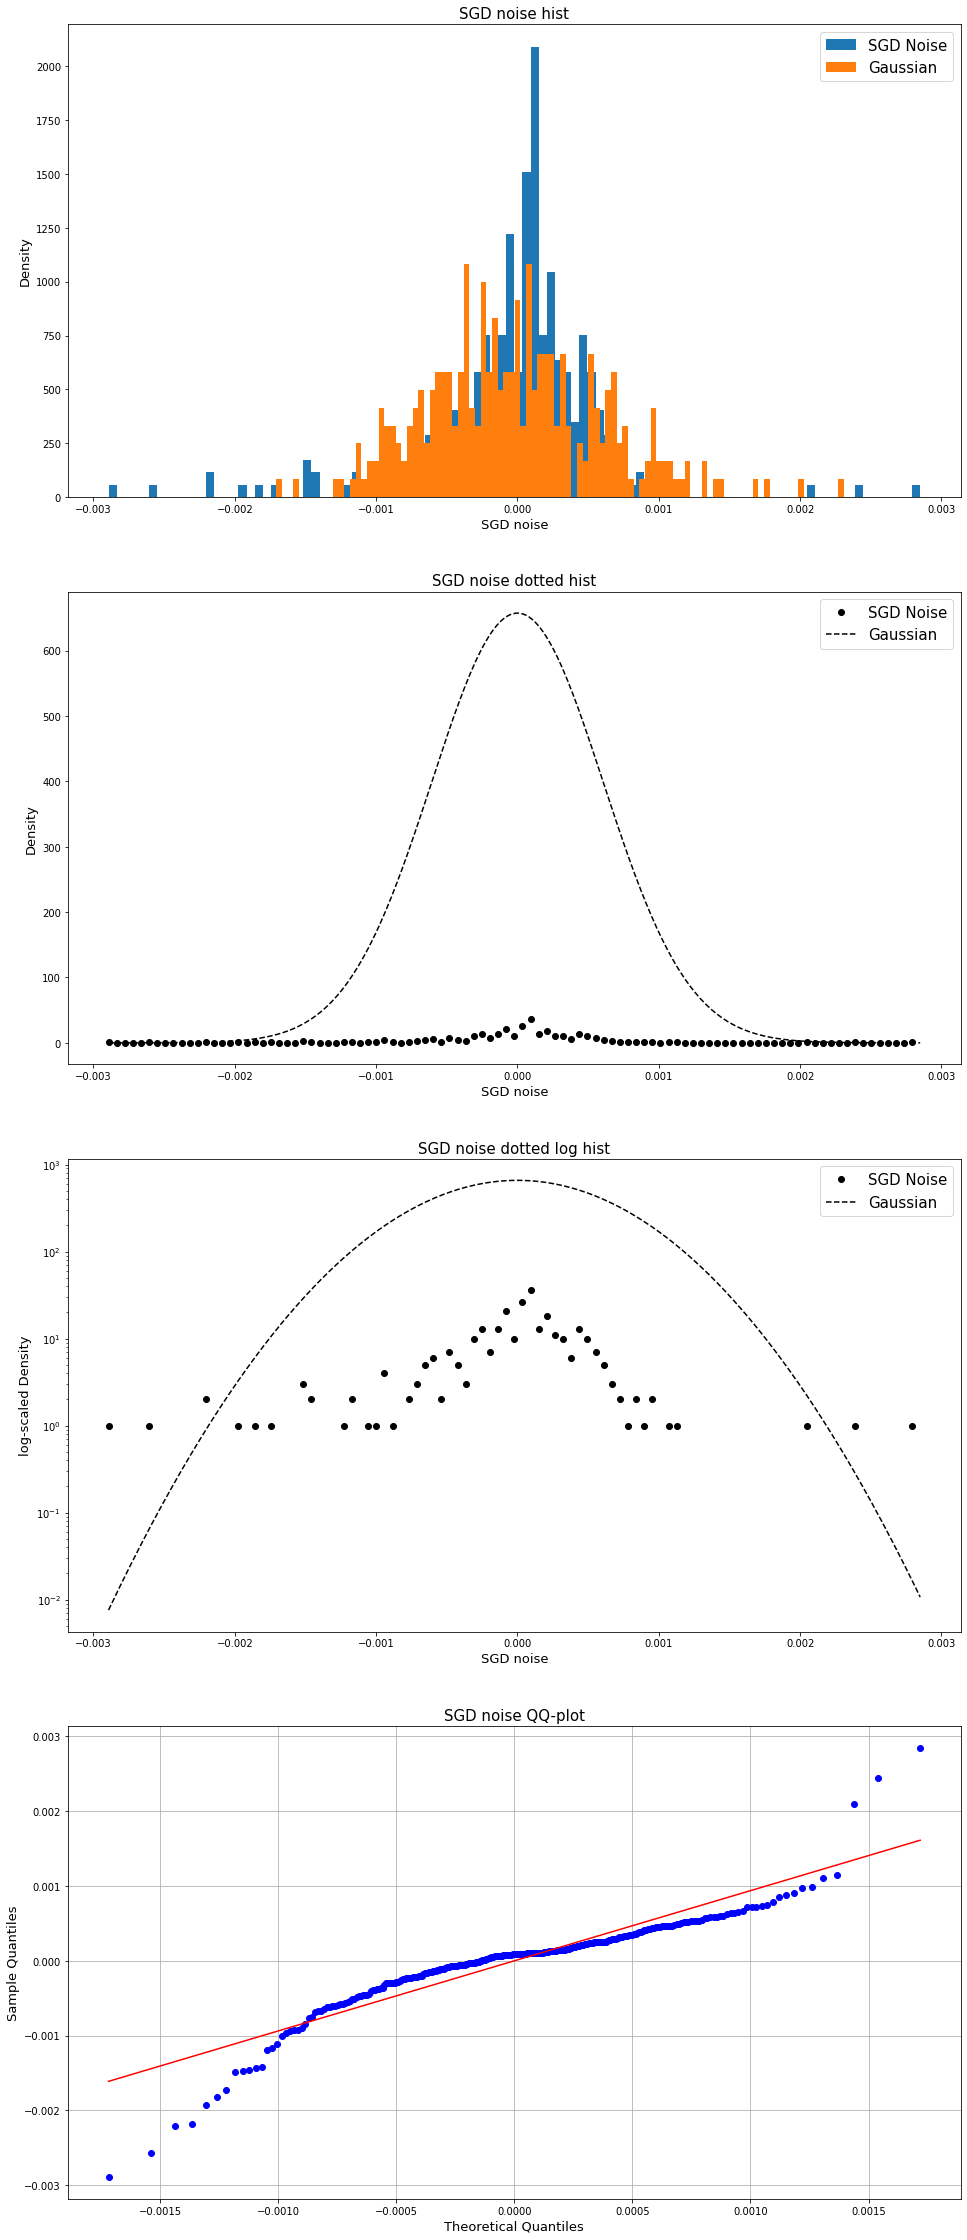

In [66]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[20][20000], distribution=norm, dist_name='Gaussian', bins=100)

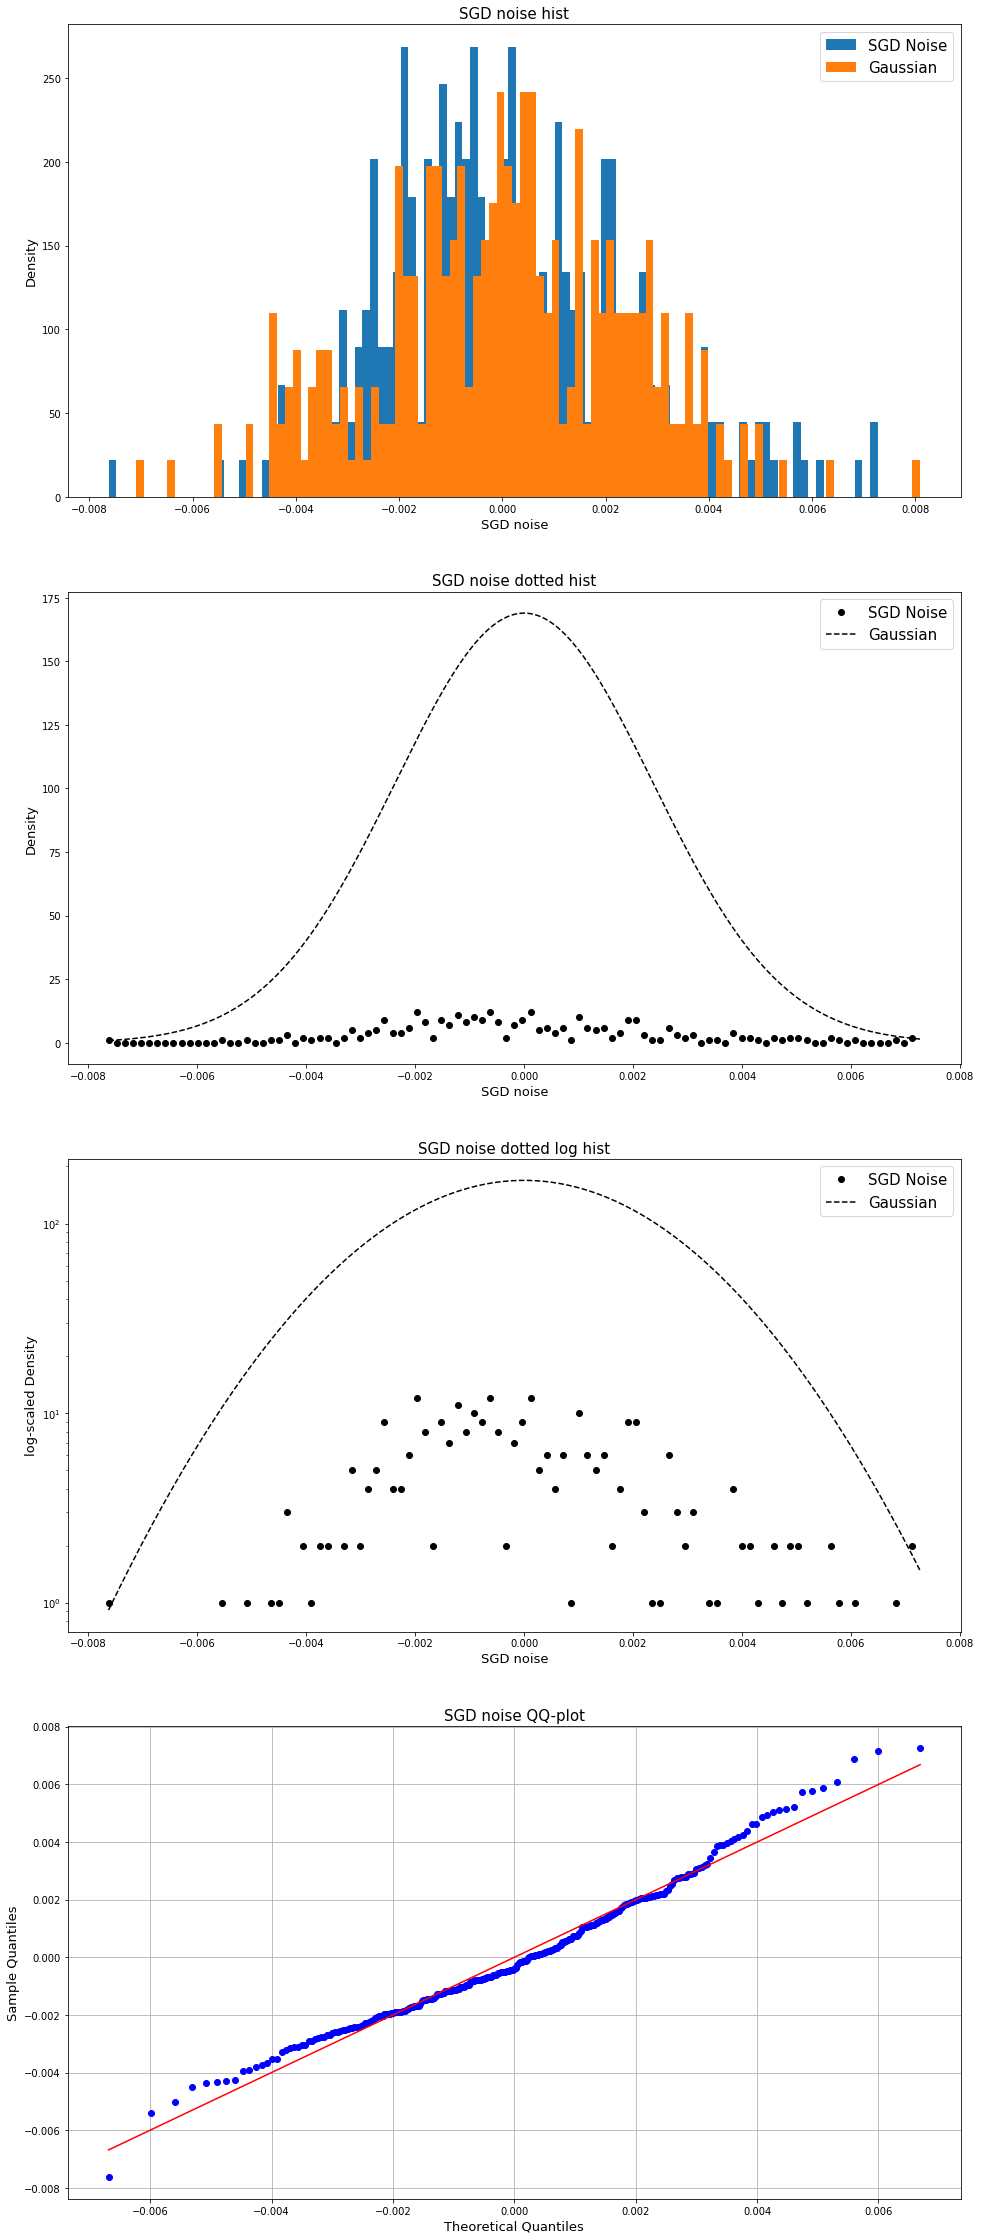

In [67]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[20][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #30

In [68]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[-1].shape

(34457, 300)

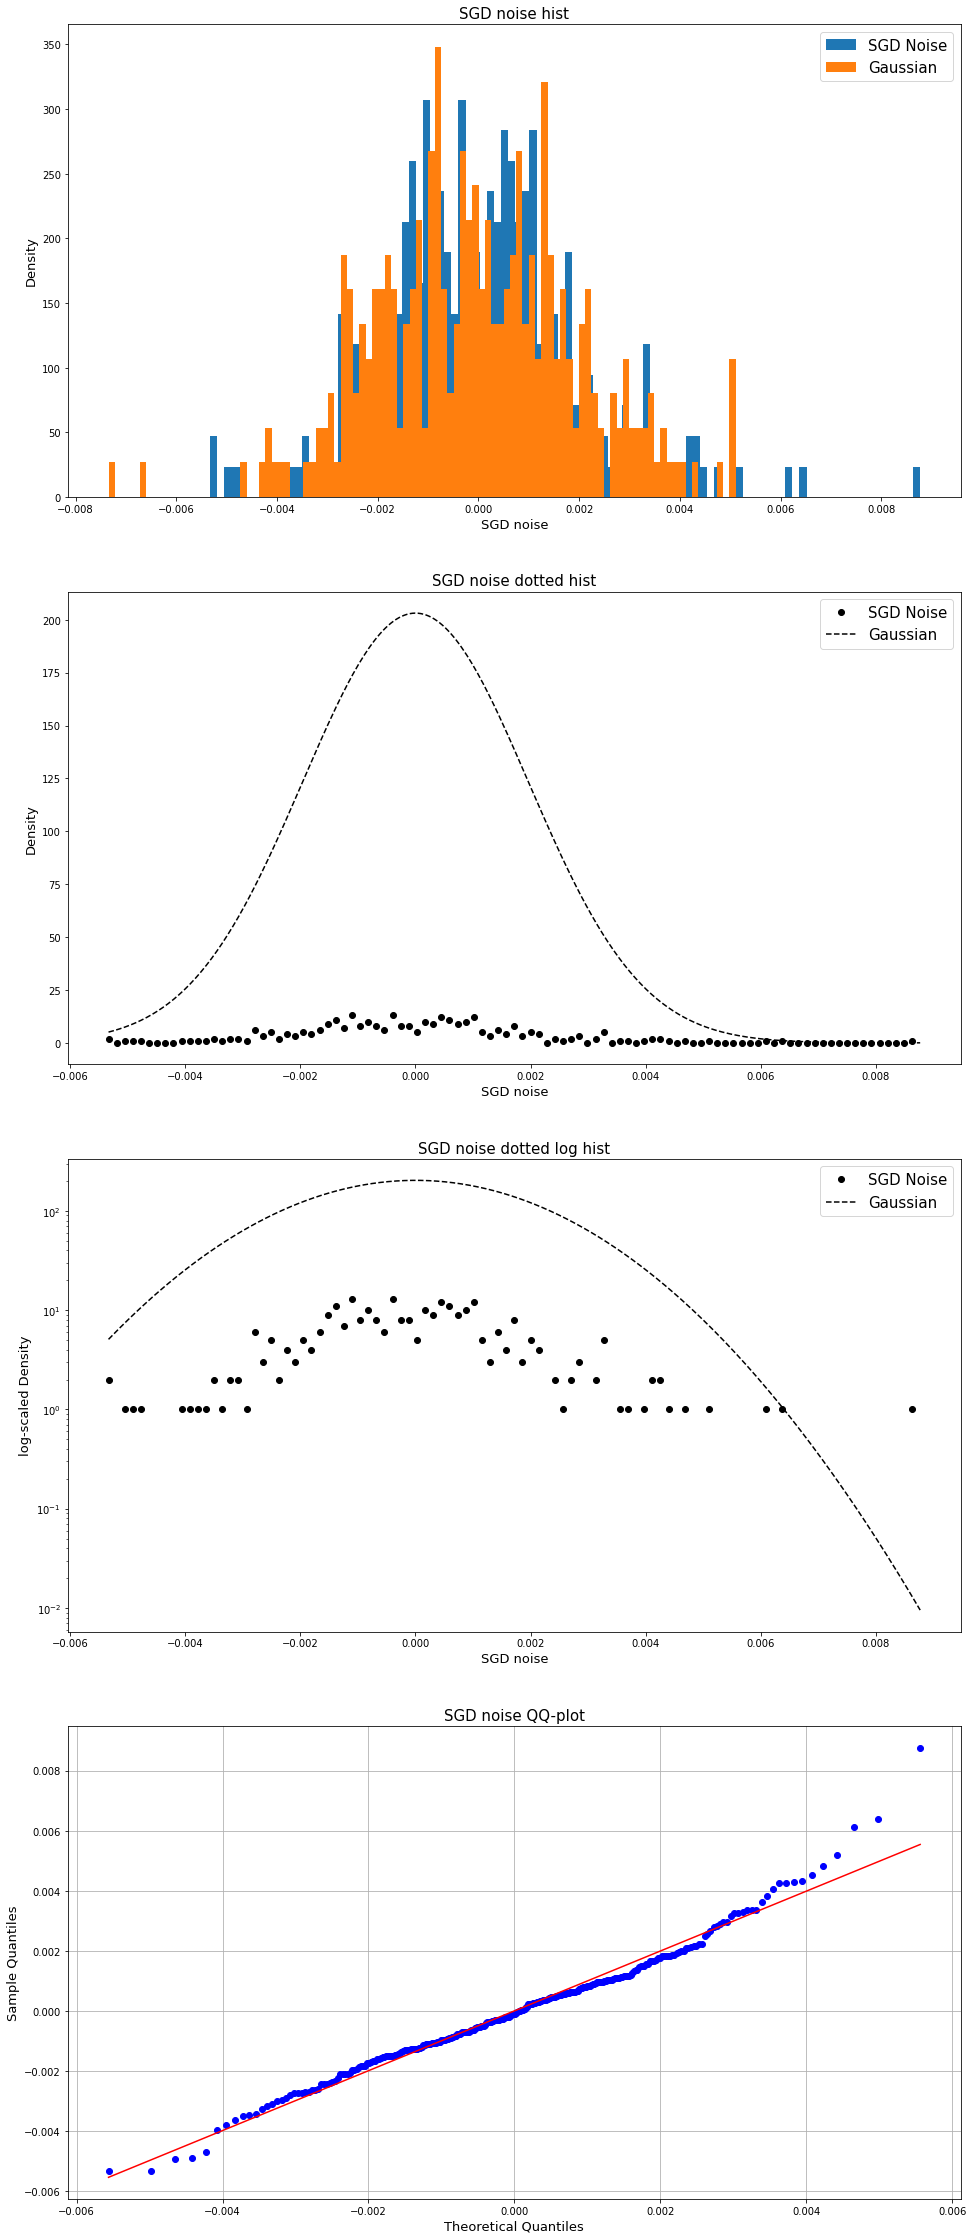

In [69]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[-1][111], distribution=norm, dist_name='Gaussian', bins=100)

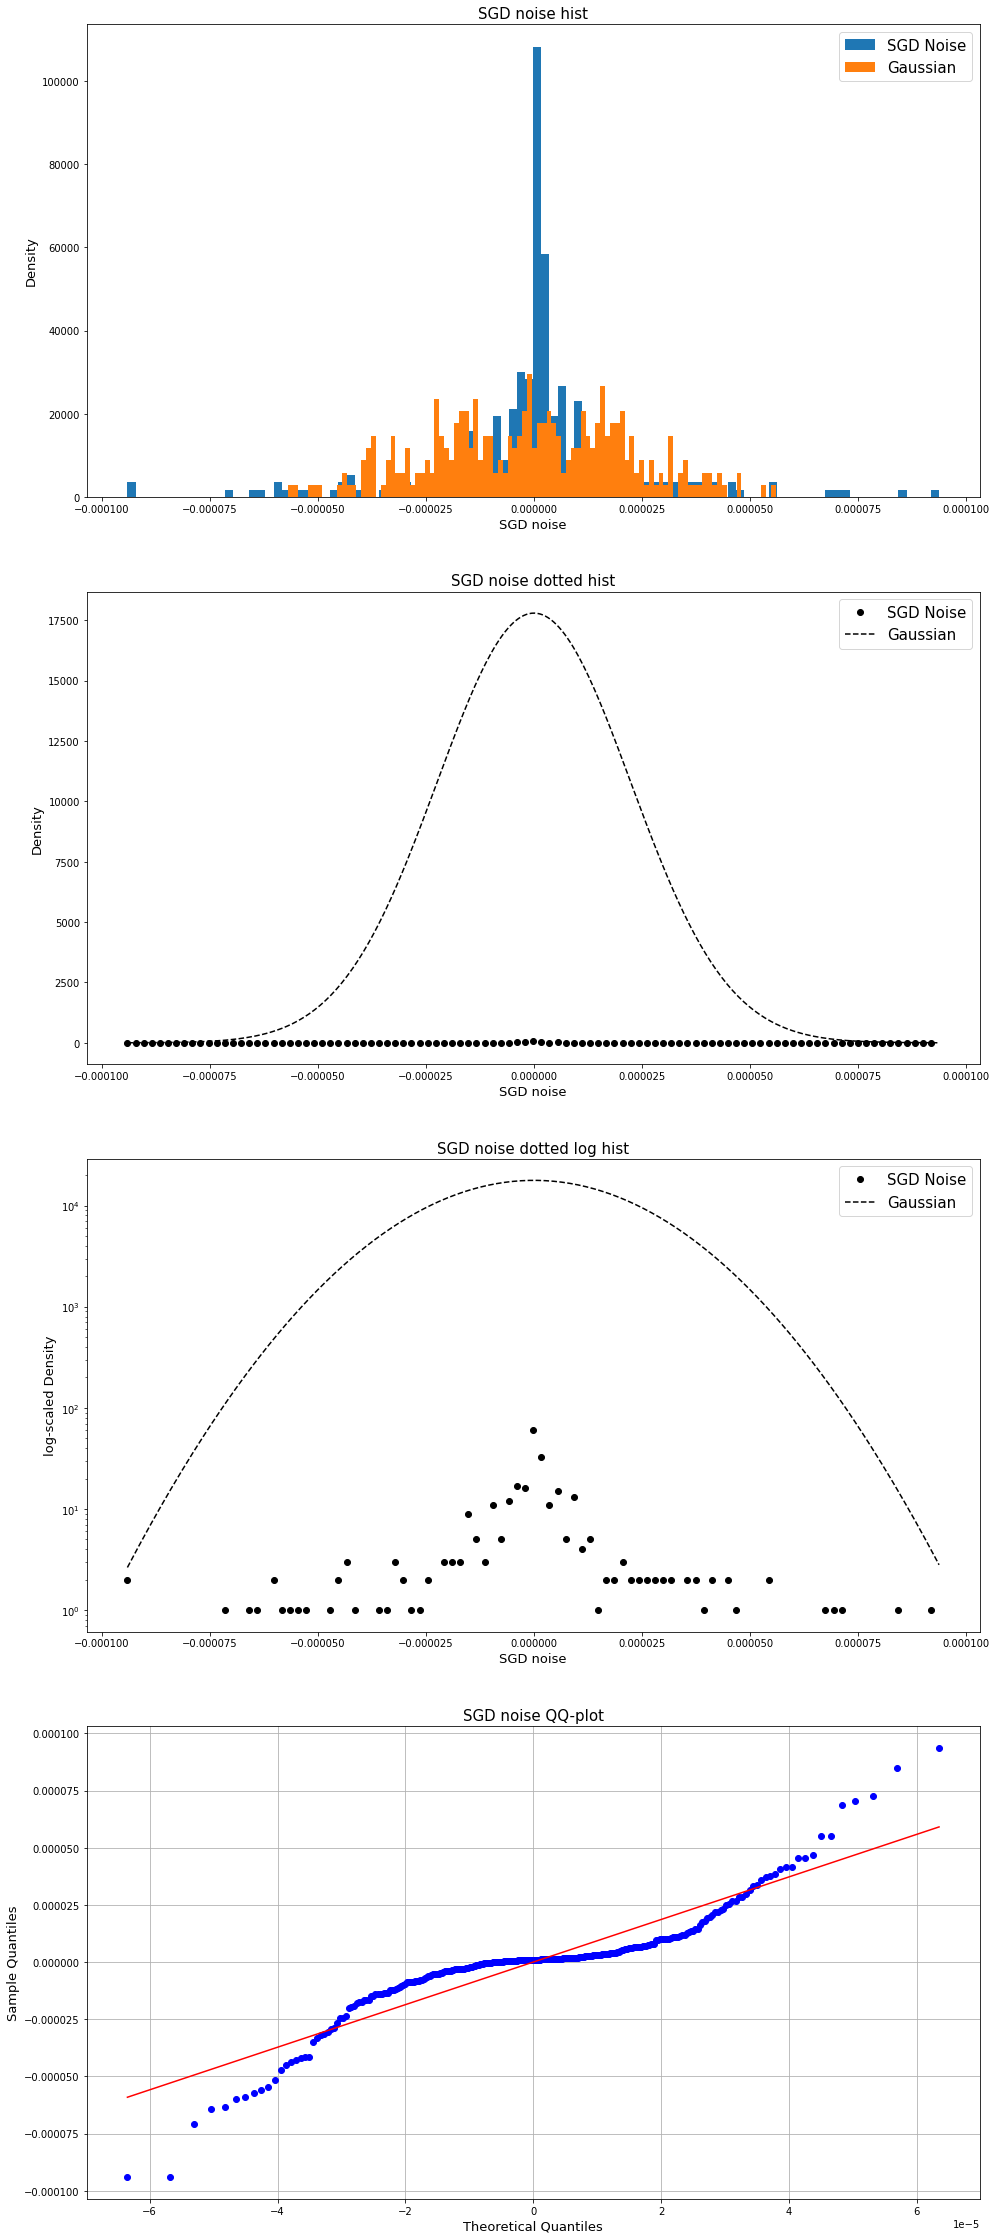

In [70]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[-1][300], distribution=norm, dist_name='Gaussian', bins=100)

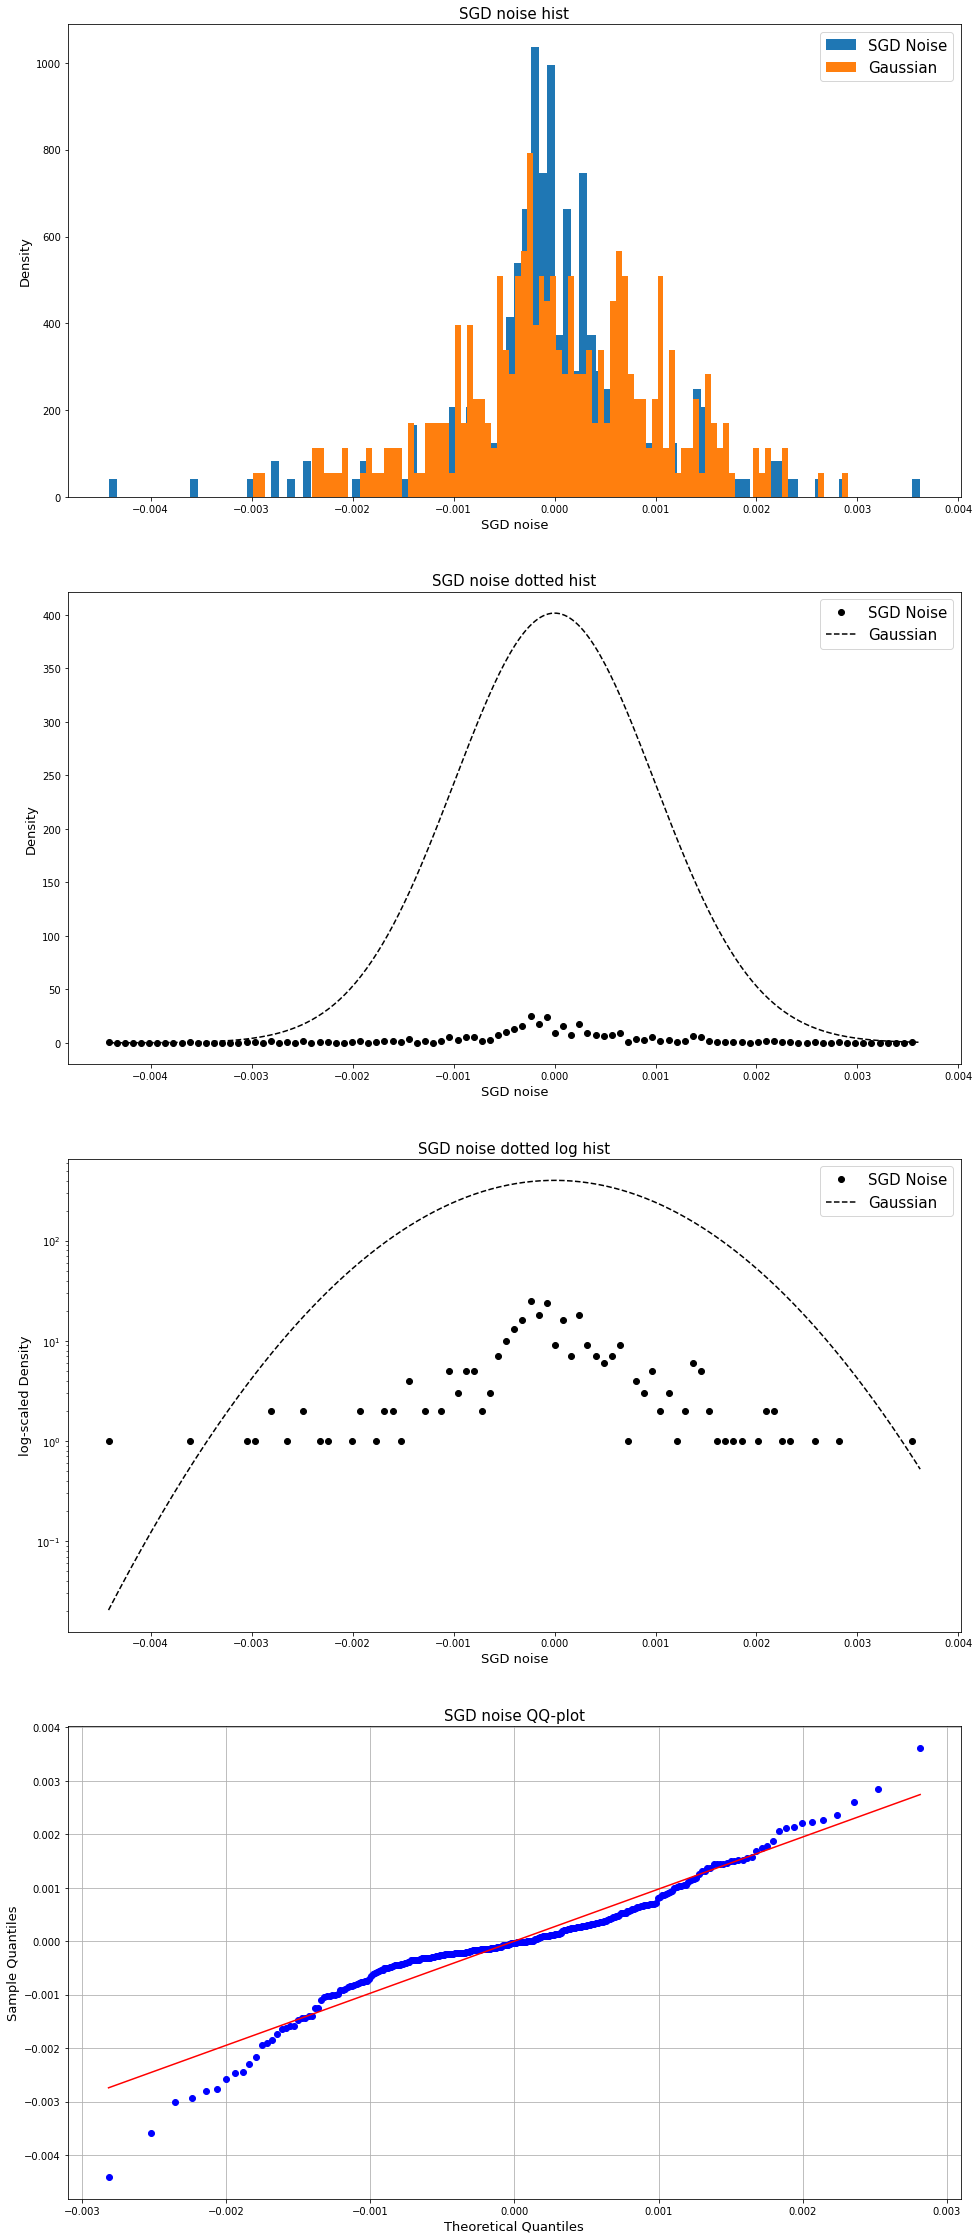

In [71]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[-1][20000], distribution=norm, dist_name='Gaussian', bins=100)

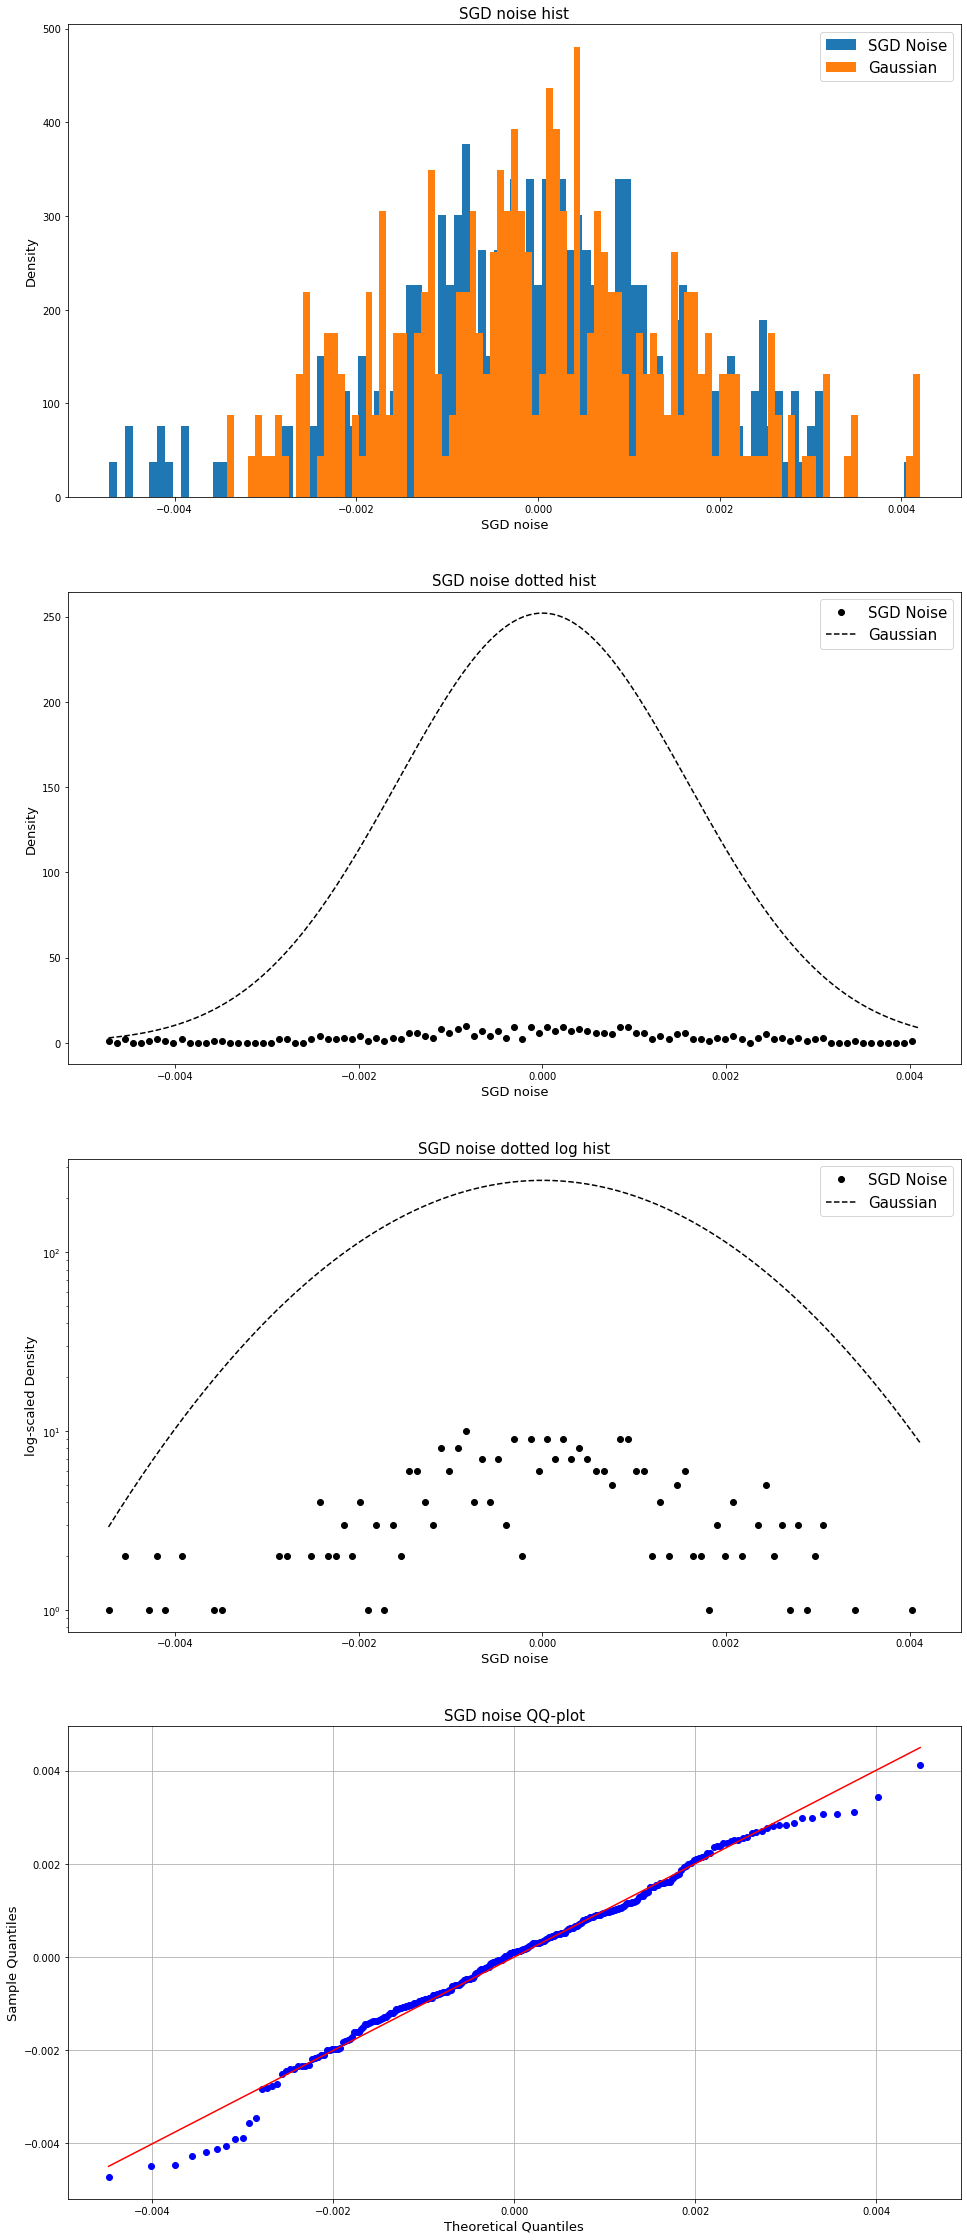

In [72]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[-1][-1], distribution=norm, dist_name='Gaussian', bins=100)

In [73]:
# 1200 gradients per batch for 89838 neurons in 15th epoch
sgn_storage[2].shape

(31195, 300)

# Batch size=300

In [74]:
Lenetcnn = nn.Sequential(nn.Conv2d(in_channels=1,out_channels=6,kernel_size=(5,5),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                    nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d((2,2)),
                   
                    nn.Flatten(),
                    nn.Linear(400,84),
                    nn.ReLU(),
                    nn.Linear(84,10),
                    nn.Softmax())

In [75]:
batch_size = 300
lr = 1e-1
epochs = 10
log_iter=100

#30 iterations
total_iterations=epochs*(60000/batch_size)/log_iter
print('total iterations',total_iterations)

total iterations 20.0


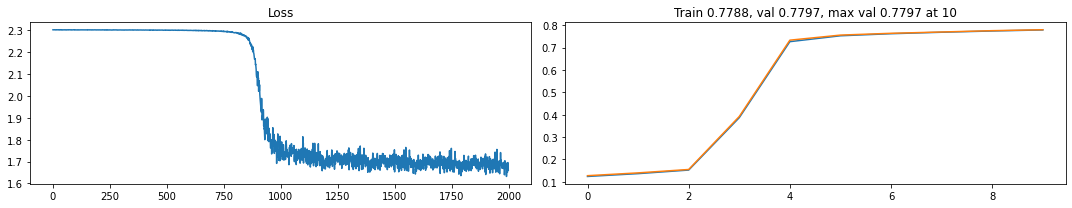

100%|██████████| 10/10 [05:04<00:00, 30.49s/it]


In [76]:
set_random_seeds(device=device)
batch_size=300
#your file path where save gradients
#can be your local path ir google drive path
filepath = 'exp_ml/grads_batch_300'

#in case of google drive
#filepath='/content/gdrive/MyDrive/Gradient_exp/grads_batch_100'

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=2)


#model = FullyConnected(input_dim=28*28, width=width, depth=depth, num_classes=10)
model=Lenetcnn
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


mini_batch_150_model = train(model, optimizer, loss_function,
                             train_loader, val_loader,
                             device, filepath=filepath, epochs=epochs,
                             log_iter=100)

# Alpha disrtibution

In [77]:
## This is quite slow block of code (takes about 10 minuets for 10 files with gradients from gDrive)
# amount of minibatches
batchsize=300
N = int(60000/300)
alphas = []
sgn_storage = []
filepath = 'exp_ml/grads_batch_300'


for itera in trange(1, int(total_iterations), 1):
    batch_grads = []
    with open(filepath + f'_logiter_{itera}.npy', 'rb') as file:
        for _ in range(N):
            batch_grads.append(np.load(file))
    
    sgn = (np.array(batch_grads) - np.array(batch_grads).sum(axis=0) / N).T
    del(batch_grads)
    # delete non-active neuron's sgn (zero-vectors sgn)
    sgn = sgn[~np.any(sgn == 0, axis=1), :]
    # store SGN for concrete epoch 
    sgn_storage.append(sgn)
    del(sgn)
    # calculating alpha for epoch
    alphas.append(np.apply_along_axis(alpha_estimator, axis=1, arr=sgn_storage[-1]))
    print(sgn_storage[-1].shape)
    

  5%|▌         | 1/19 [00:09<02:53,  9.63s/it]

(29749, 200)


 11%|█         | 2/19 [00:19<02:44,  9.68s/it]

(29926, 200)


 16%|█▌        | 3/19 [00:29<02:34,  9.65s/it]

(30149, 200)


 21%|██        | 4/19 [00:38<02:24,  9.65s/it]

(30394, 200)


 26%|██▋       | 5/19 [00:48<02:15,  9.70s/it]

(30785, 200)


 32%|███▏      | 6/19 [00:58<02:06,  9.74s/it]

(30975, 200)


 37%|███▋      | 7/19 [01:08<01:57,  9.82s/it]

(31359, 200)


 42%|████▏     | 8/19 [01:18<01:50, 10.06s/it]

(31415, 200)


 47%|████▋     | 9/19 [01:28<01:39,  9.94s/it]

(30372, 200)


 53%|█████▎    | 10/19 [01:38<01:28,  9.85s/it]

(30358, 200)


 58%|█████▊    | 11/19 [01:47<01:18,  9.78s/it]

(30134, 200)


 63%|██████▎   | 12/19 [01:57<01:08,  9.76s/it]

(30140, 200)


 68%|██████▊   | 13/19 [02:07<00:58,  9.74s/it]

(30451, 200)


 74%|███████▎  | 14/19 [02:17<00:48,  9.78s/it]

(30772, 200)


 79%|███████▉  | 15/19 [02:26<00:39,  9.79s/it]

(30833, 200)


 84%|████████▍ | 16/19 [02:36<00:29,  9.81s/it]

(30897, 200)


 89%|████████▉ | 17/19 [02:46<00:19,  9.82s/it]

(30917, 200)


 95%|█████████▍| 18/19 [02:56<00:09,  9.84s/it]

(30952, 200)


100%|██████████| 19/19 [03:06<00:00,  9.82s/it]

(30986, 200)


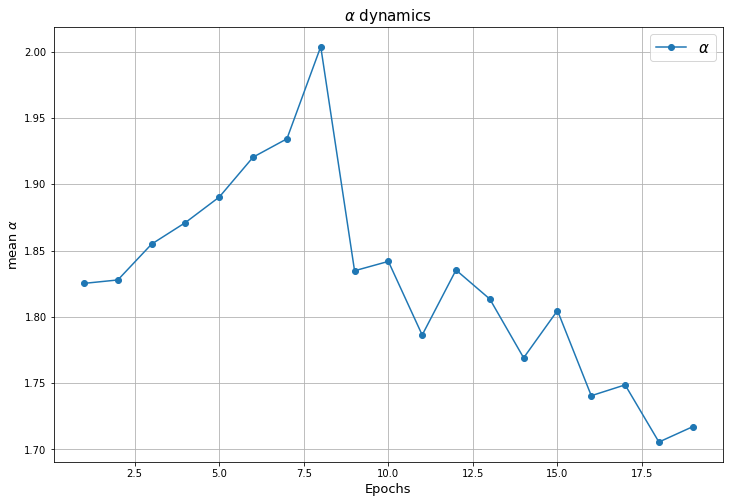

In [78]:
mean_alphas = []
for alpha_vec in alphas:
    mean_alphas.append(alpha_vec.mean())

alpha_dynamics(mean_alphas, [itera for itera in range(1, int(total_iterations), 1)])

# SGN for batch size 300

In [79]:
#Iteration 0

In [80]:
# amount of epochs
len(sgn_storage)

19

In [81]:
# 1200 gradients per batch for 89911 neurons in 5th epoch
sgn_storage[0].shape

(29749, 200)

# Conv1

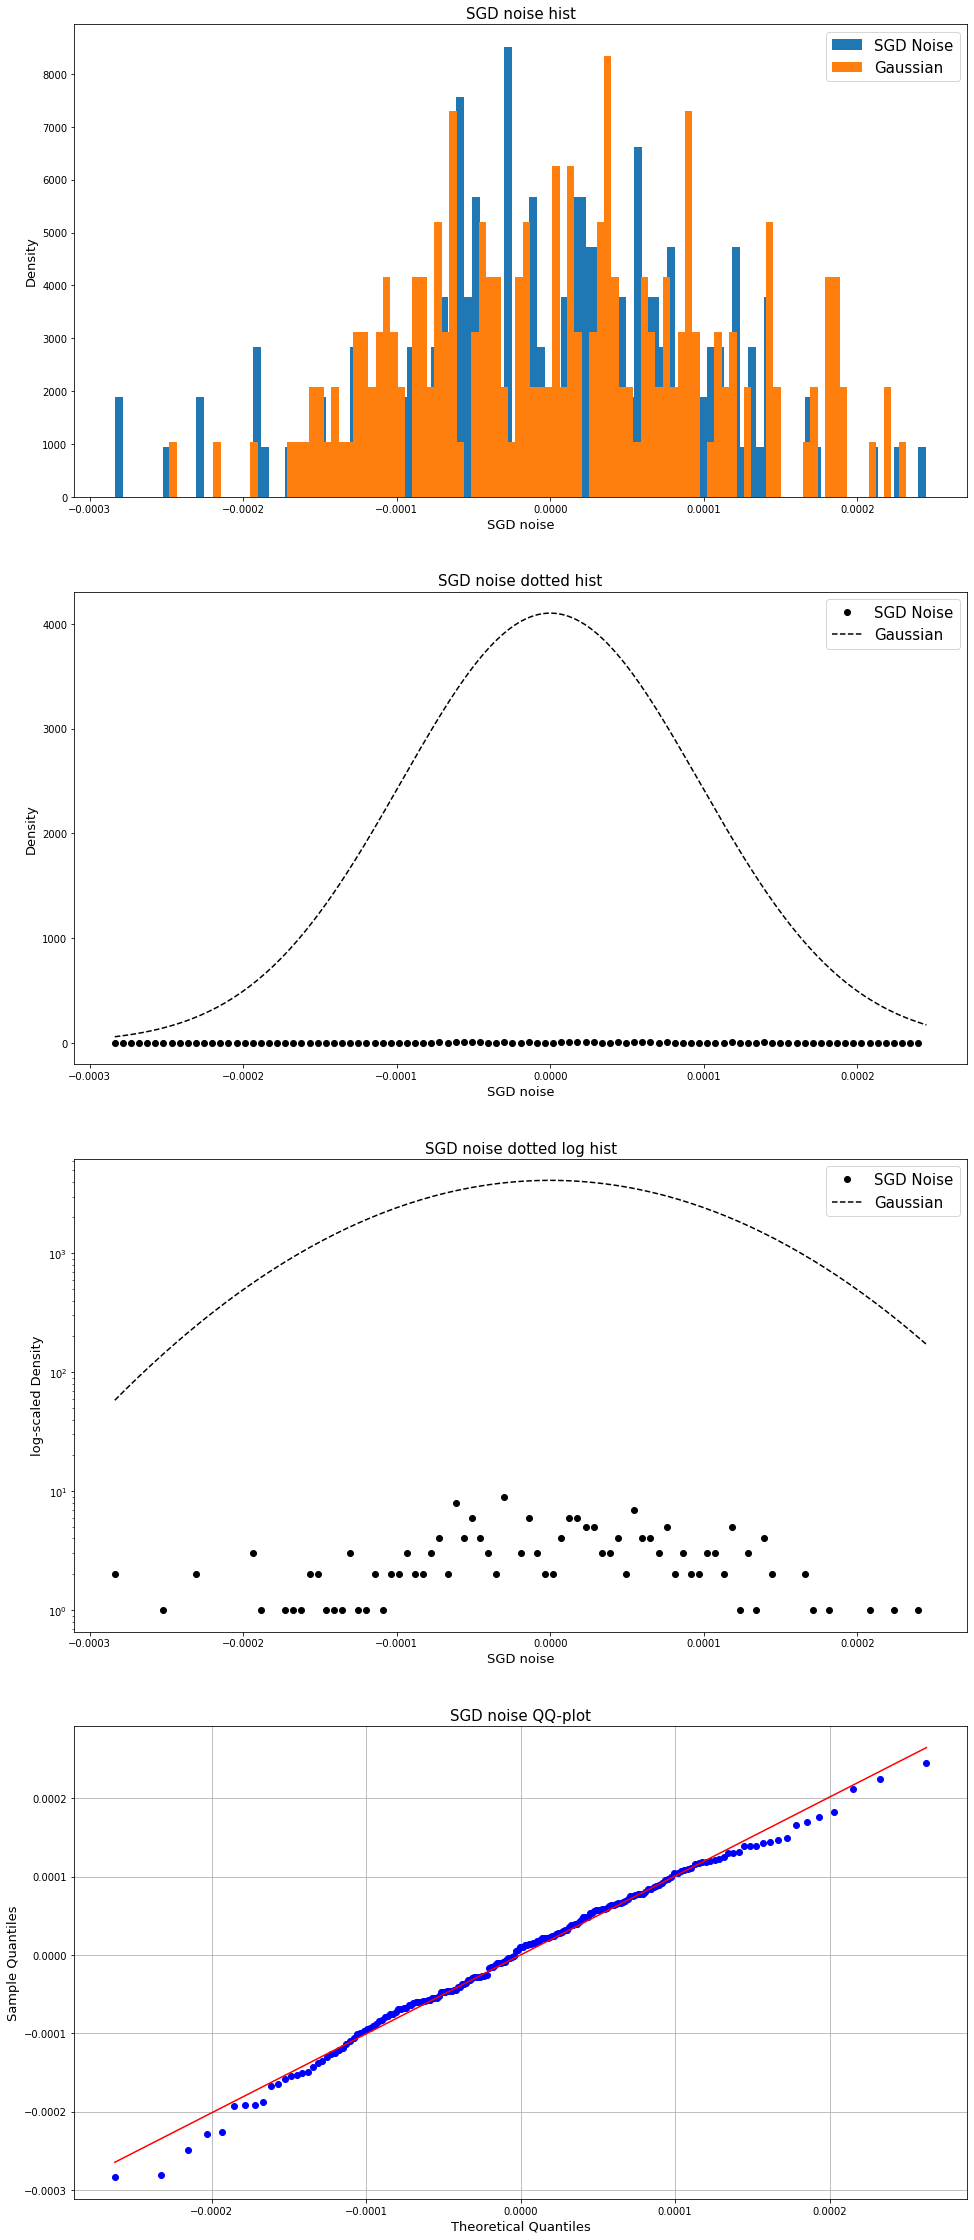

In [82]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][111], distribution=norm, dist_name='Gaussian', bins=100)

# Conv2

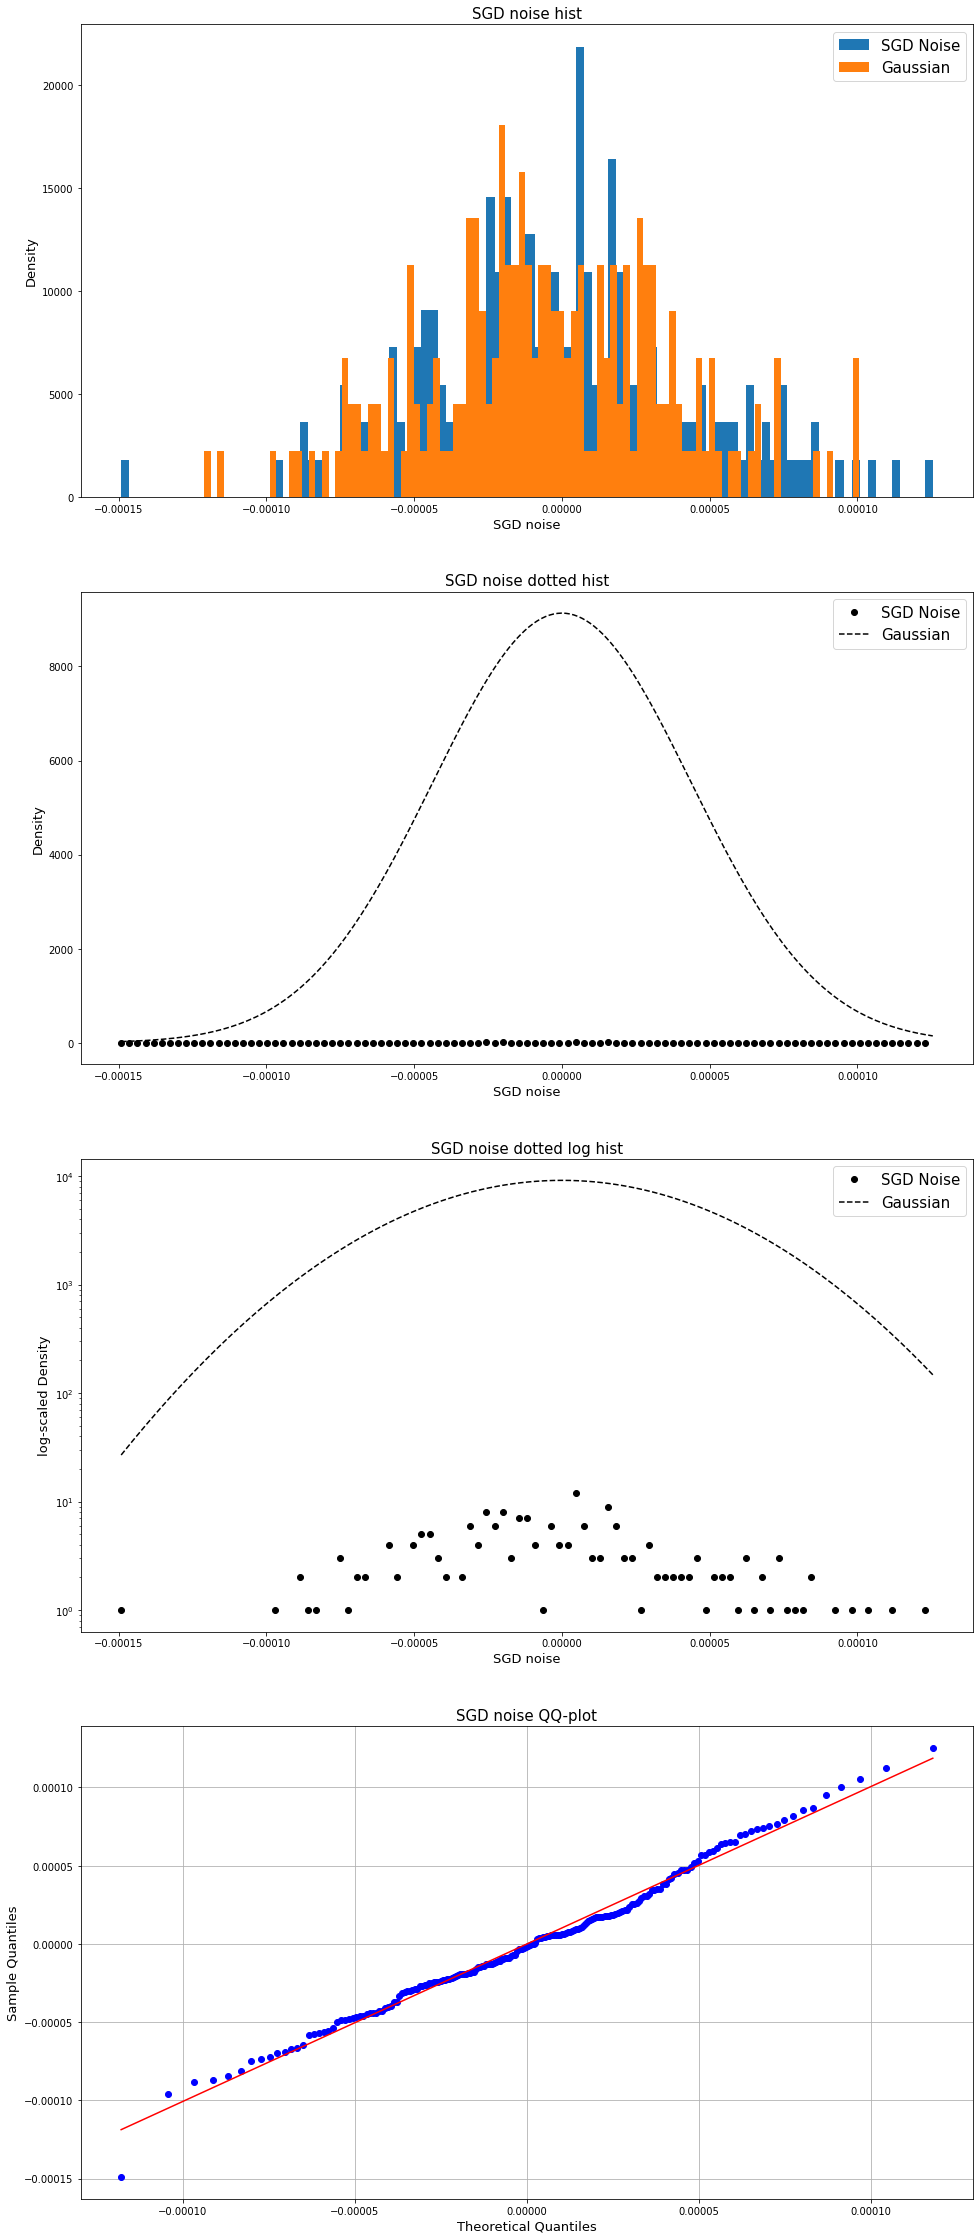

In [83]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][300], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 1

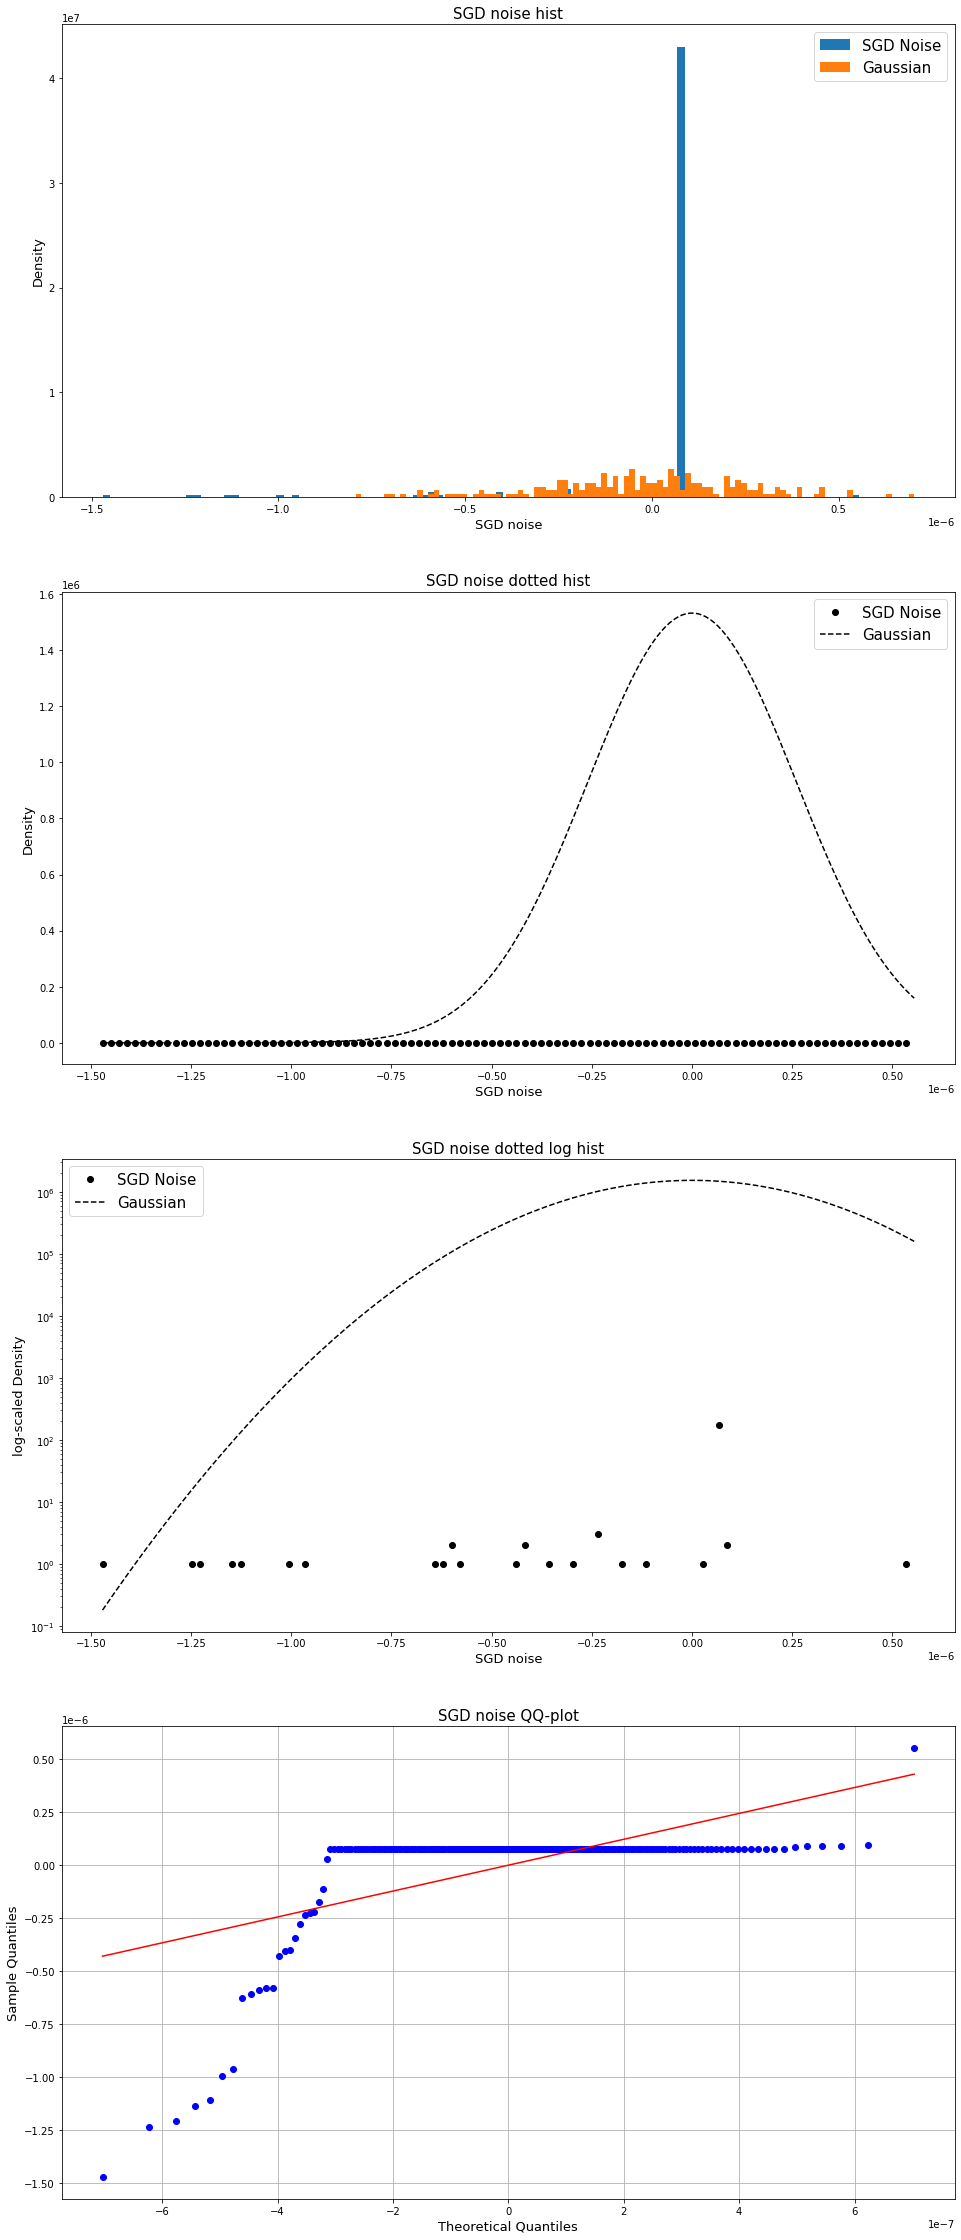

In [84]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][20000], distribution=norm, dist_name='Gaussian', bins=100)

# Linear 2

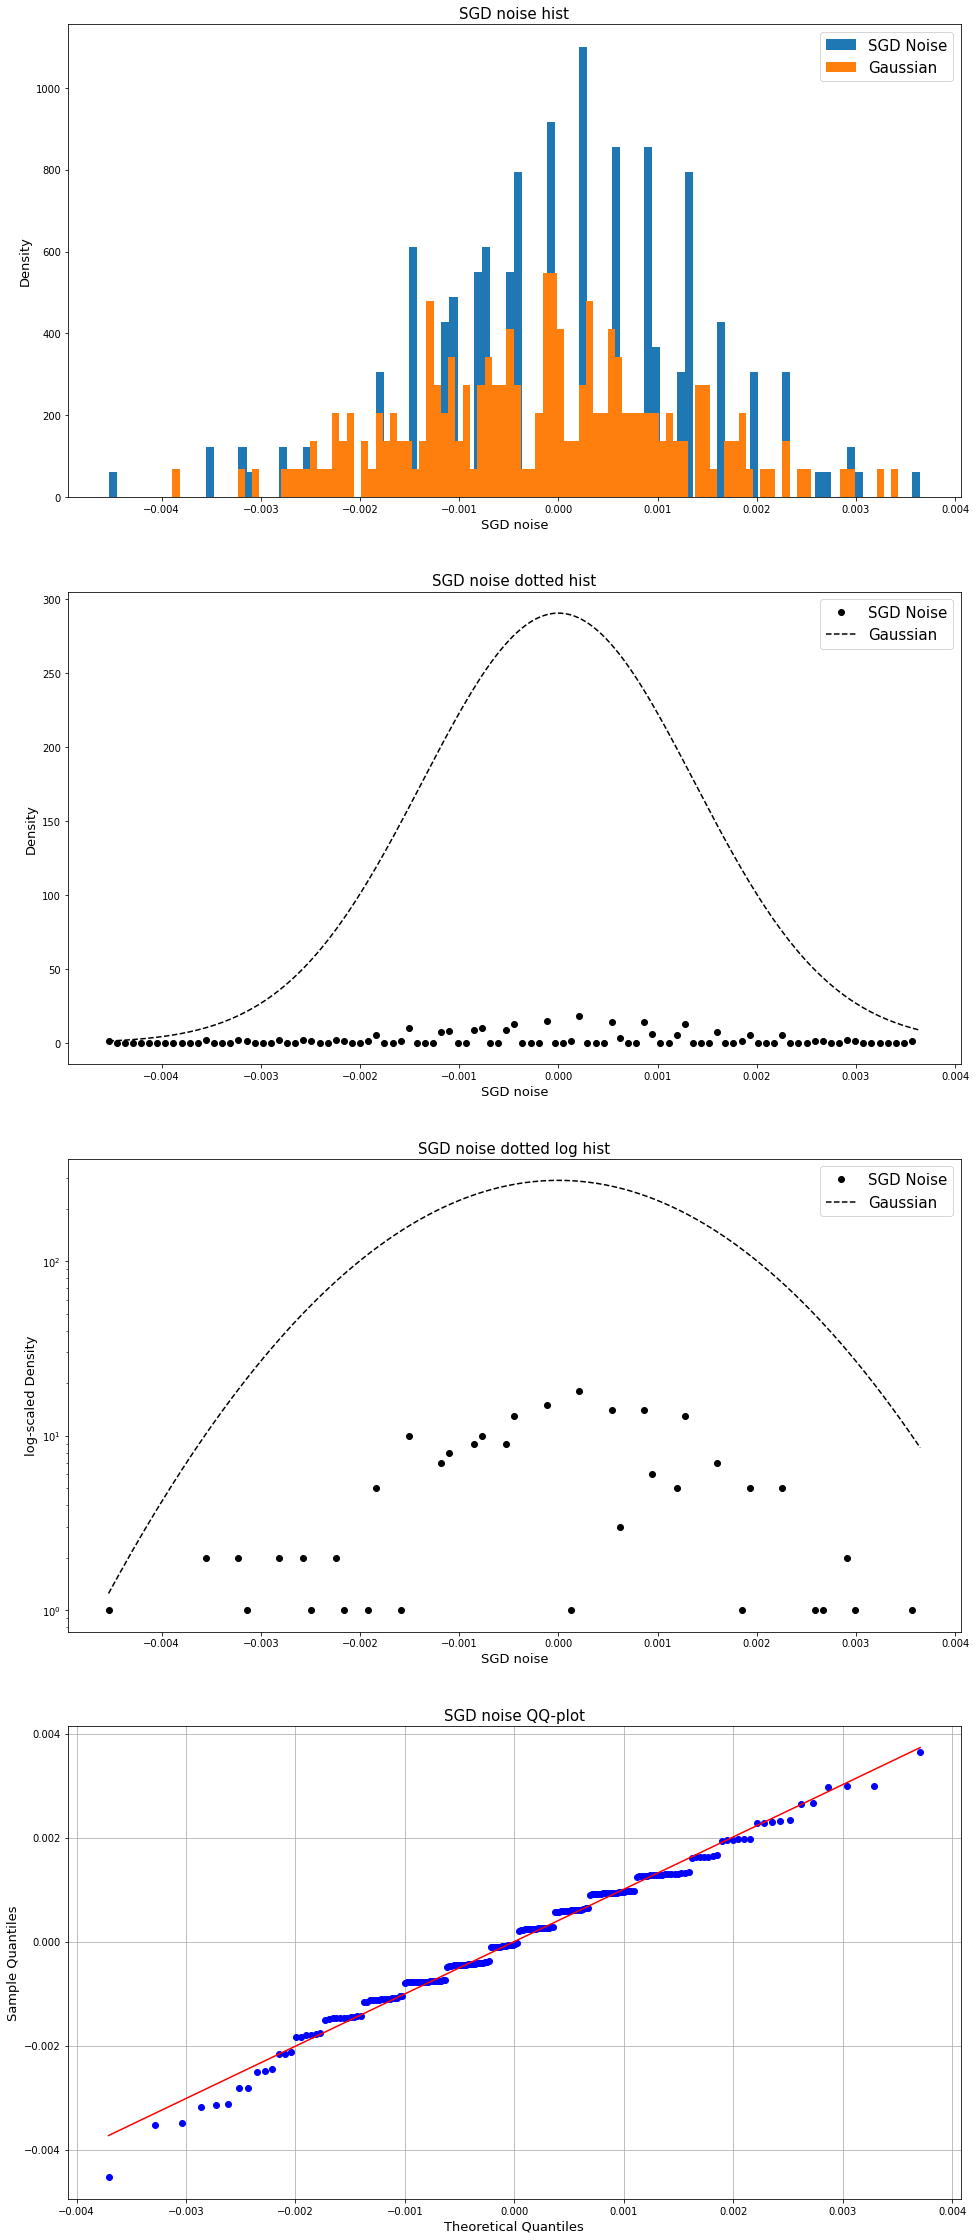

In [85]:
SGD_noise_distplots(SGD_noise=sgn_storage[0][-1], distribution=norm, dist_name='Gaussian', bins=100)

## Iteration #10

In [86]:
# 1200 gradients per batch for 89848 neurons in 10th epoch
sgn_storage[10].shape

(30134, 200)

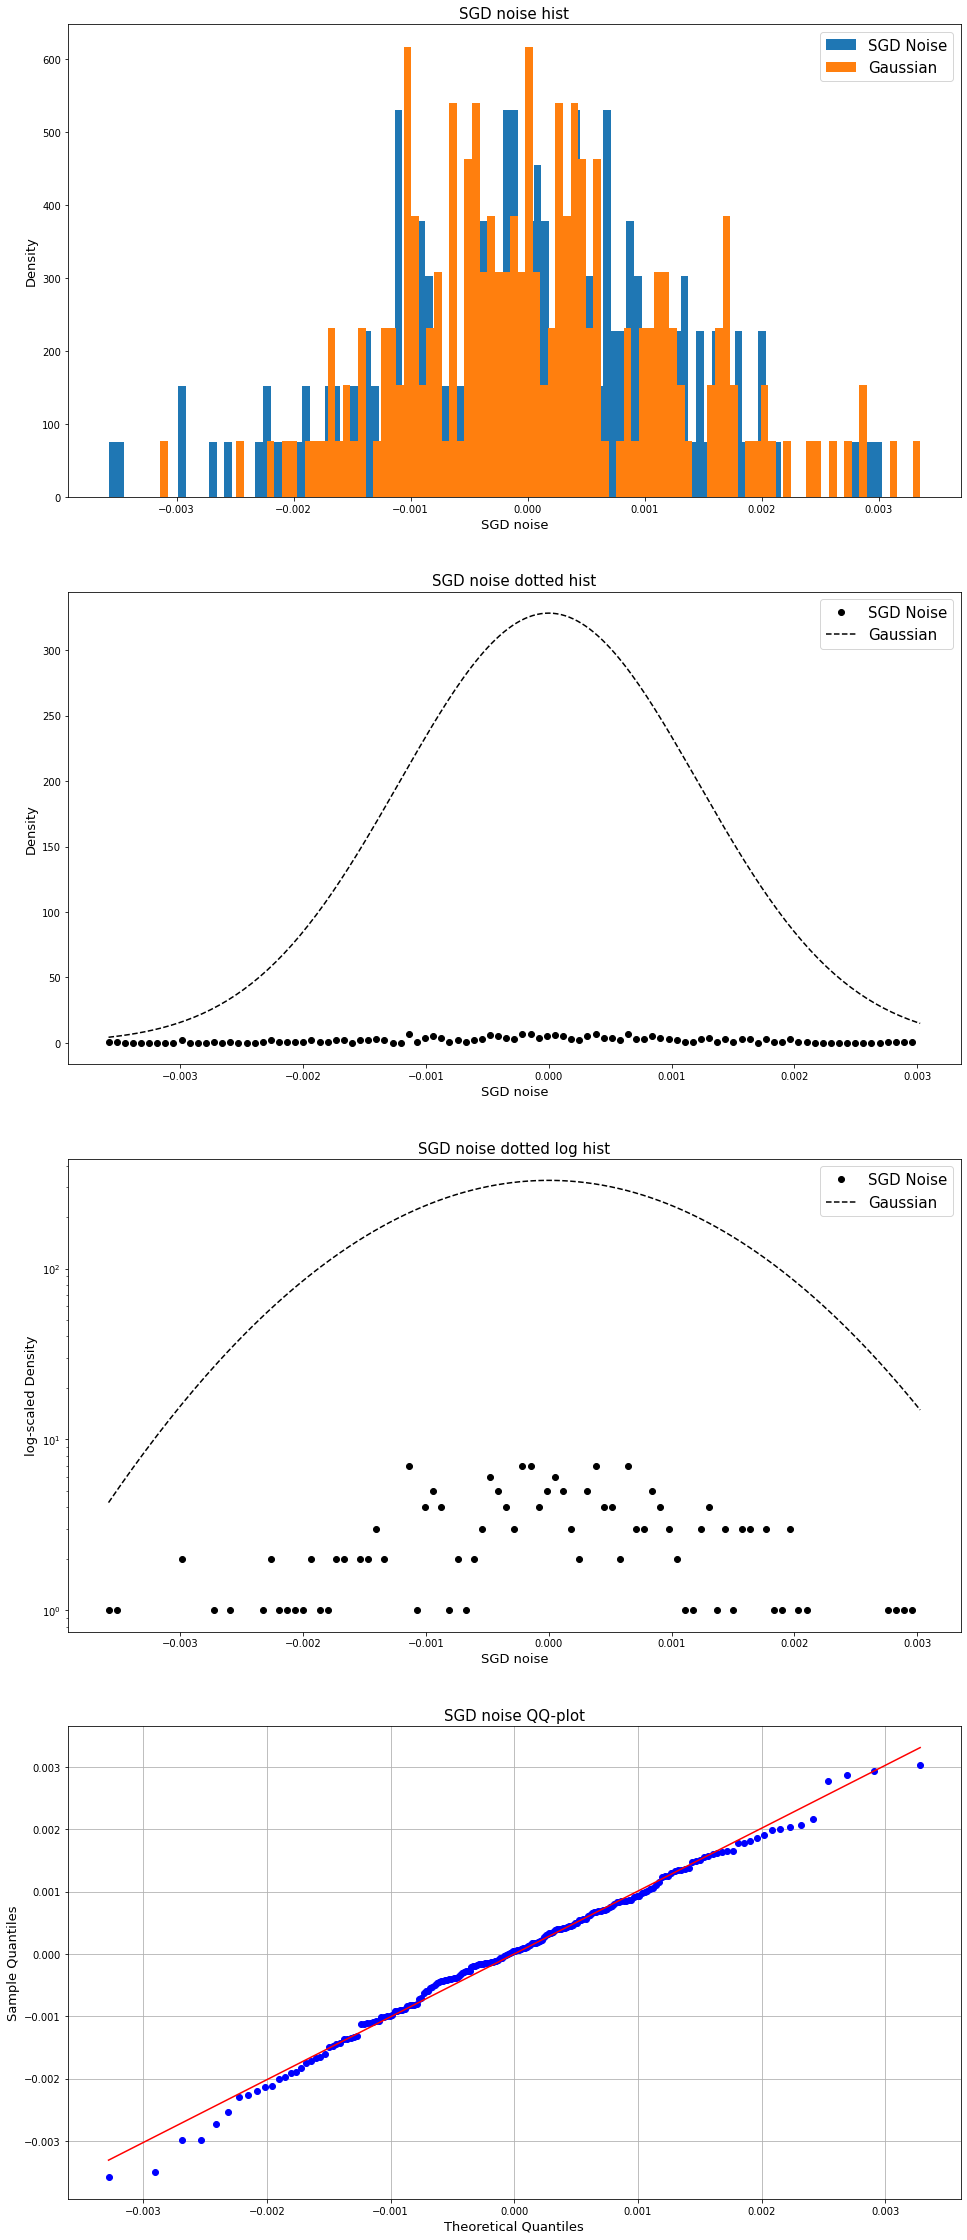

In [87]:
#Conv1
SGD_noise_distplots(SGD_noise=sgn_storage[10][111], distribution=norm, dist_name='Gaussian', bins=100)

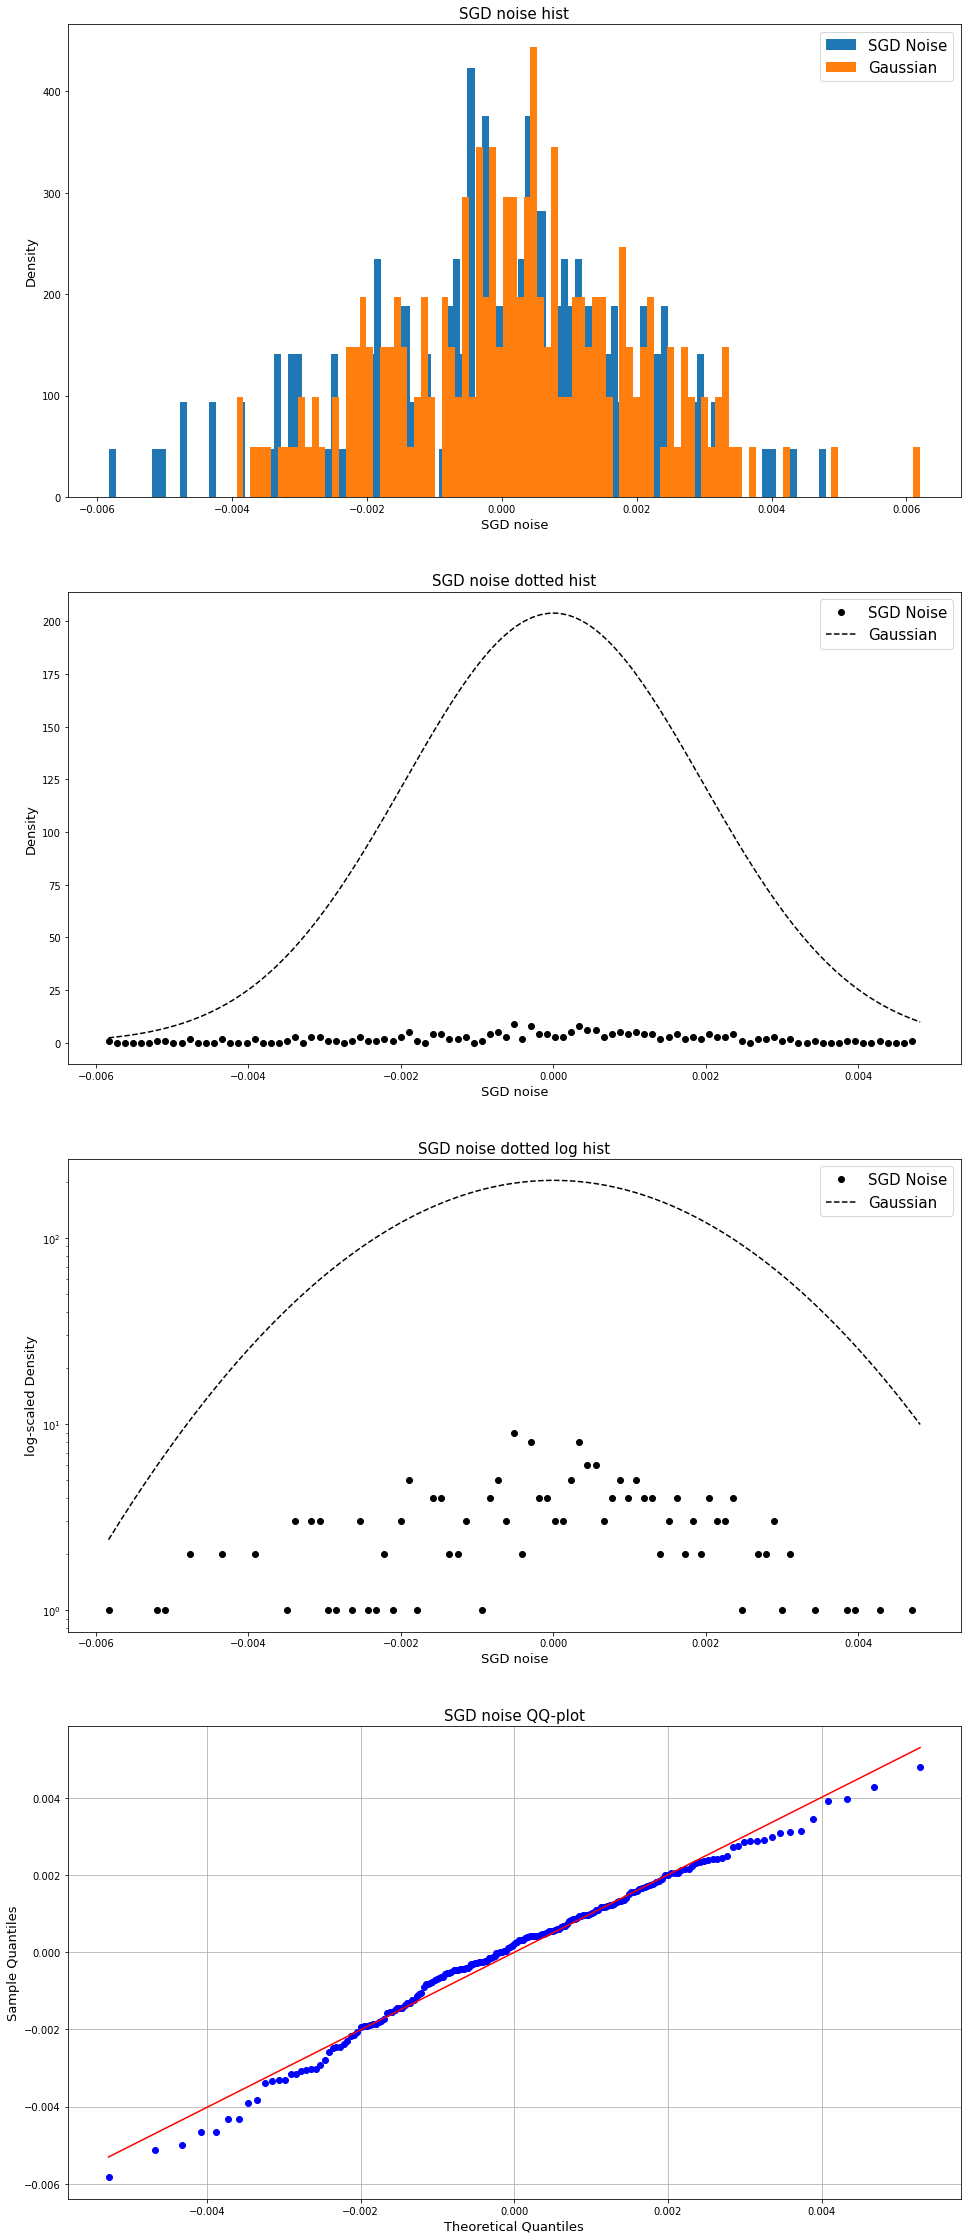

In [88]:
#Conv2
SGD_noise_distplots(SGD_noise=sgn_storage[10][300], distribution=norm, dist_name='Gaussian', bins=100)

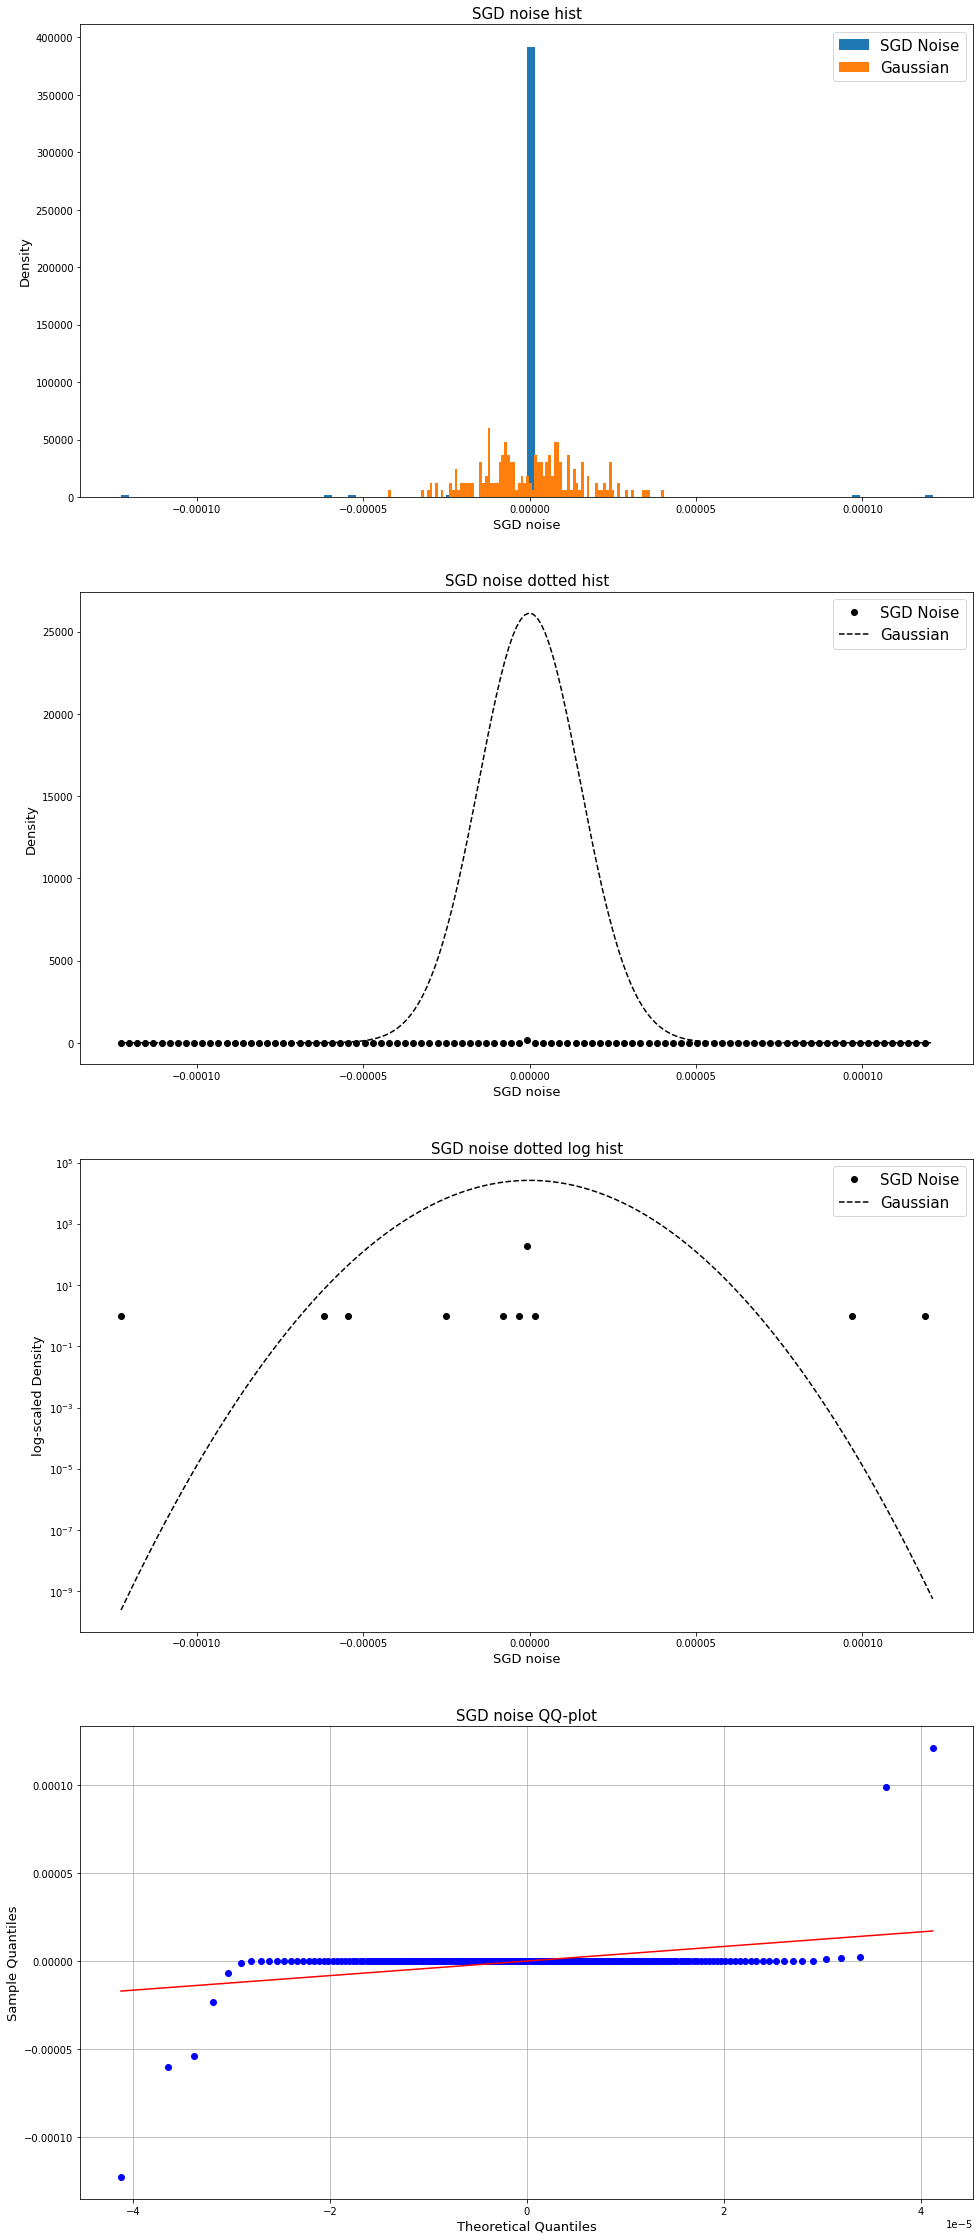

In [89]:
#Linear 1
SGD_noise_distplots(SGD_noise=sgn_storage[10][20000], distribution=norm, dist_name='Gaussian', bins=100)

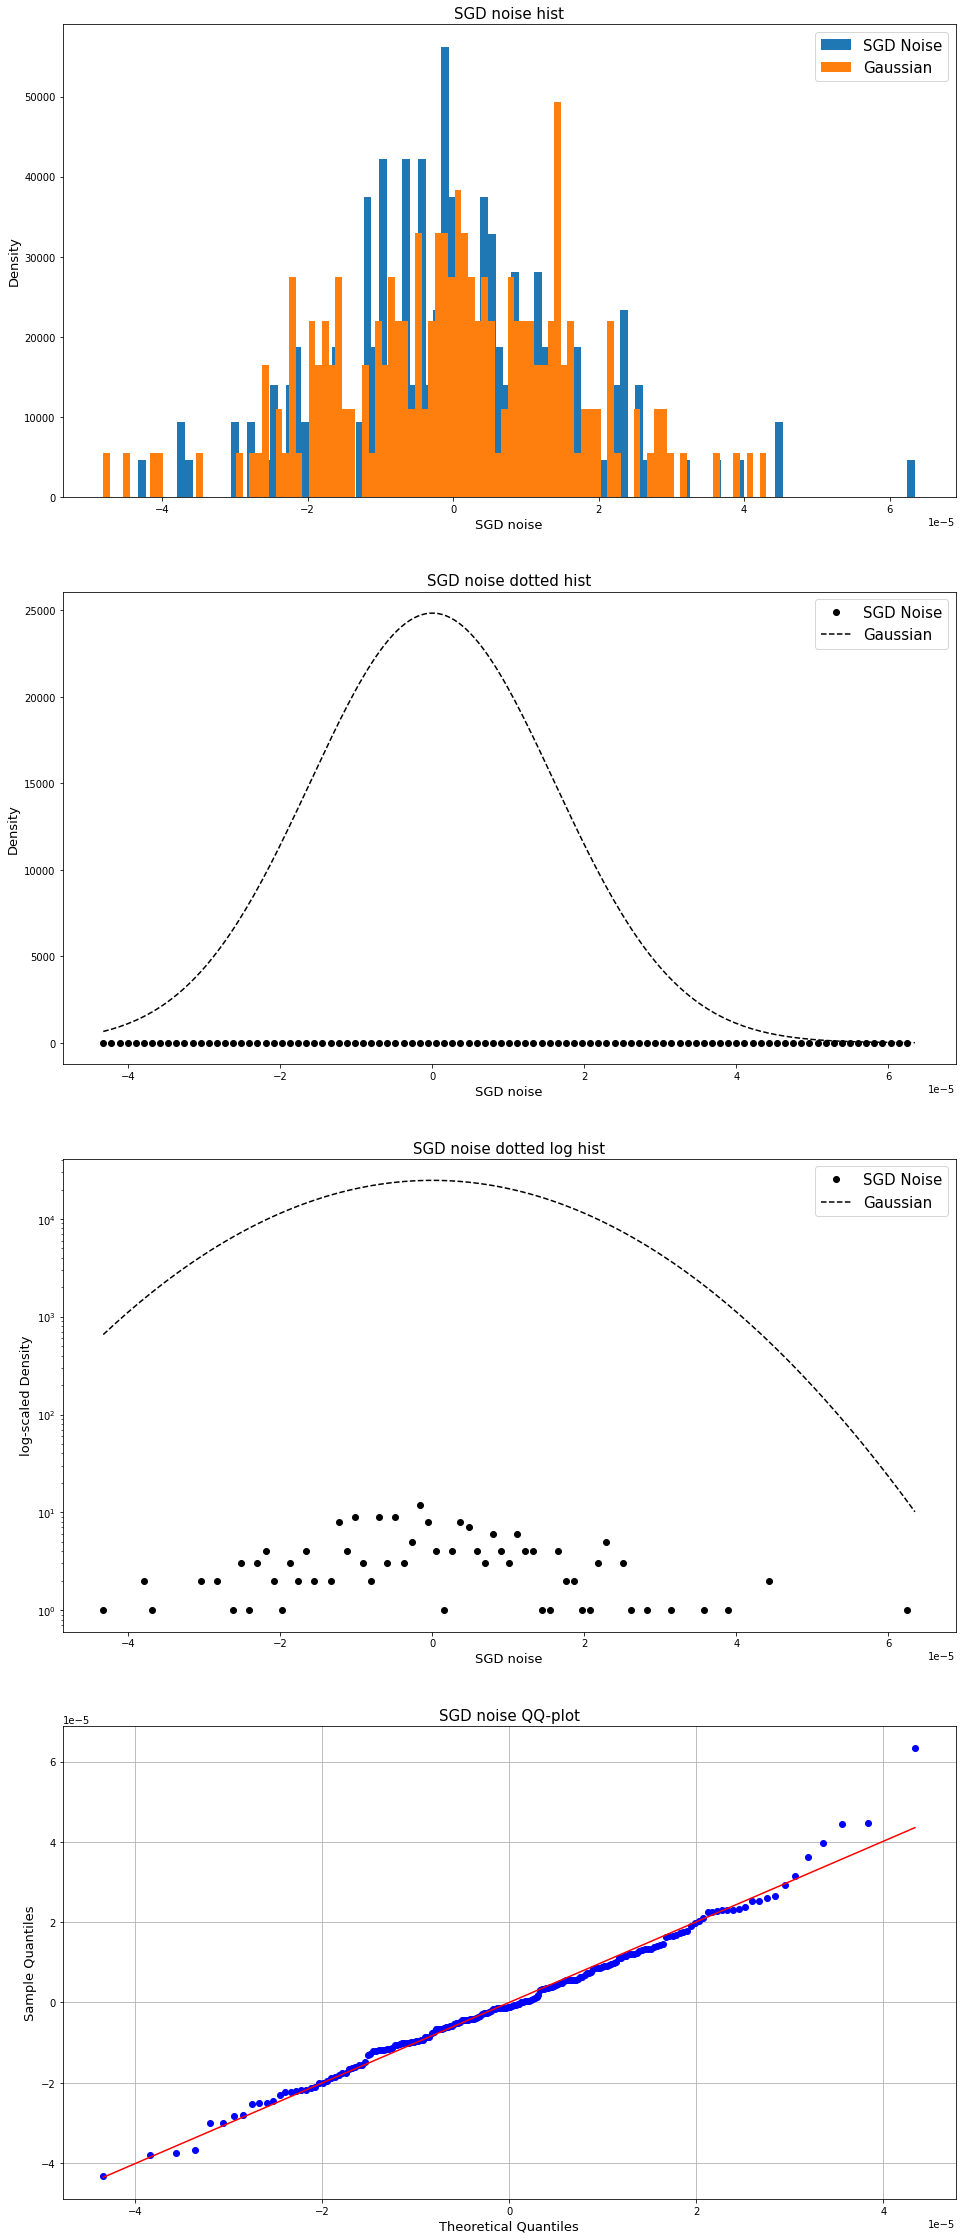

In [90]:
#Linear2
SGD_noise_distplots(SGD_noise=sgn_storage[10][-1], distribution=norm, dist_name='Gaussian', bins=100)